<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Wideband/Aging_CRV168.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init and get a ticket

In [1]:
!pip install -q hist > /dev/null
!pip install -q mplhep==0.2.9 > /dev/null # Latest version requires new version of matplot lib
!pip install -q uproot > /dev/null
!pip install lmfit > /dev/null

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import subprocess
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
import uproot
from scipy import stats
import re
import glob
import sys
import lmfit
from lmfit.models import LinearModel
import hist
import mplhep as hep
hep.style.set_style('ATLAS')  # or ATLAS/LHCb2

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_rows', 100)
plt.rcParams.update({'figure.max_open_warning': 0})

BAD_RUNS=[1066, 1084]

In [3]:
!apt-get -qq install krb5-user > /dev/null
!wget https://authentication.fnal.gov/krb5conf/Linux/krb5.conf > /dev/null
os.environ['KRB5_CONFIG'] = 'krb5.conf'
!kinit oksuzian@FNAL.GOV
!scp  -r -o StrictHostKeyChecking=no -o GSSAPIAuthentication=yes -o GSSAPIDelegateCredentials=yes oksuzian@mu2egpvm03.fnal.gov:/mu2e/data/users/oksuzian/crvaging-004/rec.mu2e.CRV_wideband_cosmics.crvaging-00[3-5]*root .

--2022-09-12 12:48:07--  https://authentication.fnal.gov/krb5conf/Linux/krb5.conf
Resolving authentication.fnal.gov (authentication.fnal.gov)... 131.225.105.240, 2620:6a:0:105::105:240
Connecting to authentication.fnal.gov (authentication.fnal.gov)|131.225.105.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17486 (17K) [text/plain]
Saving to: ‘krb5.conf’

krb5.conf           100%[===================>]  17.08K  --.-KB/s    in 0.02s   

2022-09-12 12:48:08 (737 KB/s) - ‘krb5.conf’ saved [17486/17486]

Password for oksuzian@FNAL.GOV: 


#Get root files with runSummary

In [4]:
df = pd.DataFrame()
listing = glob.glob('rec.*.root')
for root_file in listing:
  print(root_file)
  run = int(re.split('\.|_', root_file)[6])
  subrun = int(re.split('\.|_', root_file)[7])

#  run = int(re.split('\.|_', root_file)[7])
#  subrun = int(re.split('\.|_', root_file)[8])

  if run in BAD_RUNS:
    continue

  for key in uproot.open(root_file).keys():
    if 'spill' in key:
      continue
    tree = uproot.open(root_file+":"+key)
    df_ = tree.arrays(library="pd")
    df_.columns = df_.columns.str.replace(r'\[', '_')
    df_.columns = df_.columns.str.replace(r'\]', '')

    df_['run'] = int(run)
    df_['subrun'] = int(subrun)
    df = df.append(df_)

rec.mu2e.CRV_wideband_cosmics.crvaging-005.001141_000.root


/usr/local/lib/python3.7/dist-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragm

rec.mu2e.CRV_wideband_cosmics.crvaging-004.001082_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-005.001137_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001091_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001084_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-005.001138_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001080_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001054_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001059_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001066_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001133_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001124_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001134_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001053_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001081_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-004.001079_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-003.001116_000.root
rec.mu2e.CRV_wideband_cosmics.crvaging-005.001142_000.ro

In [5]:
columns = 'PEsTemperatureCorrected|meanTemperatures|calibConstantsTemperatureCorrected|run|timestamp|febTemperaturesAvg|biasVoltagesAvg|signal'
df=df.filter(regex=columns)

In [6]:
df.filter(regex='signalsTemperatureCorrected_2_0|run')

signalsTemperatureCorrected_2_0   run  subrun
0                           1720.0  1141       0
0                           2887.0  1082       0
0                           1684.0  1137       0
0                          10051.0  1091       0
0                           7665.0  1138       0
0                           2852.0  1080       0
0                           4995.0  1054       0
0                           3908.0  1059       0
0                           1825.0  1133       0
0                           1696.0  1124       0
0                            820.0  1134       0
0                           2874.0  1053       0
0                           2847.0  1081       0
0                           1870.0  1079       0
0                           3076.0  1116       0
0                           1915.0  1142       0
0                           8466.0  1146       0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


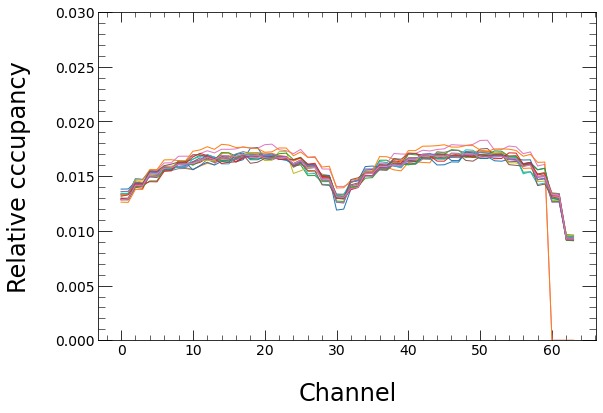

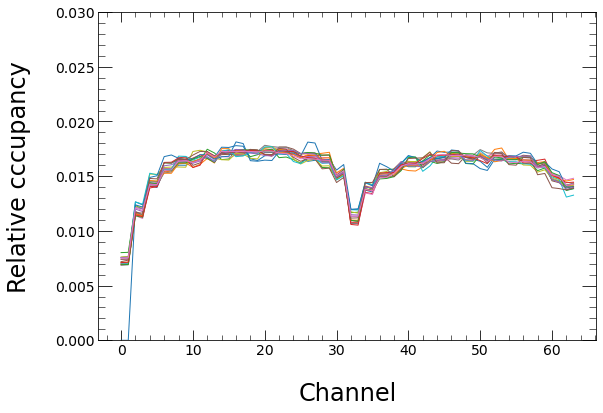

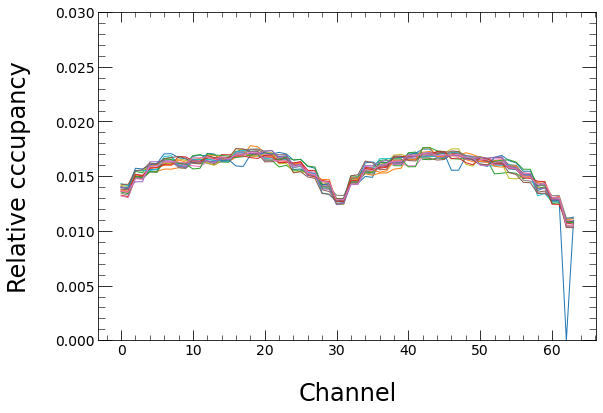

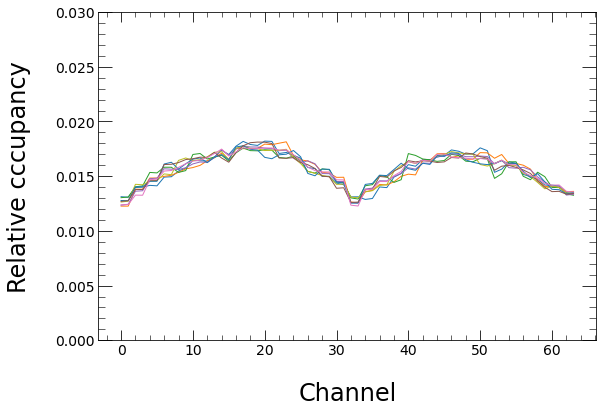

In [7]:
from numpy.core.function_base import linspace
for feb in range(0, 4):
  plt.figure()
  df_ = df.query('signalsTemperatureCorrected_2_0>0')
  for run in df_['run'].values.flatten():
    x=linspace(0,63,64)
    y=df_.query('run==%d'%run).filter(regex='signalsTemperatureCorrected_%d_'%feb).values.flatten()
    y=y/y.sum()
    plt.plot(x,y, '-', label='Run: %d'%run);
    plt.ylabel('Relative cccupancy')
    plt.xlabel('Channel')
    plt.ylim(0,0.03)
#    plt.legend()

<Figure size 630x426.24 with 0 Axes>

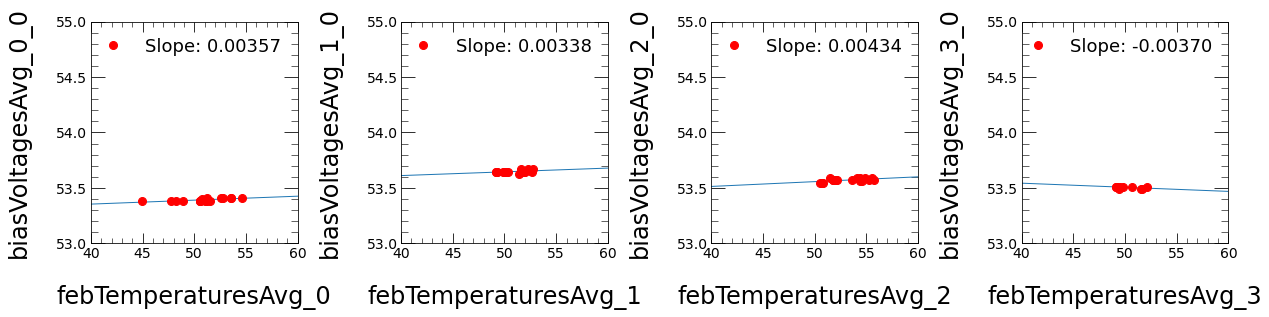

<Figure size 630x426.24 with 0 Axes>

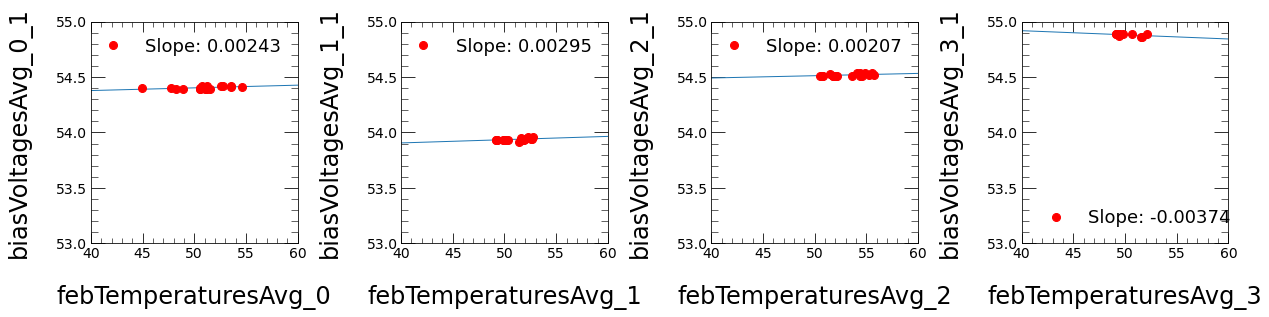

<Figure size 630x426.24 with 0 Axes>

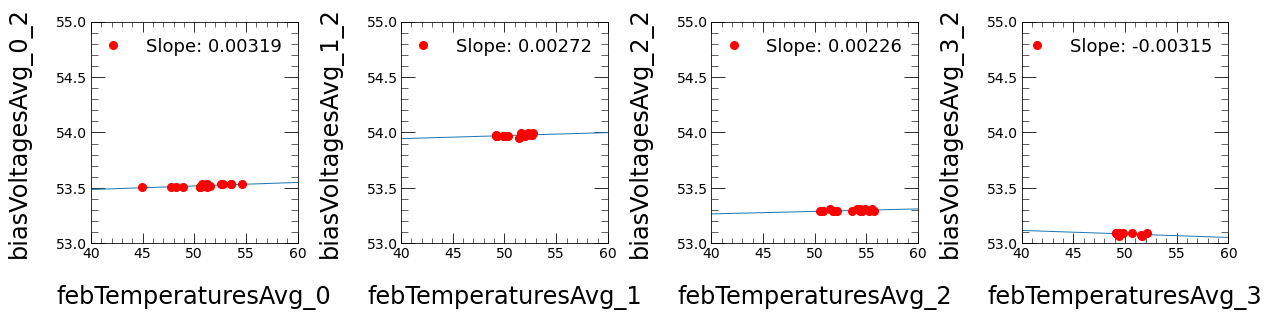

<Figure size 630x426.24 with 0 Axes>

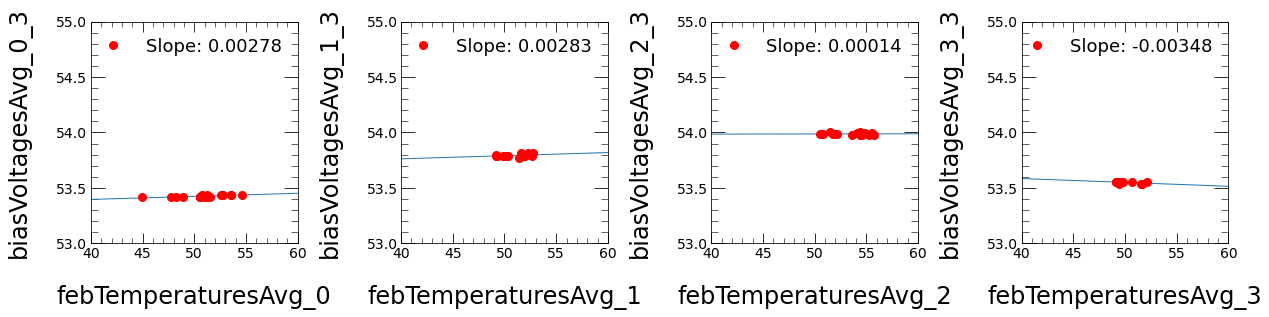

<Figure size 630x426.24 with 0 Axes>

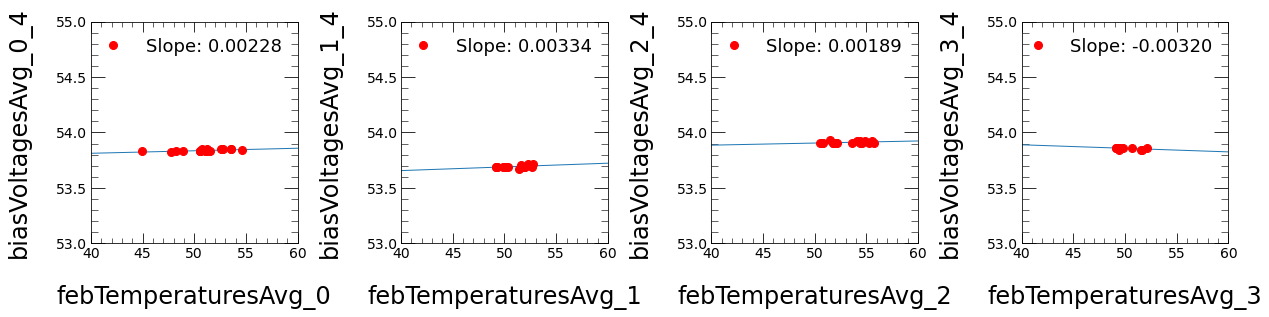

<Figure size 630x426.24 with 0 Axes>

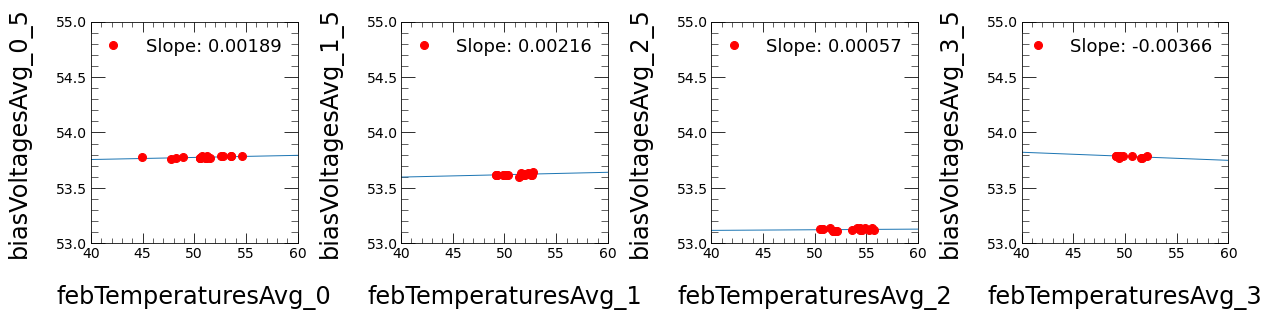

<Figure size 630x426.24 with 0 Axes>

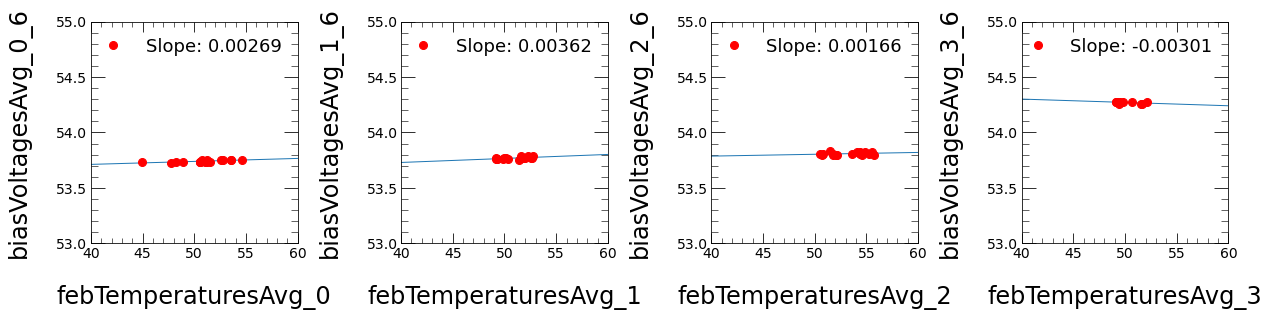

<Figure size 630x426.24 with 0 Axes>

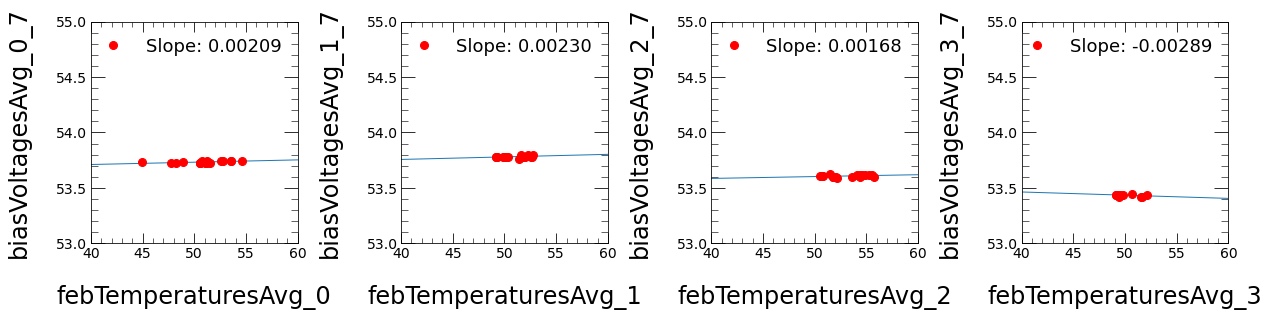

In [8]:
for i in range(0,8):

  plt.figure()
  fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))
  plt.subplots_adjust(wspace=0.5)

  for feb in range(0, 4):
#    df_ = df.query('febTemperaturesAvg_%d > 0'%(feb))
    df_ = df
    x=df_['febTemperaturesAvg_%d'%(feb)].dropna()
    y=df_['biasVoltagesAvg_%d_%d'%(feb, i)].dropna()

    linmodel = np.poly1d(np.polyfit(x, y, 1))
    xline = np.linspace(40, 60, 100)
    ax1[feb].plot(xline, linmodel(xline))
    ax1[feb].plot(x,y,'ro', label='Slope: %.5f'%linmodel.coeffs[0])

    ax1[feb].set_xlabel('febTemperaturesAvg_%d'%(feb))
    ax1[feb].set_ylabel('biasVoltagesAvg_%d_%d'%(feb, i))
    ax1[feb].set_xlim(40,60)
    ax1[feb].set_ylim(53,55)
    ax1[feb].legend()

In [9]:
df = df.sort_values('timestamp')
#Convert columns to proper data types
df['date'] = pd.to_datetime(df['timestamp'], unit='s').dt.date
df['hours']=df['timestamp']/3600
df['days']=df['hours']/24
pd.options.mode.chained_assignment = None
df['years']=(df['days']-df.query('days>=0')['days'].min())/365 #Convert to years

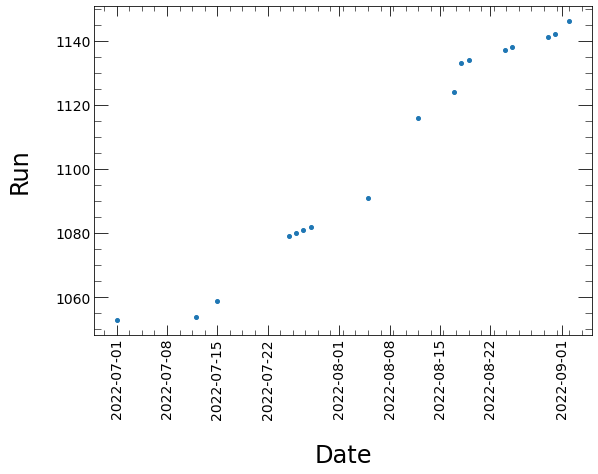

In [10]:
plt.plot(df['date'], df['run'], '.')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Run');

#Make plots

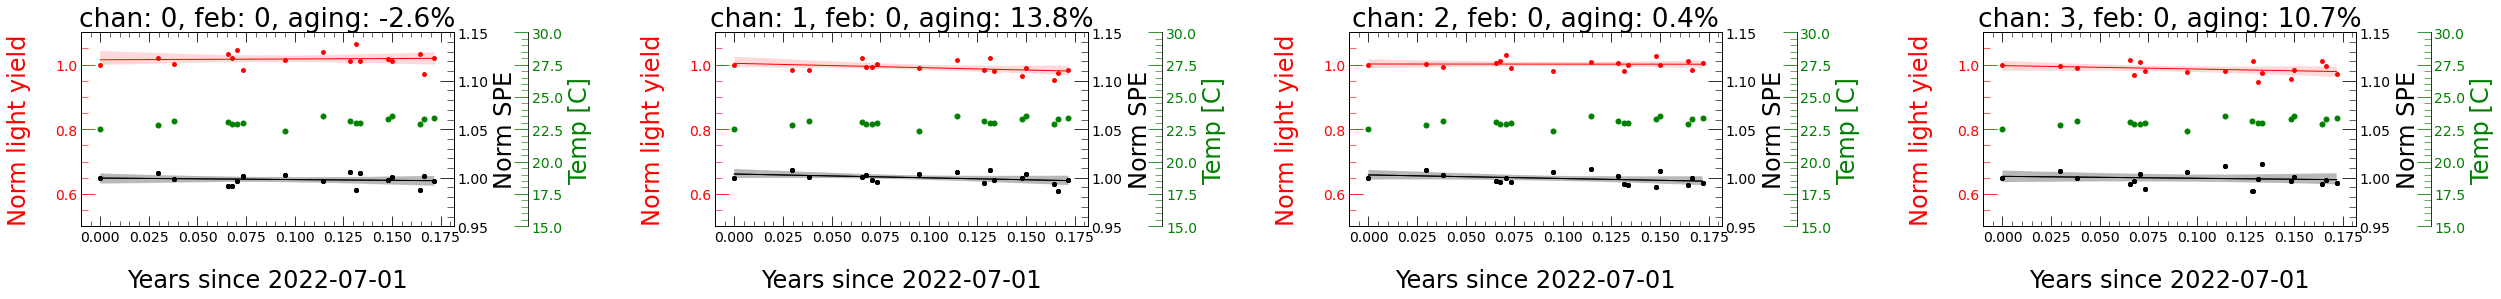

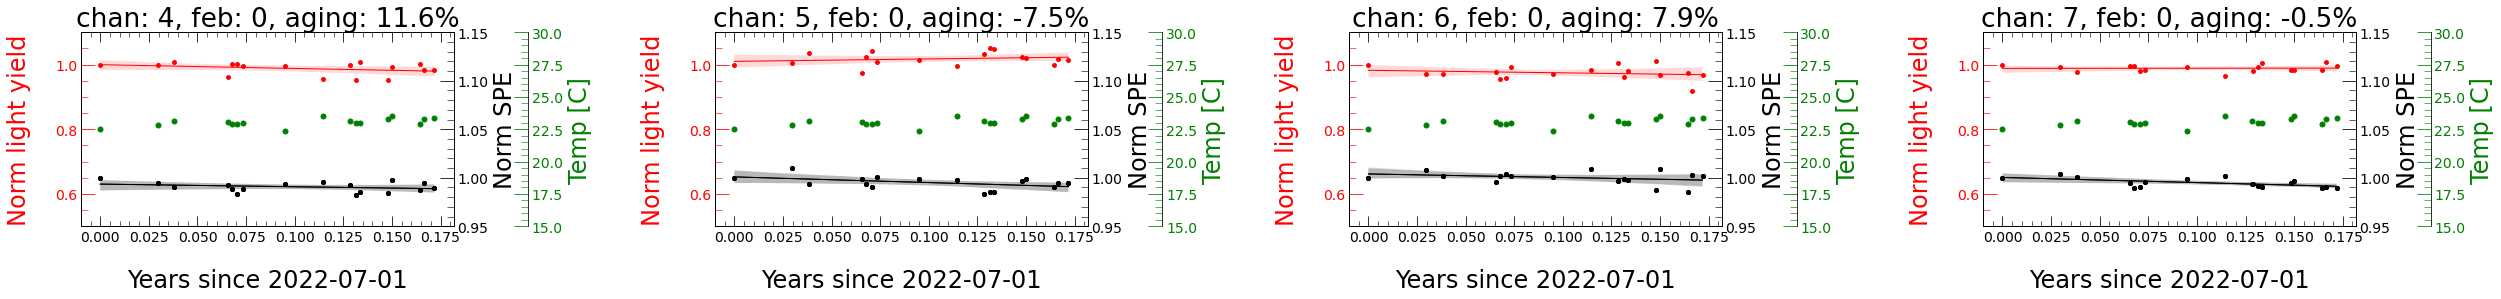

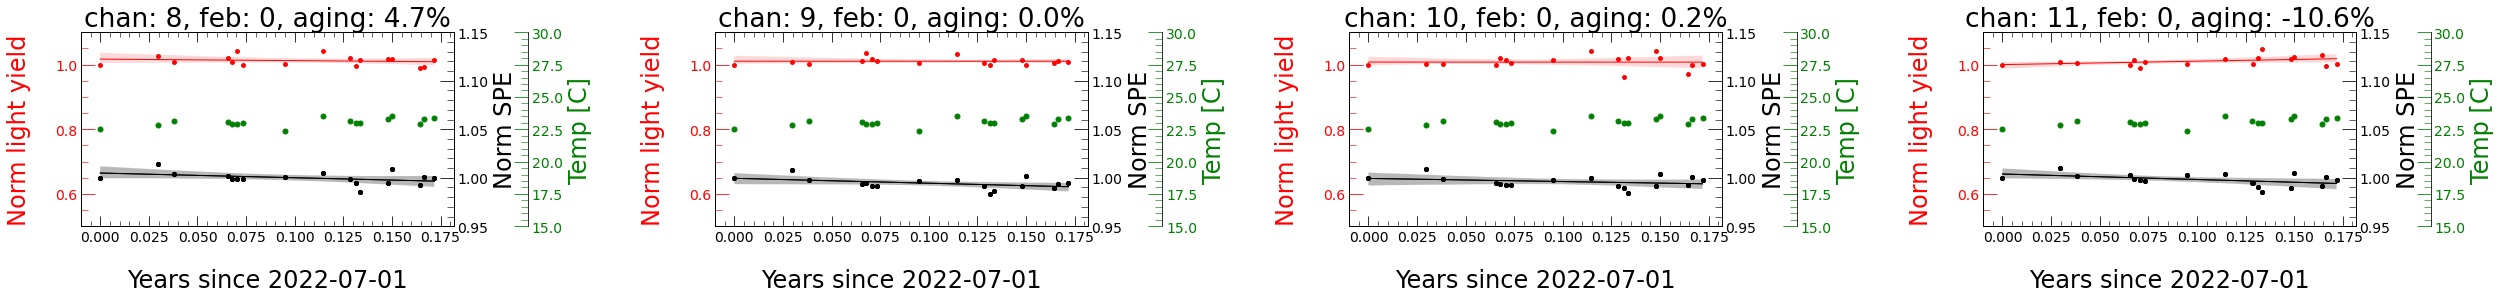

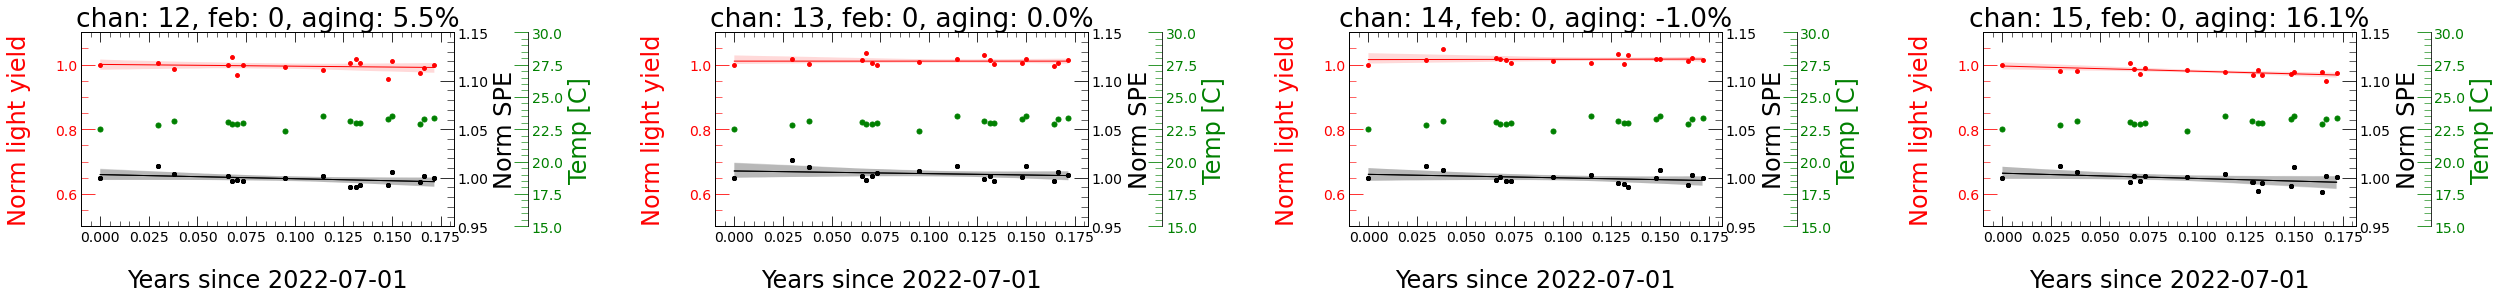

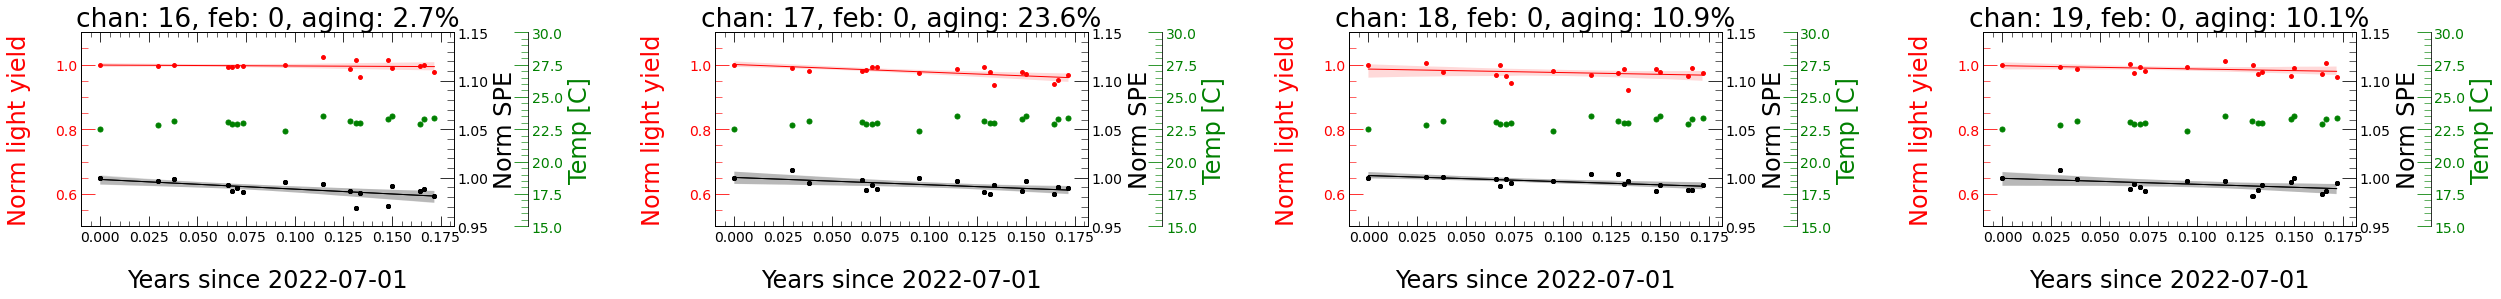

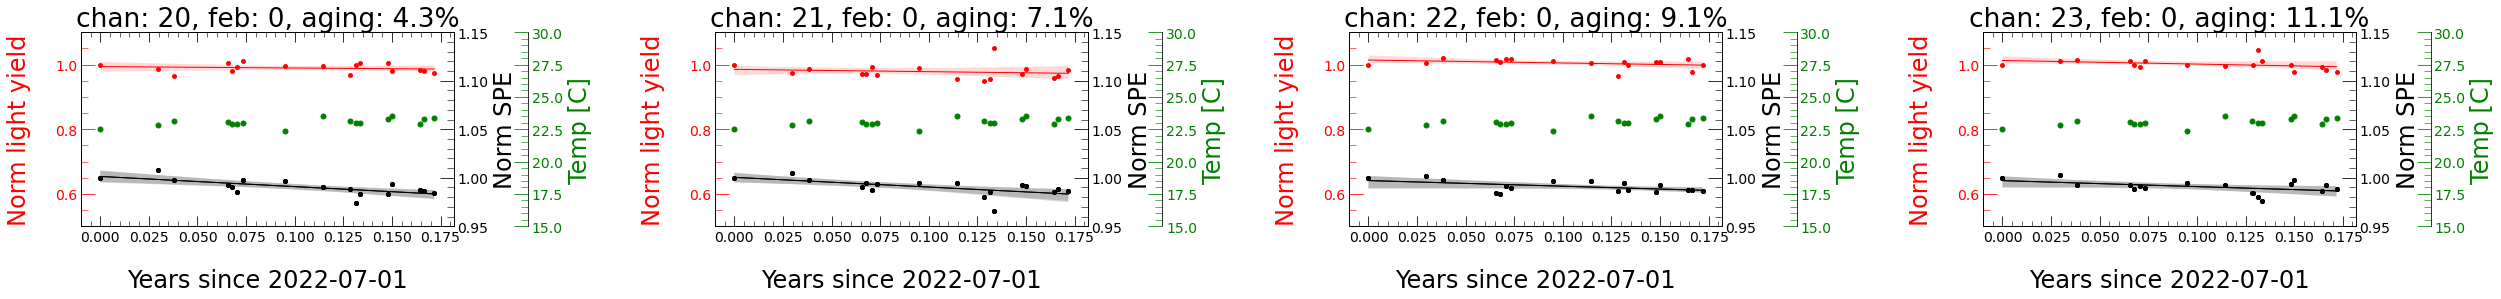

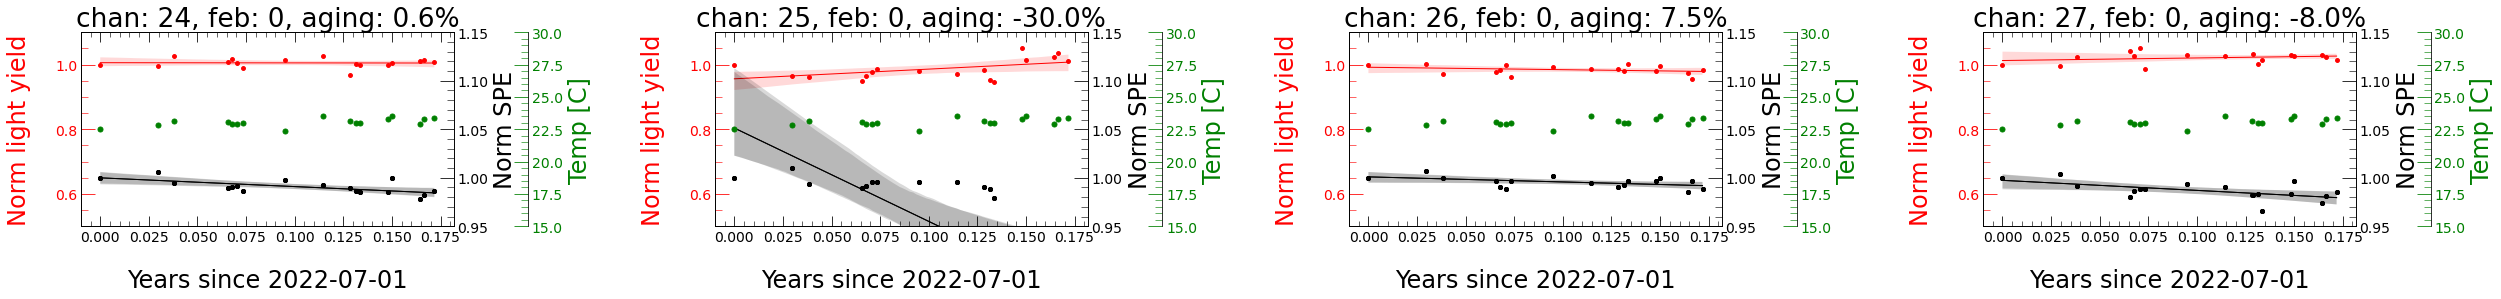

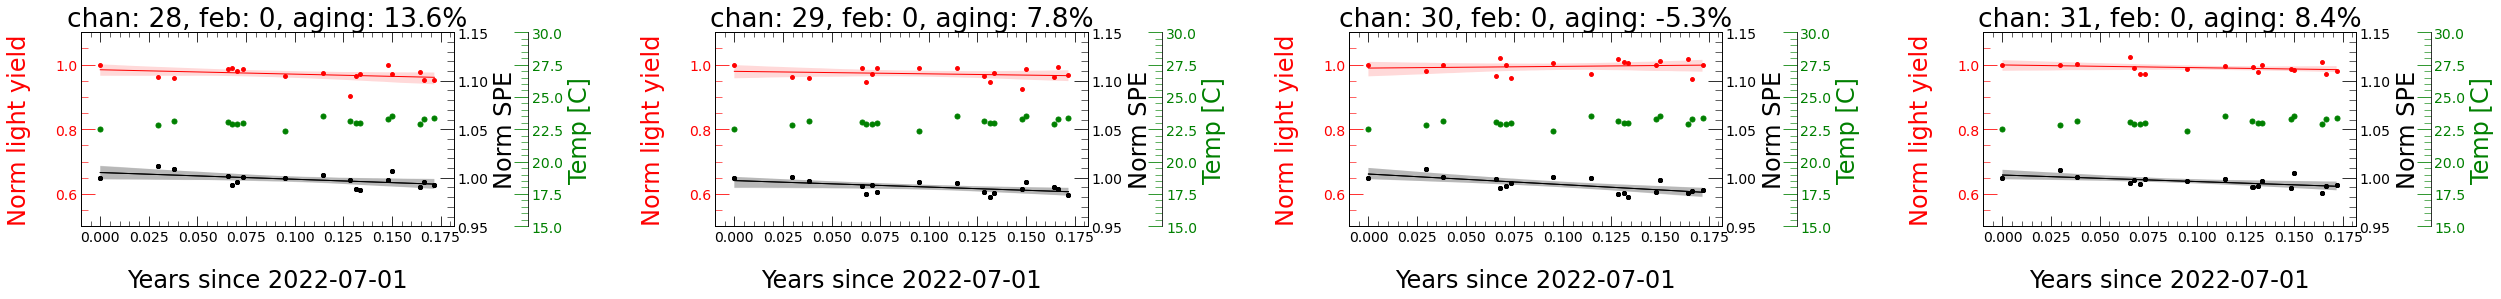

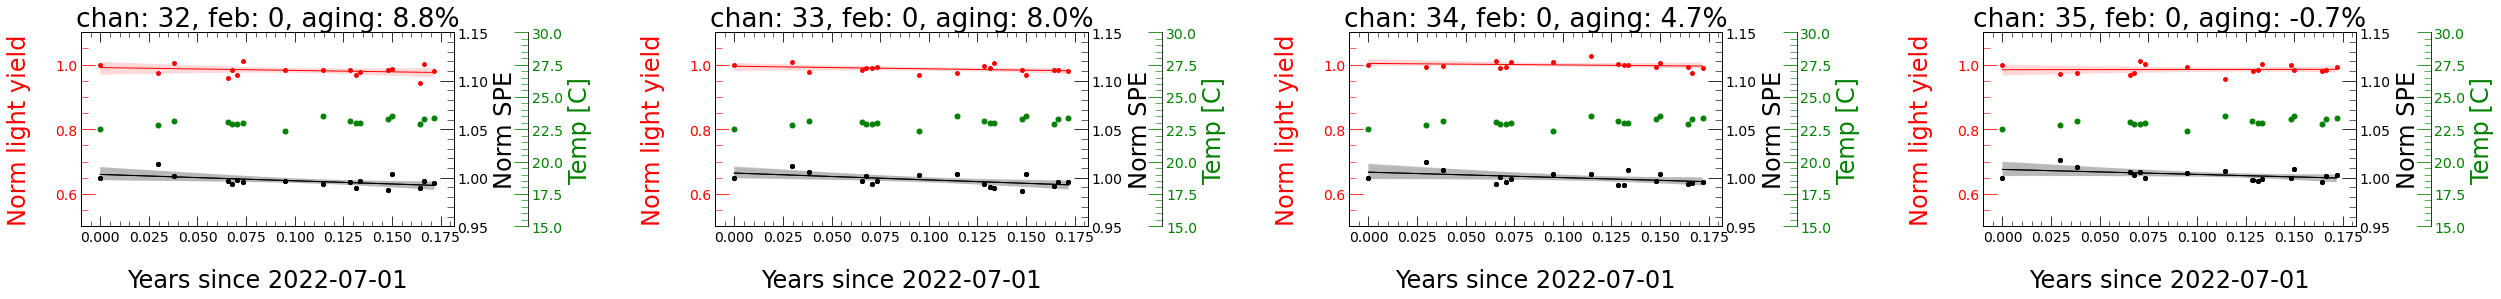

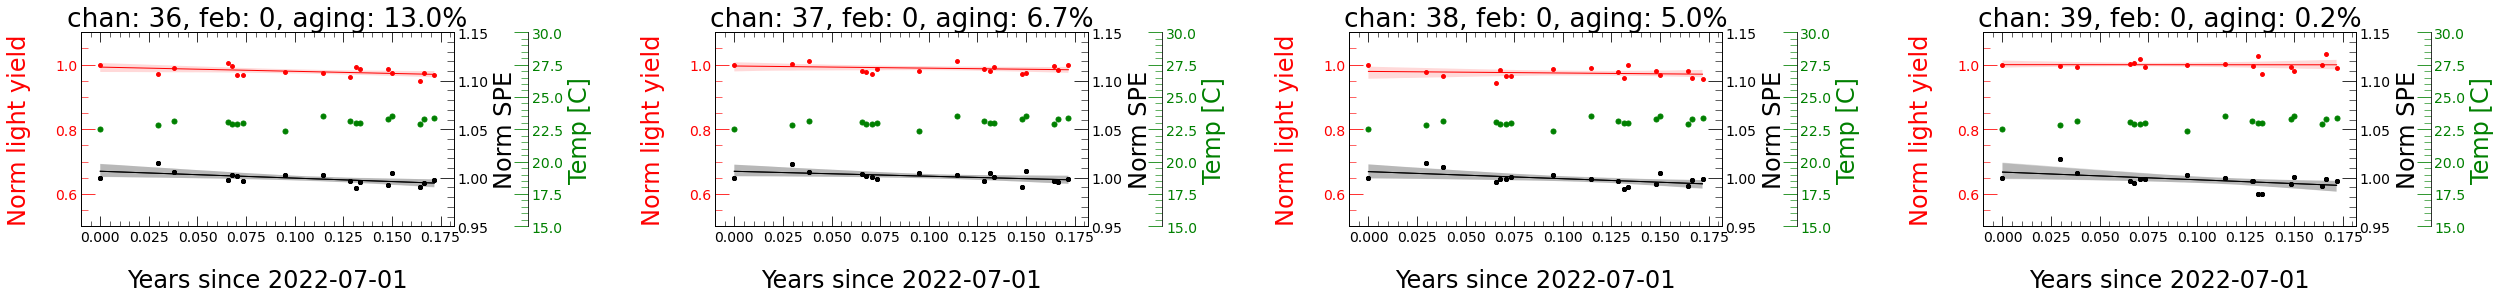

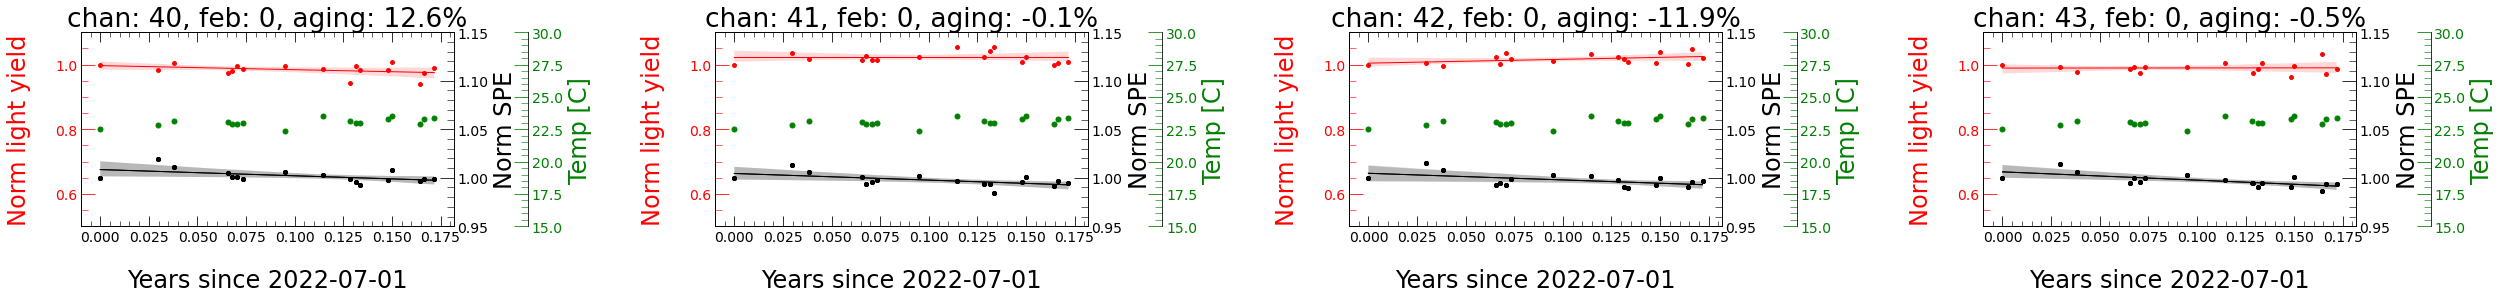

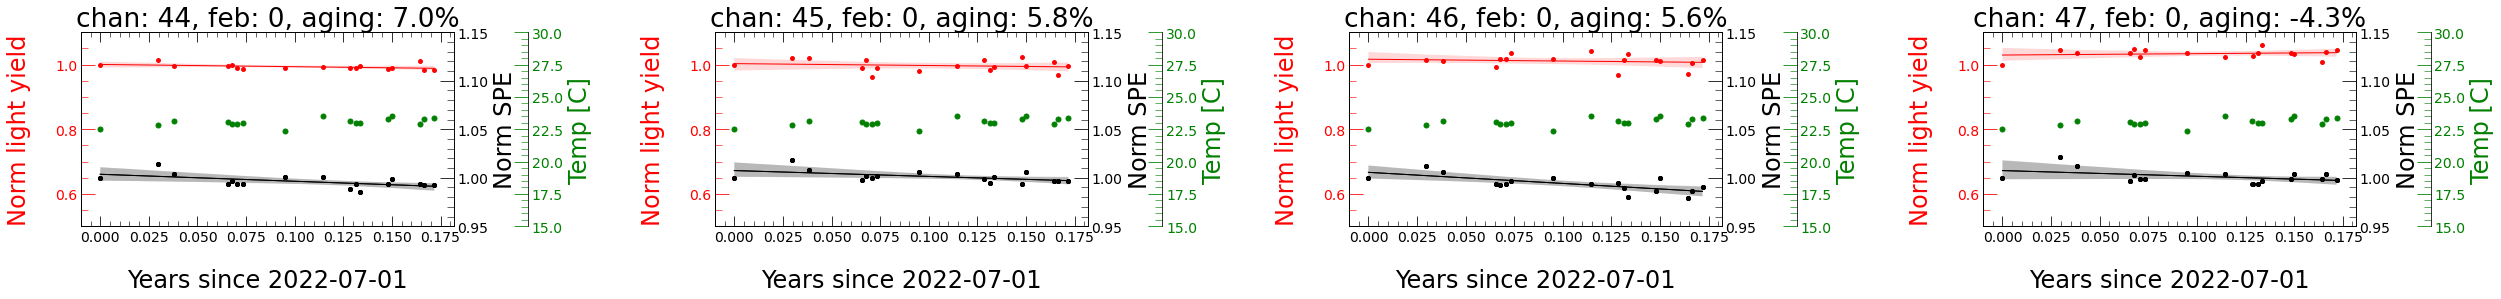

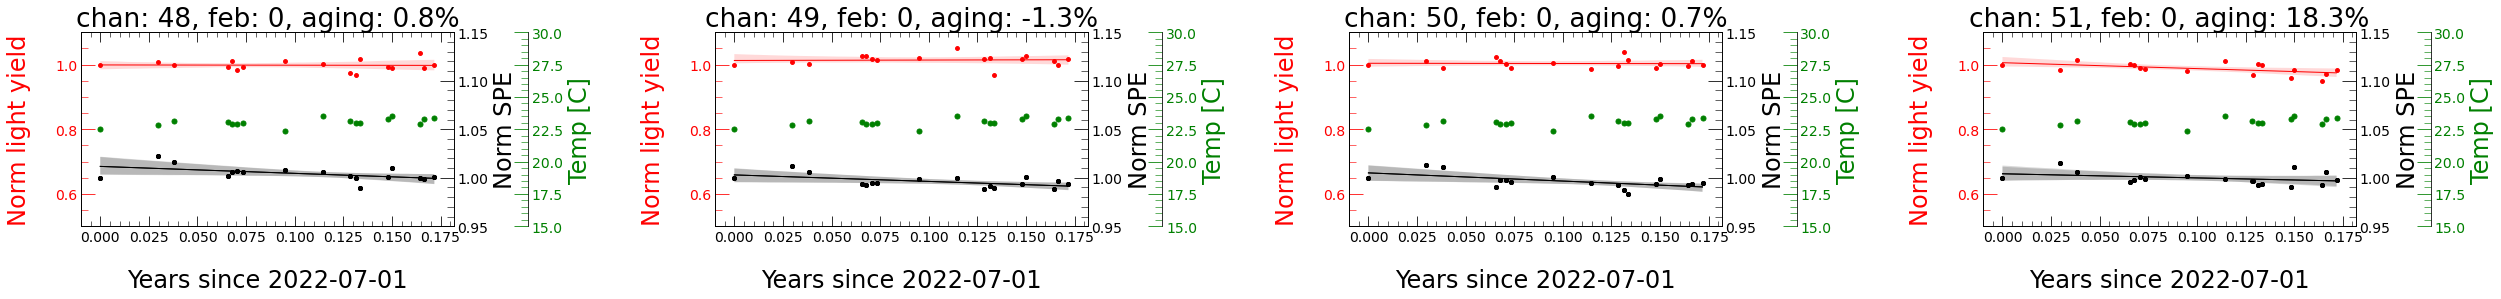

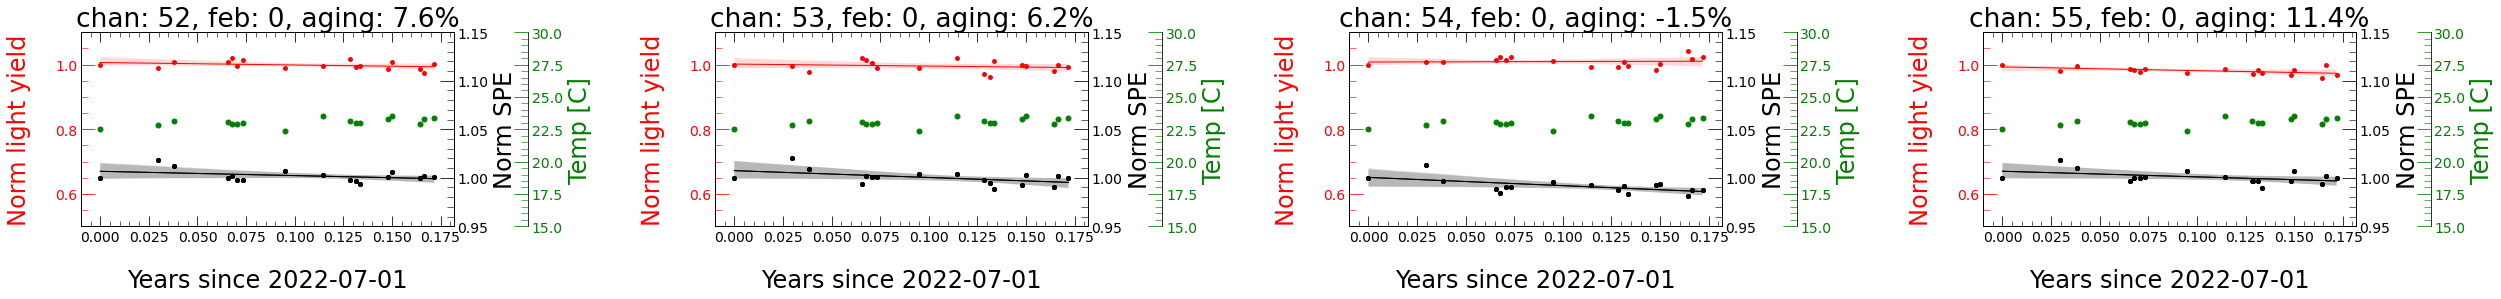

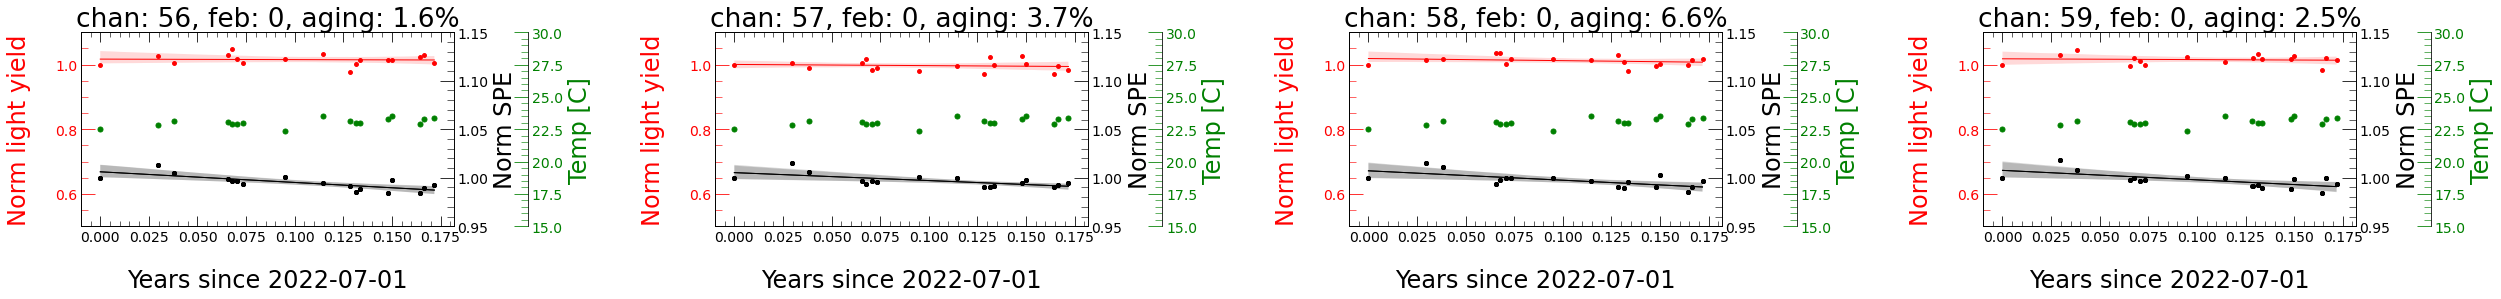

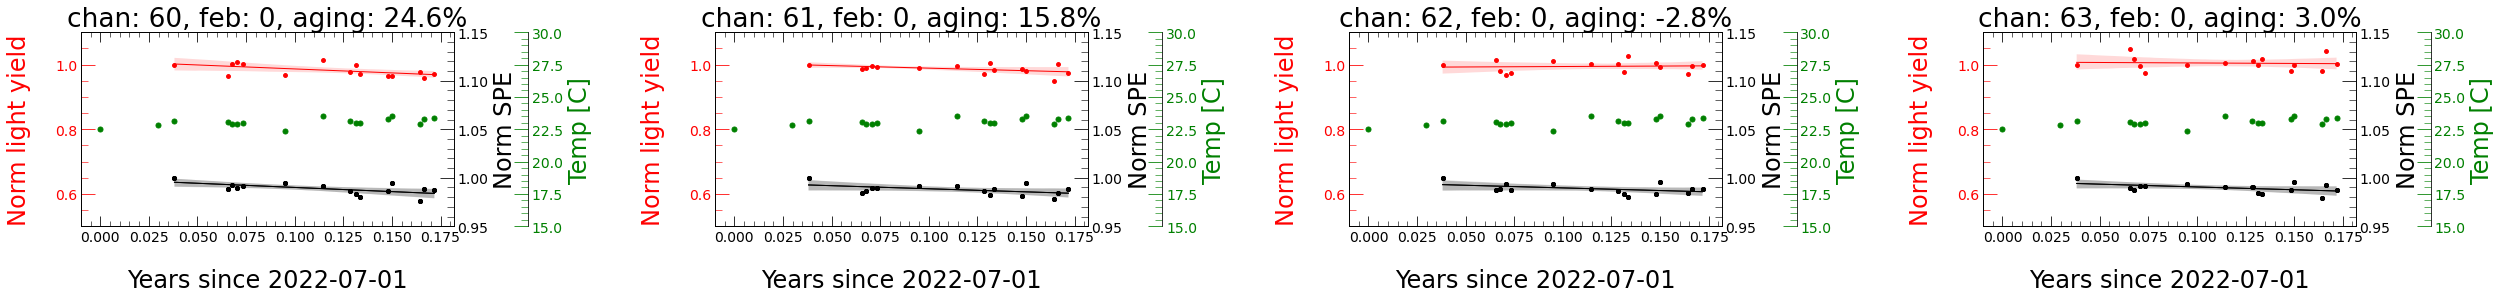

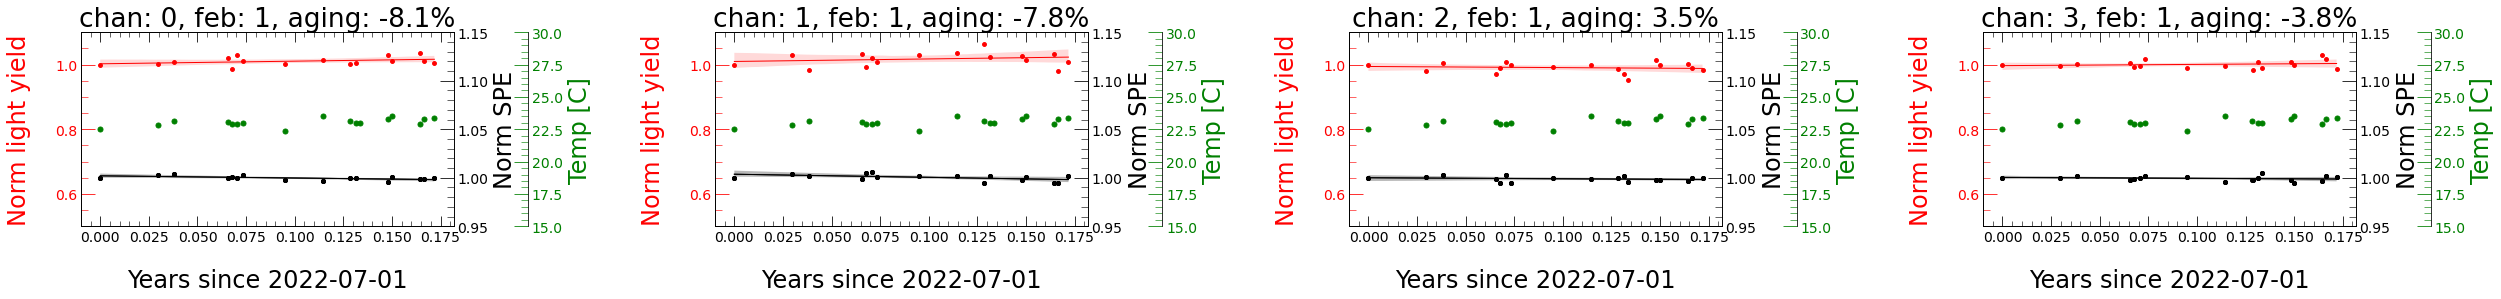

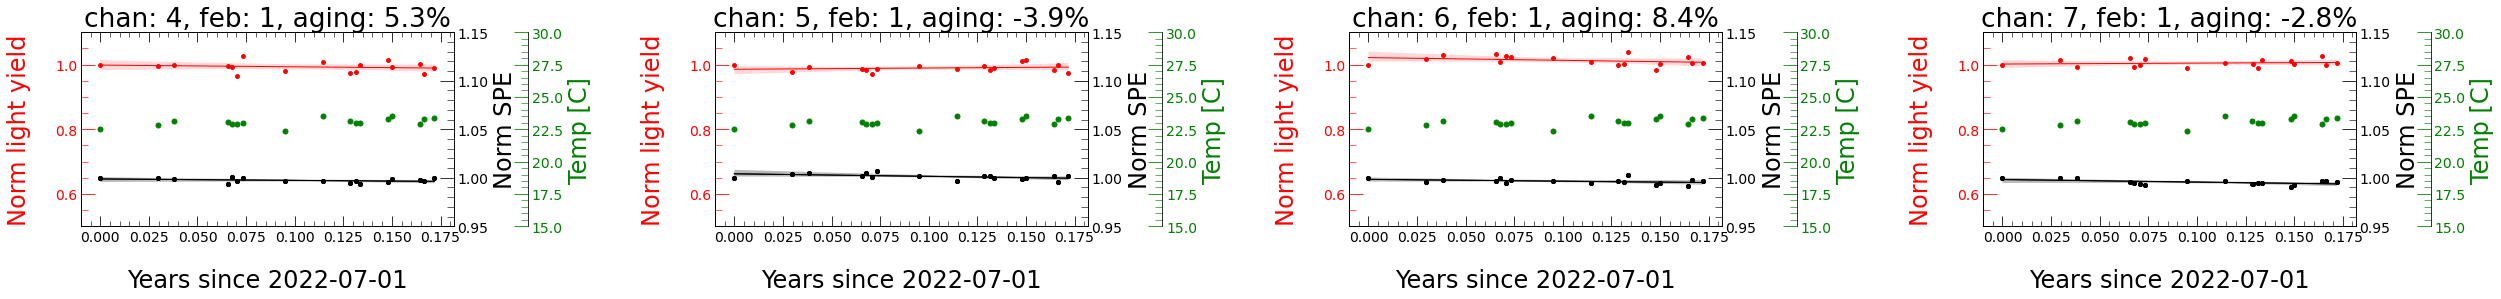

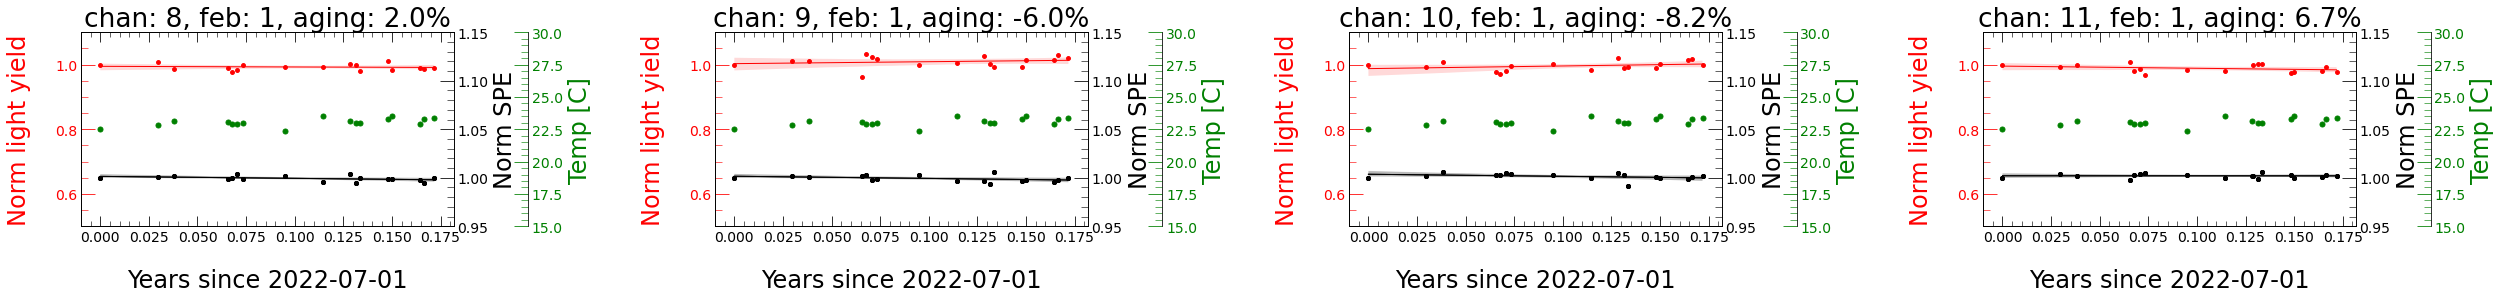

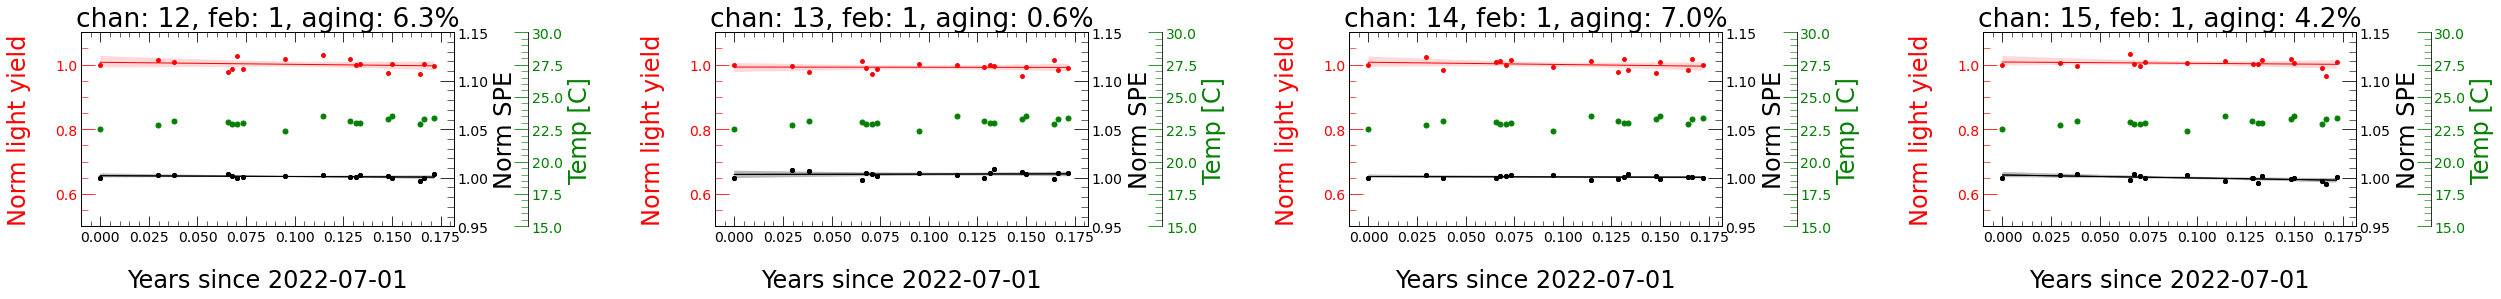

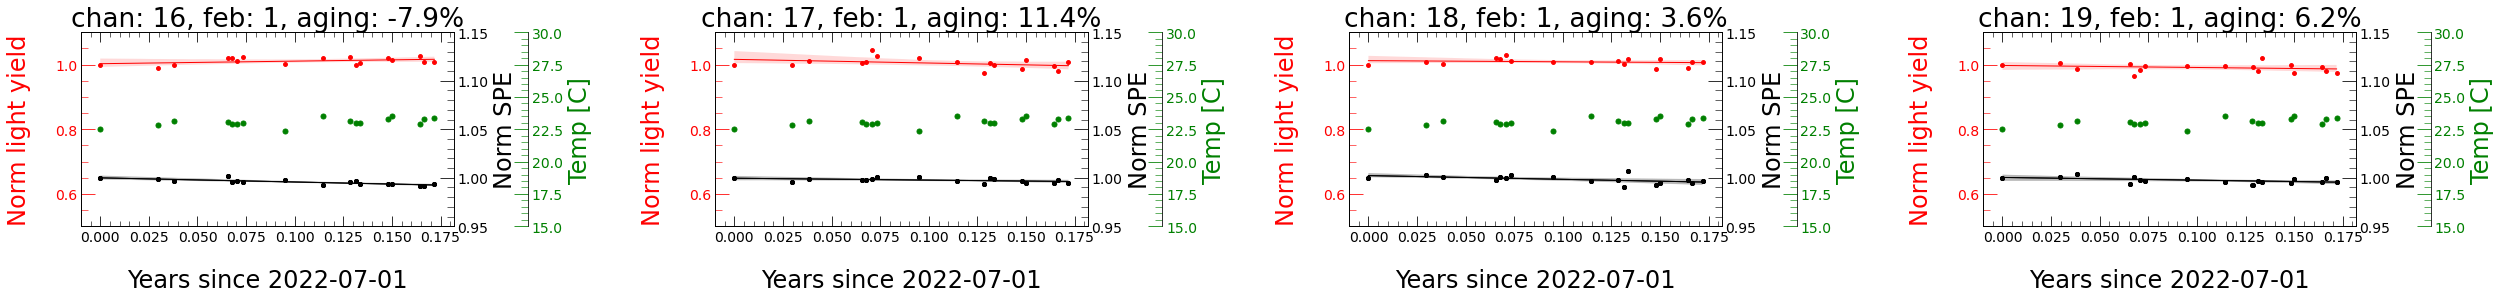

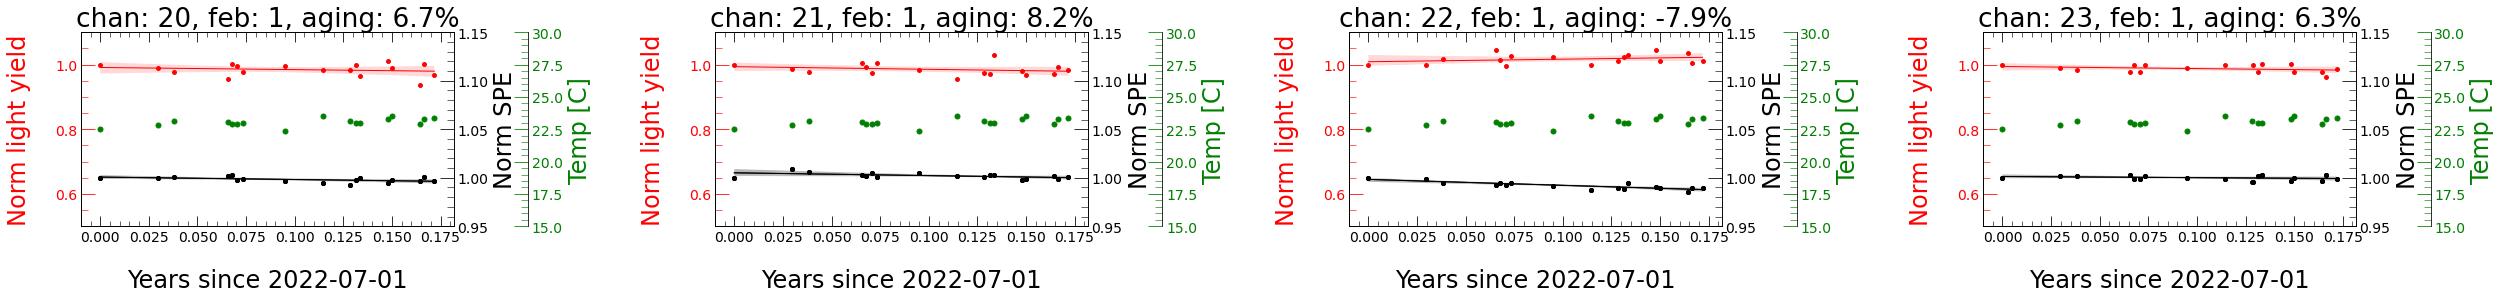

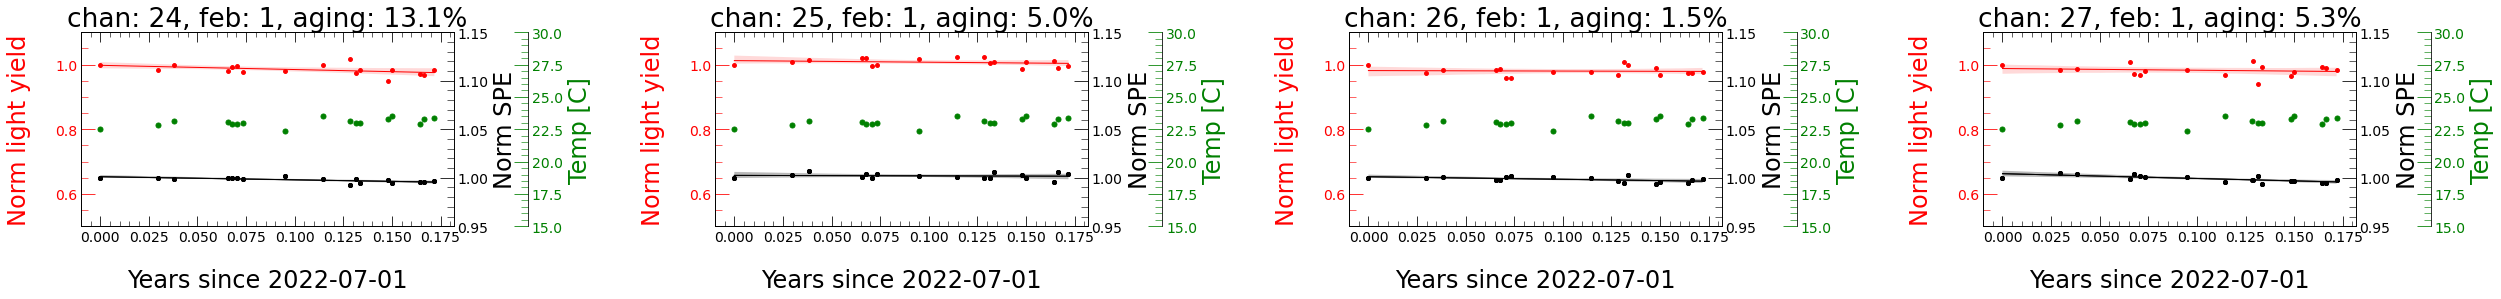

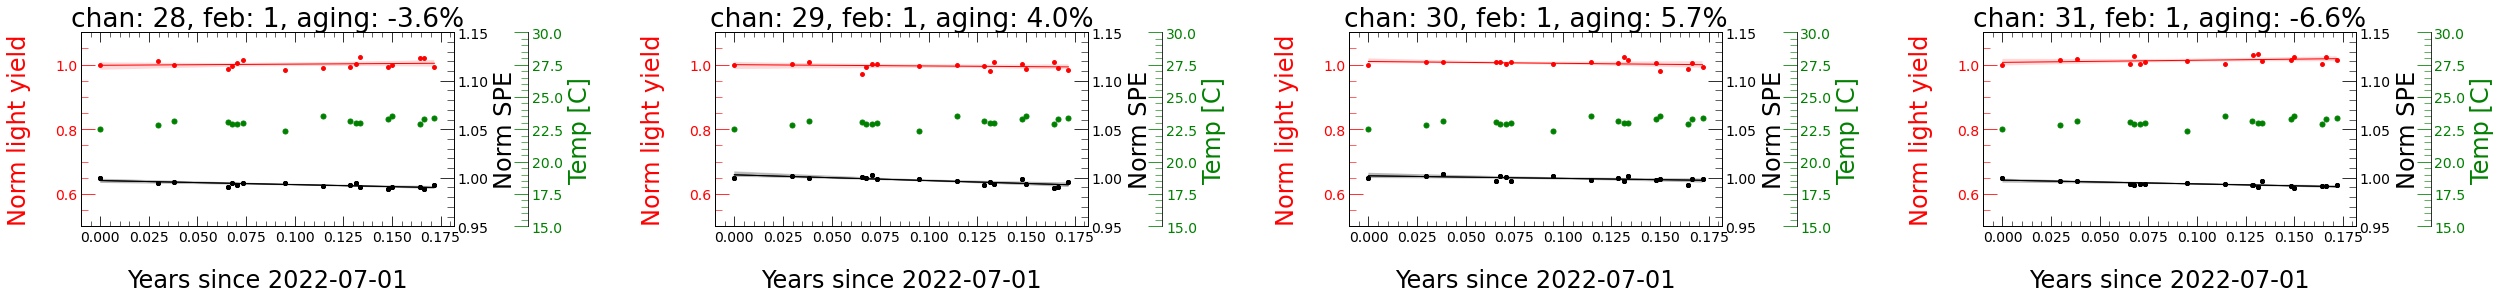

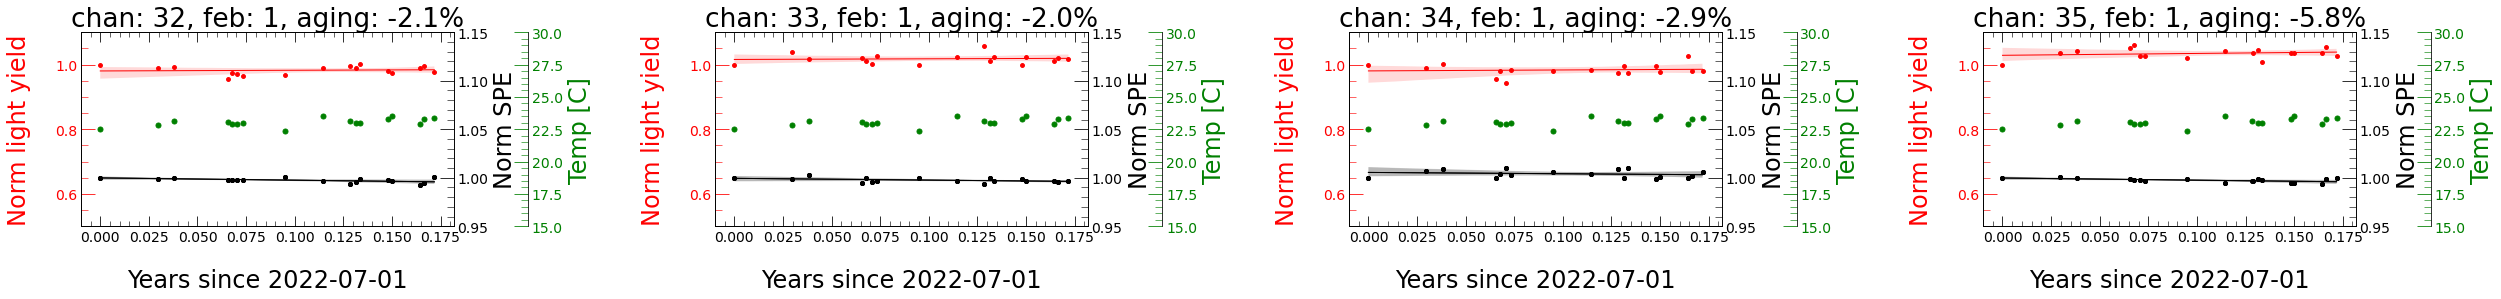

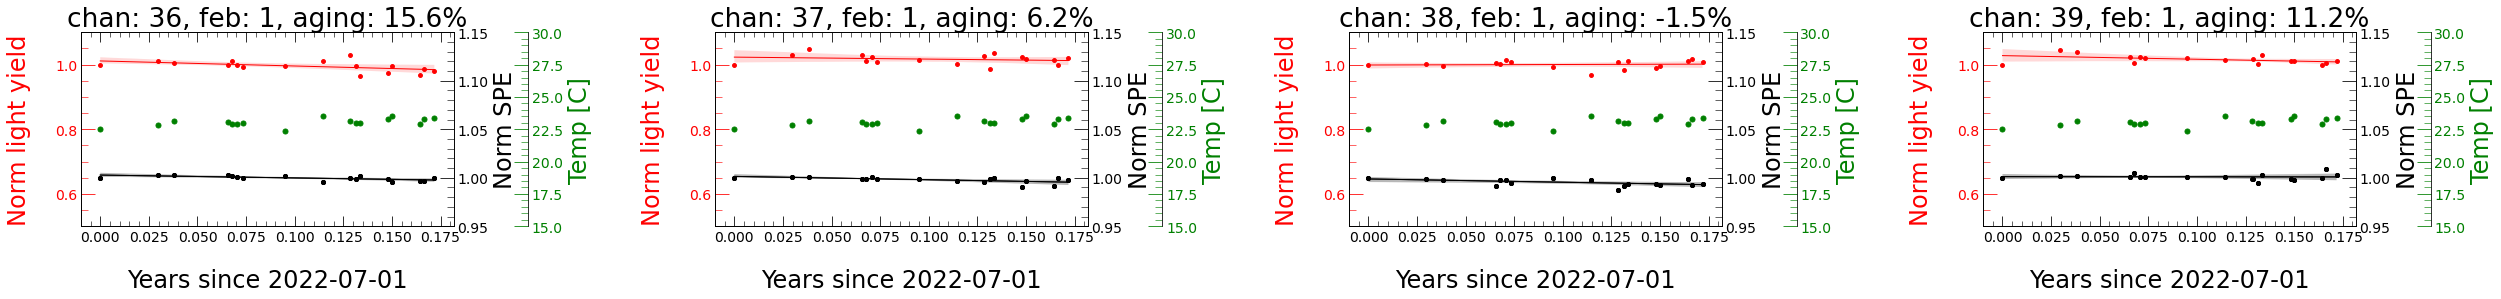

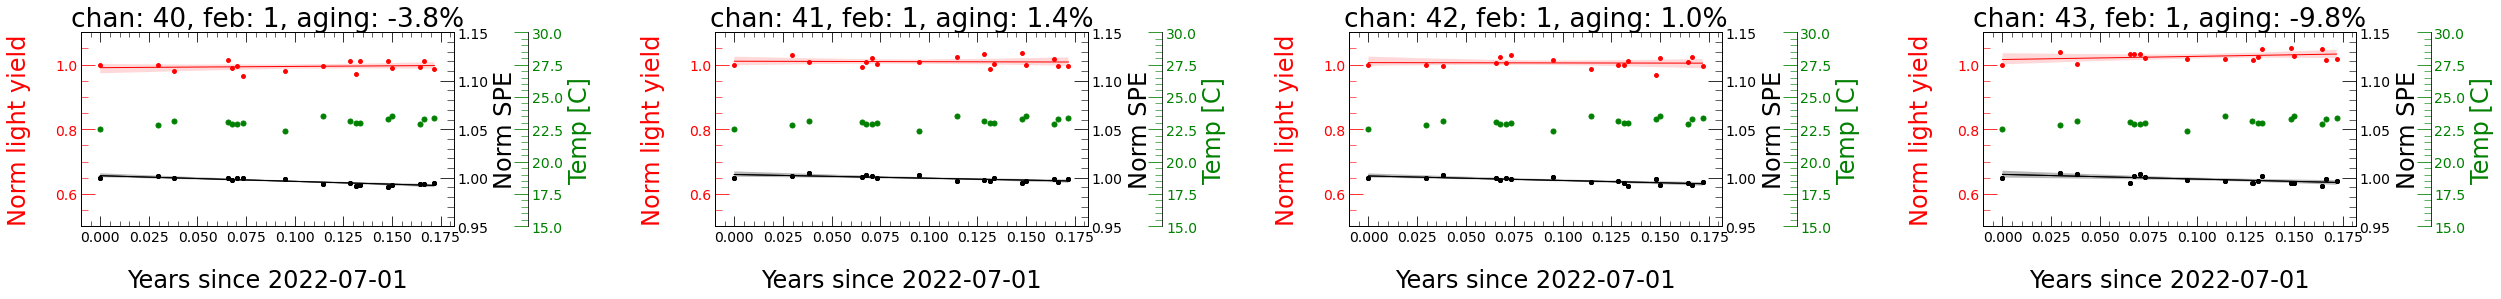

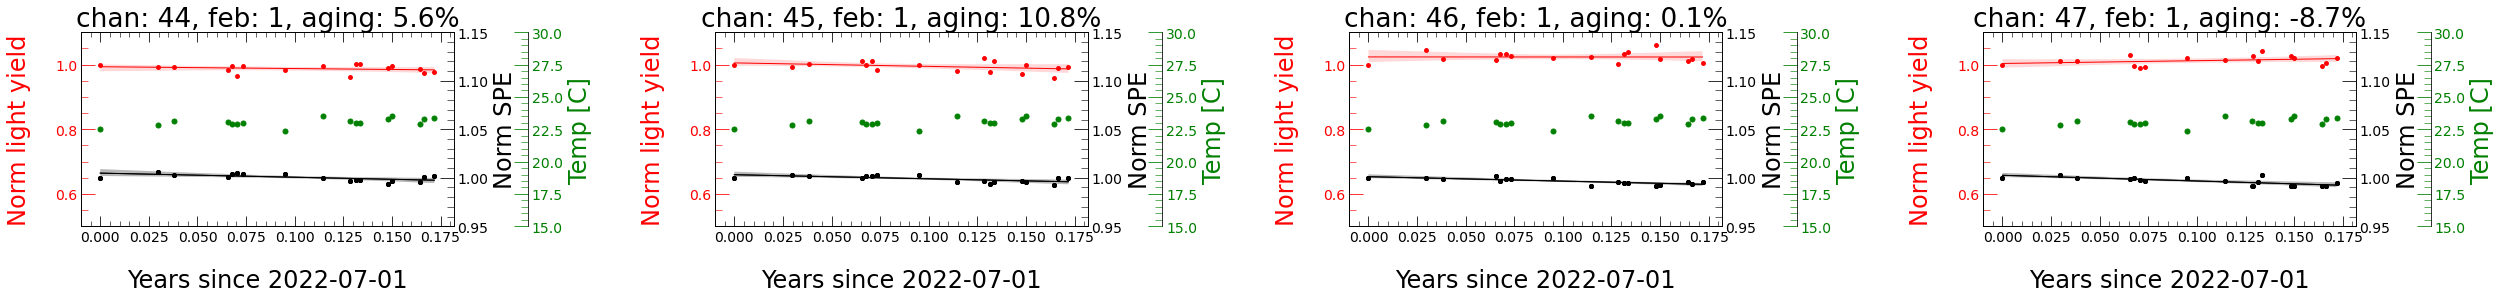

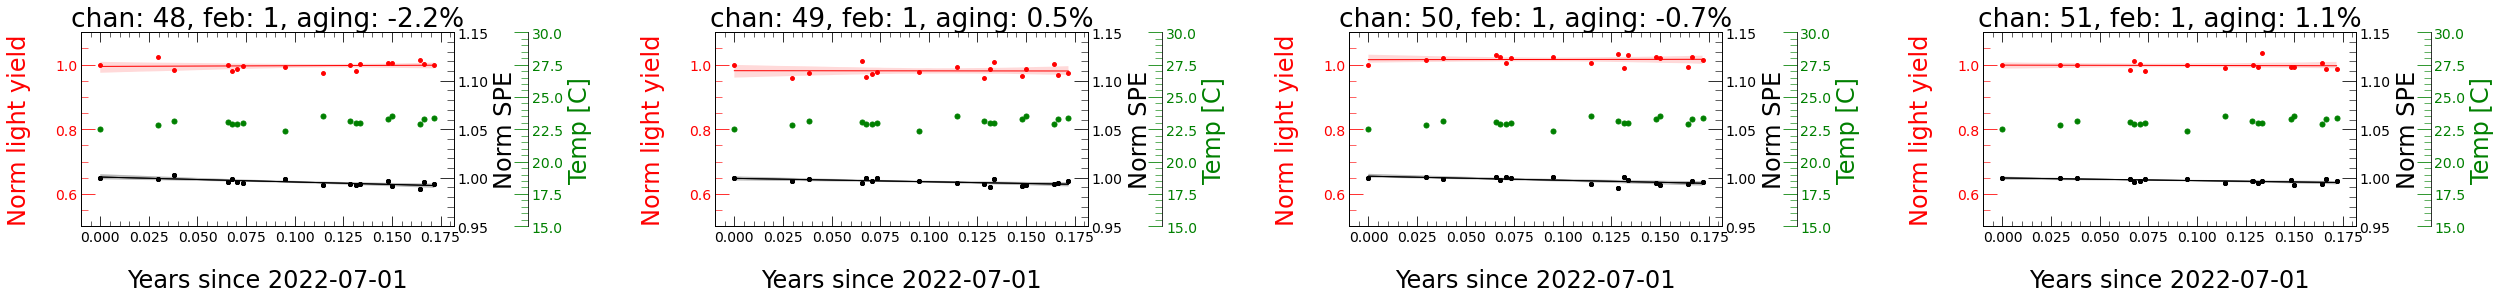

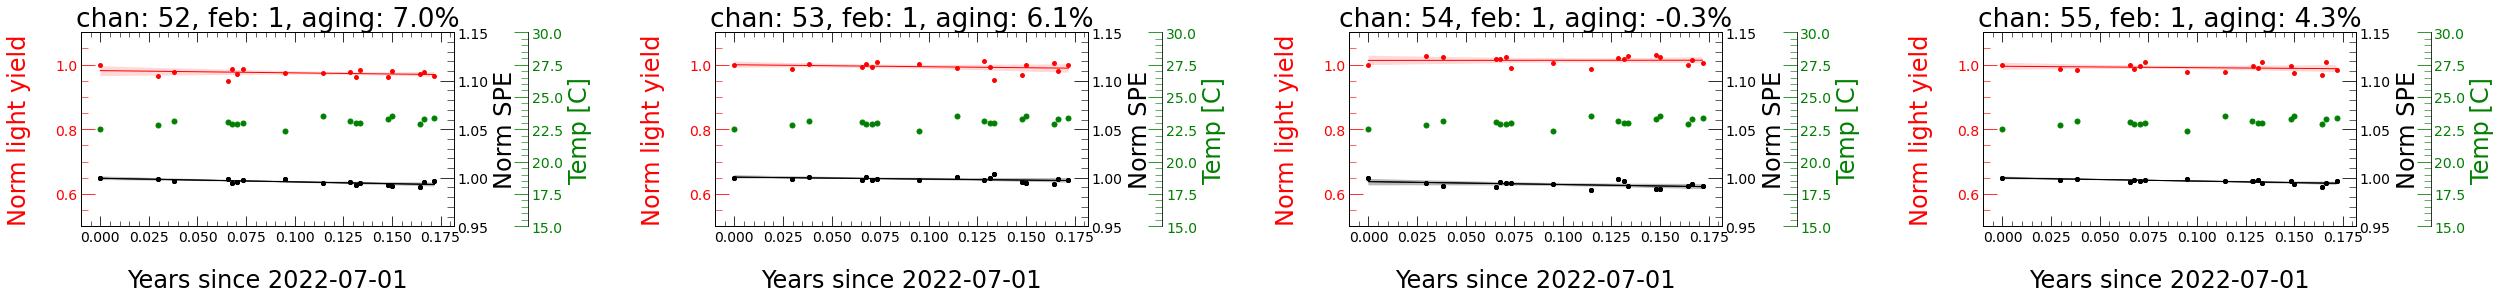

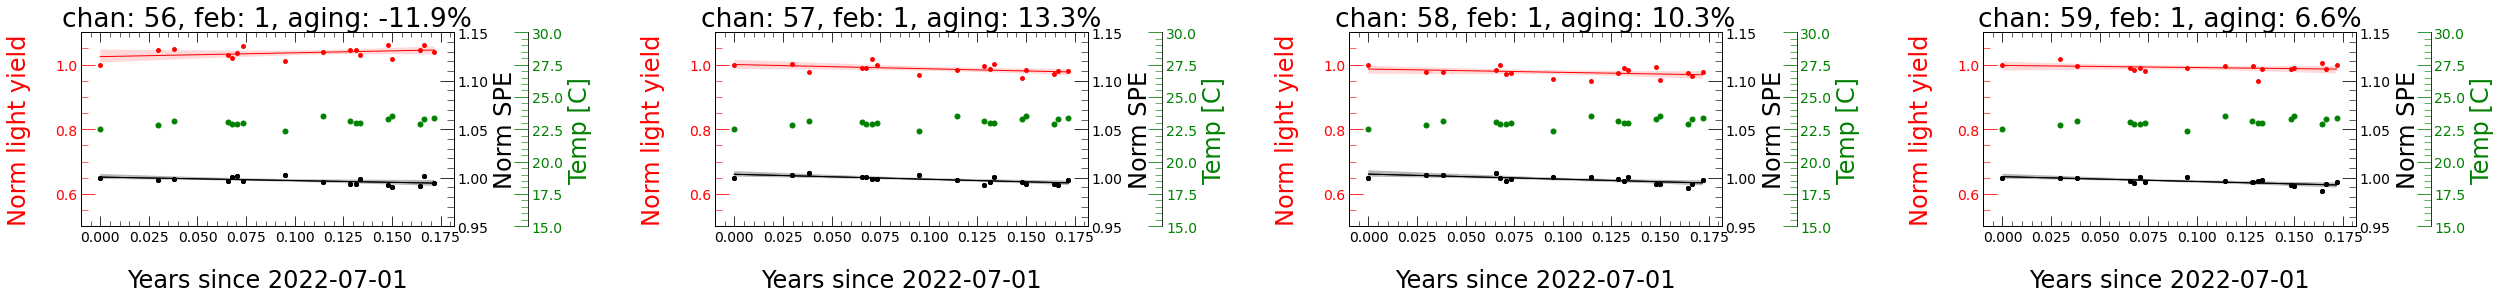

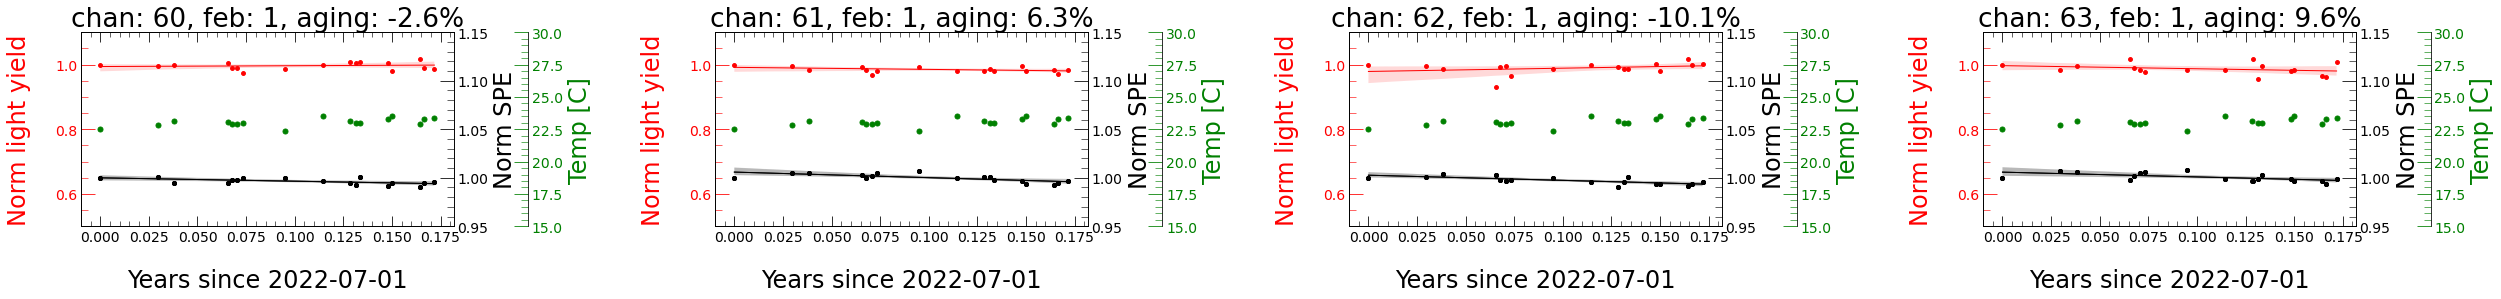

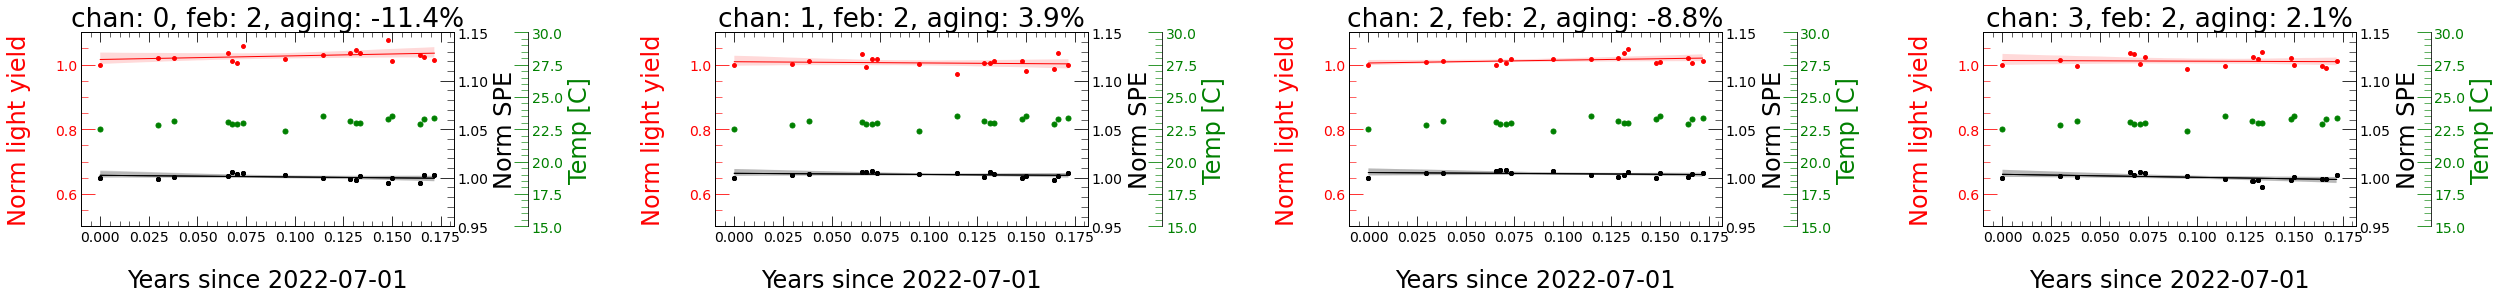

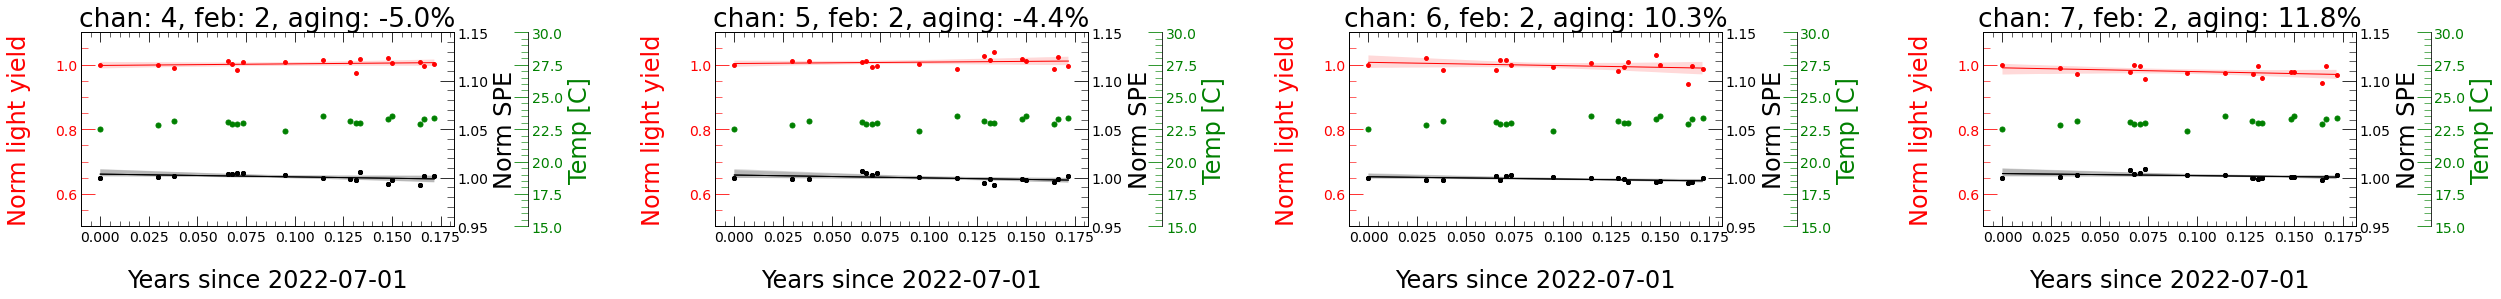

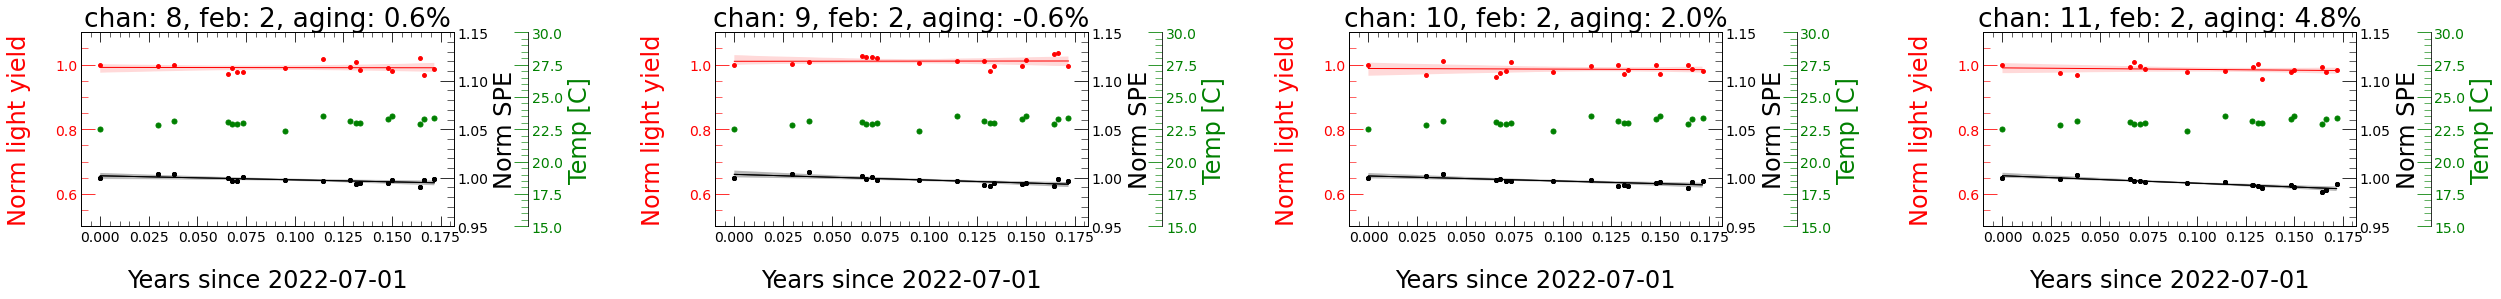

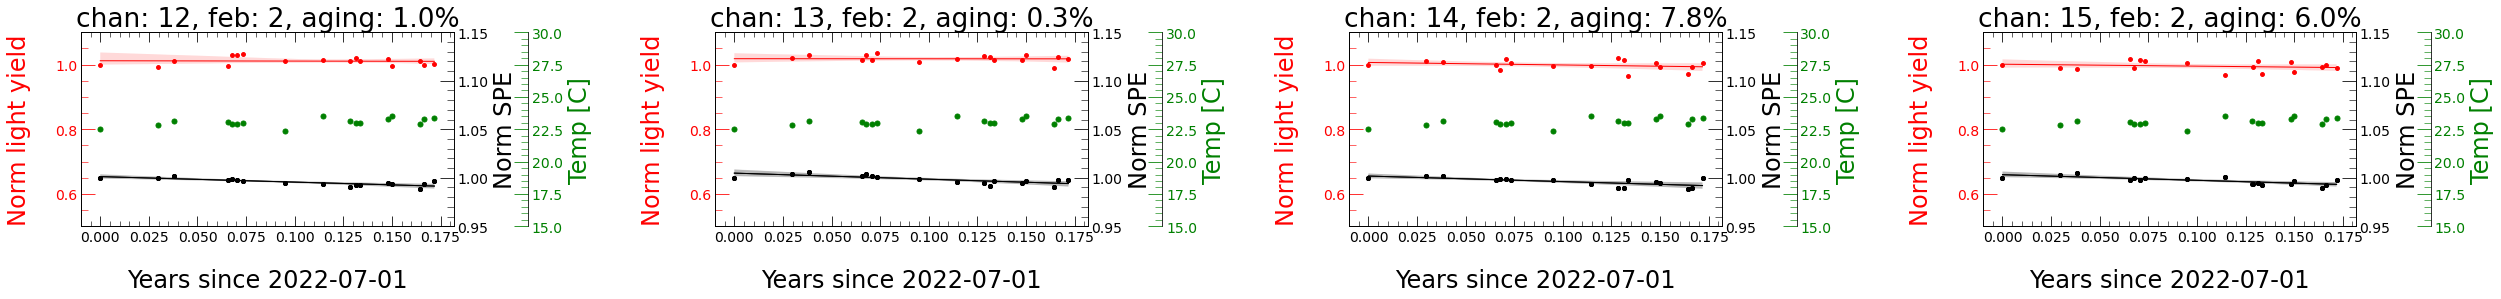

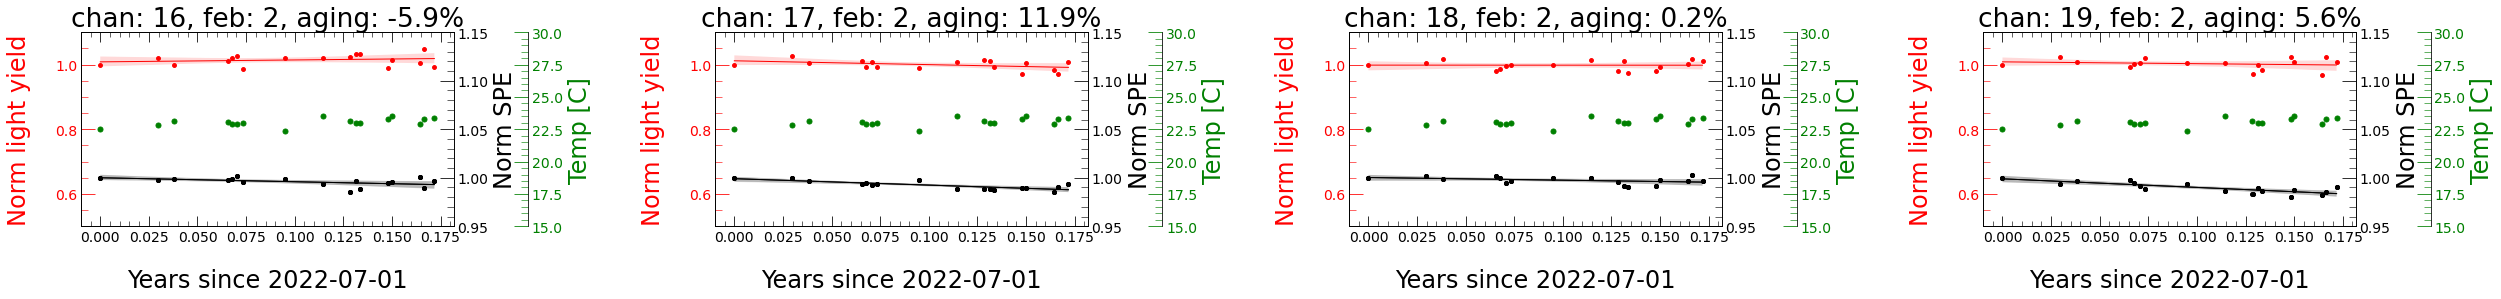

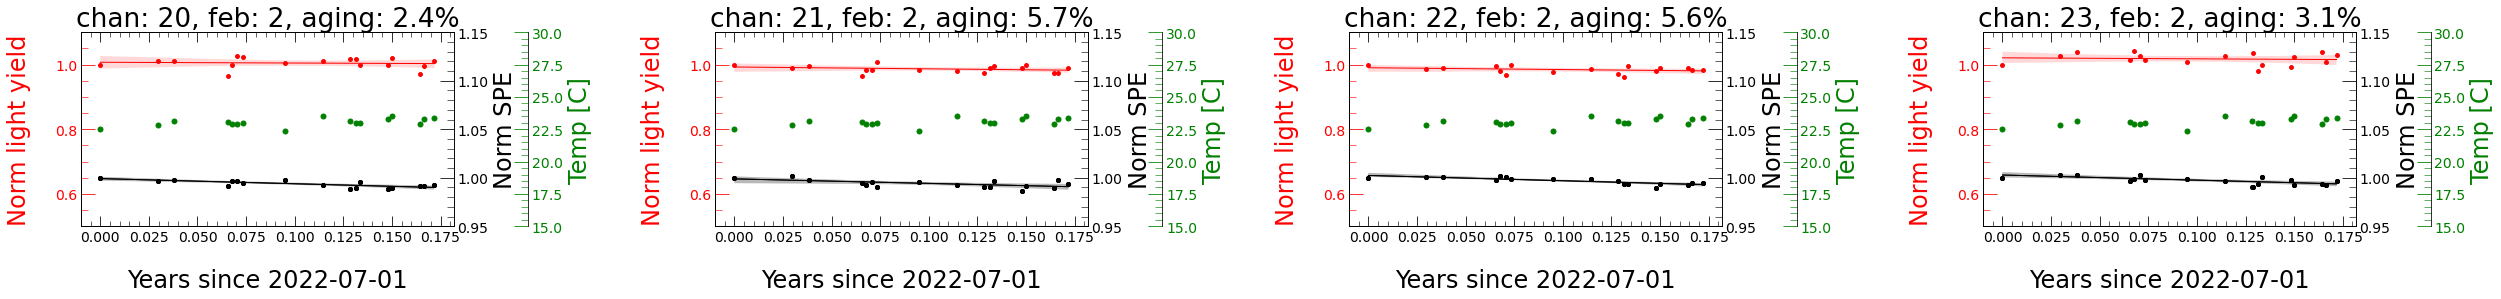

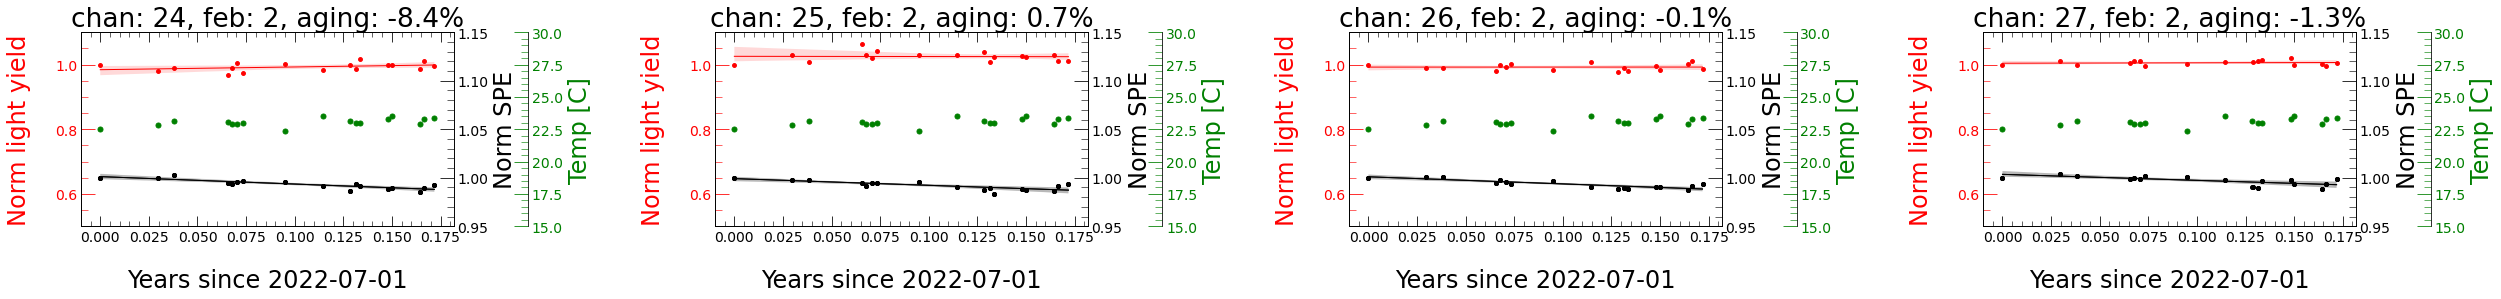

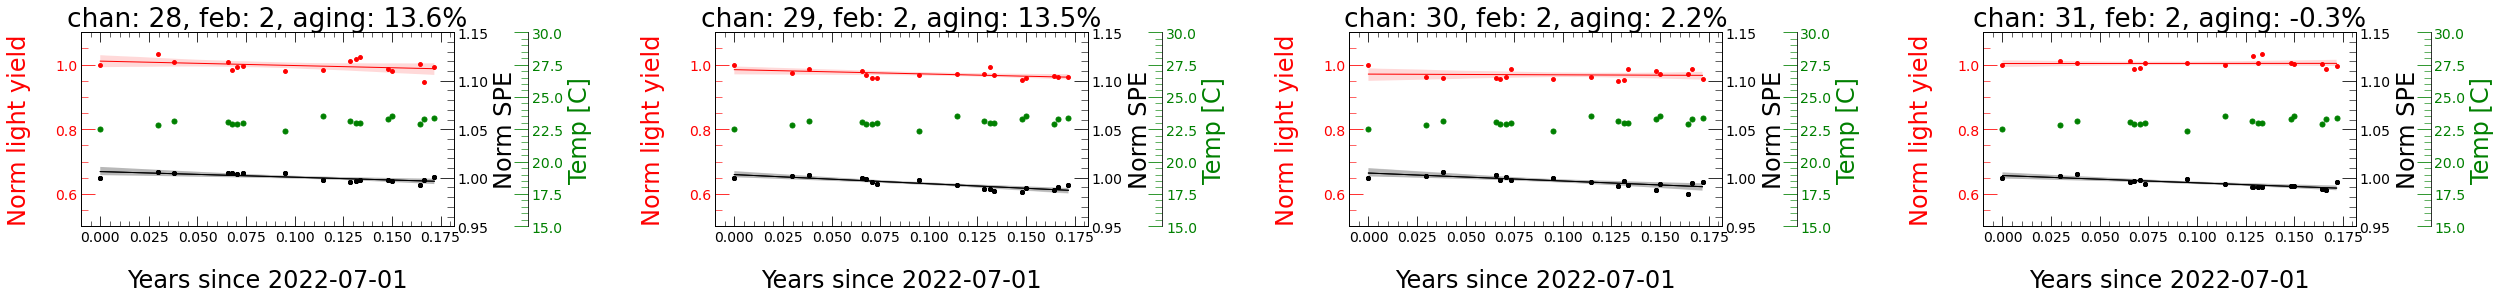

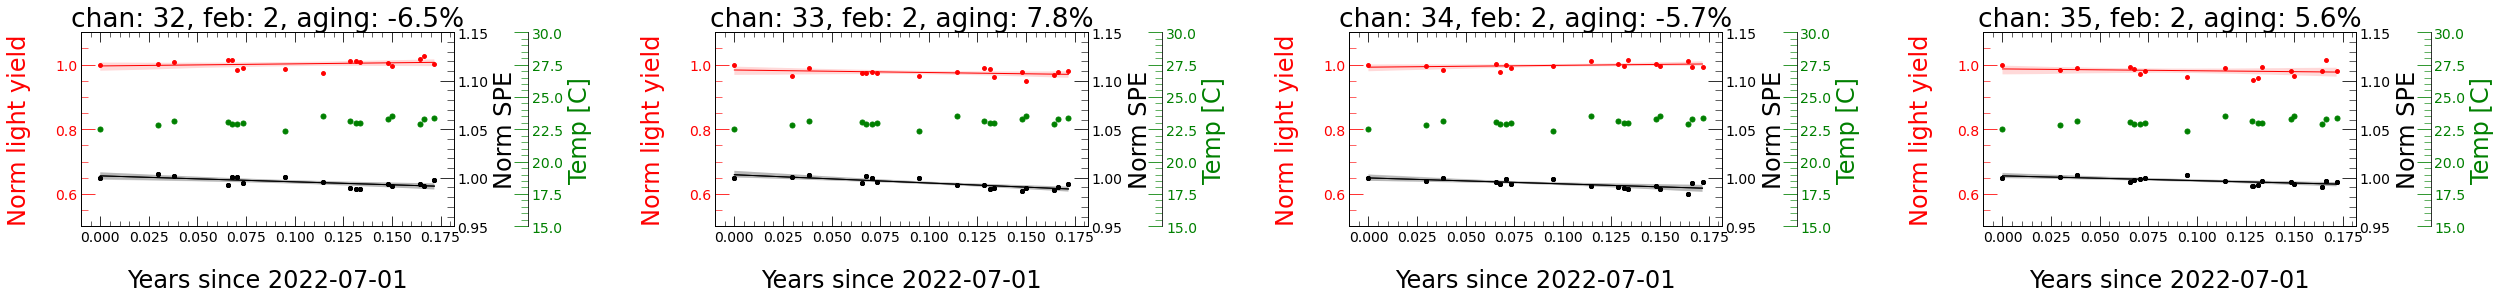

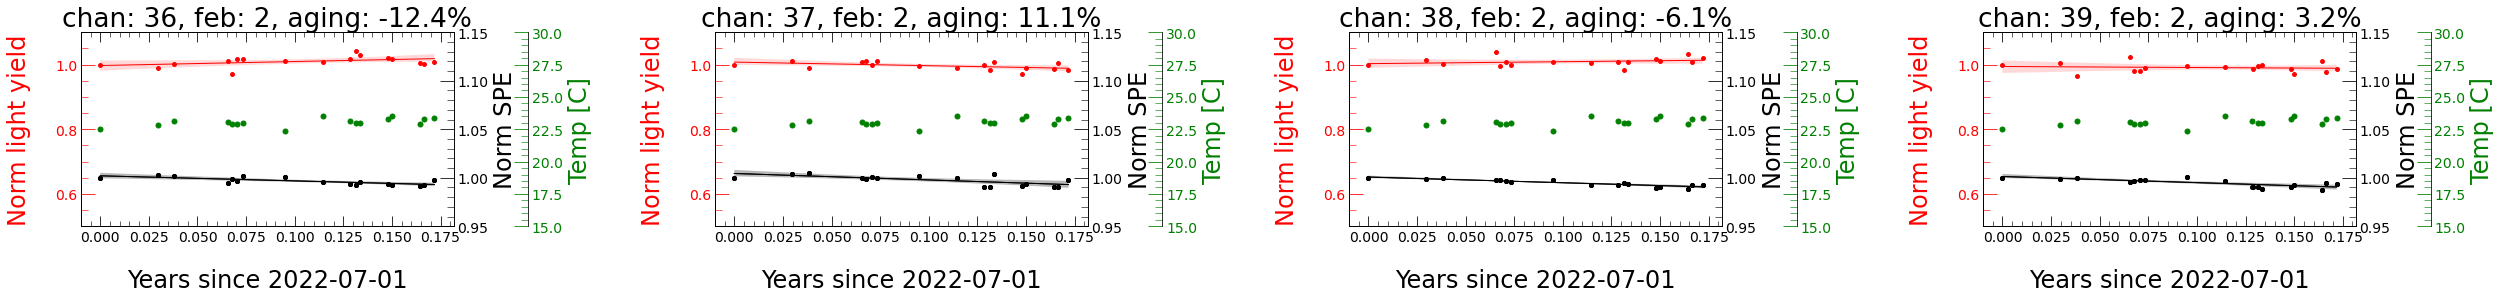

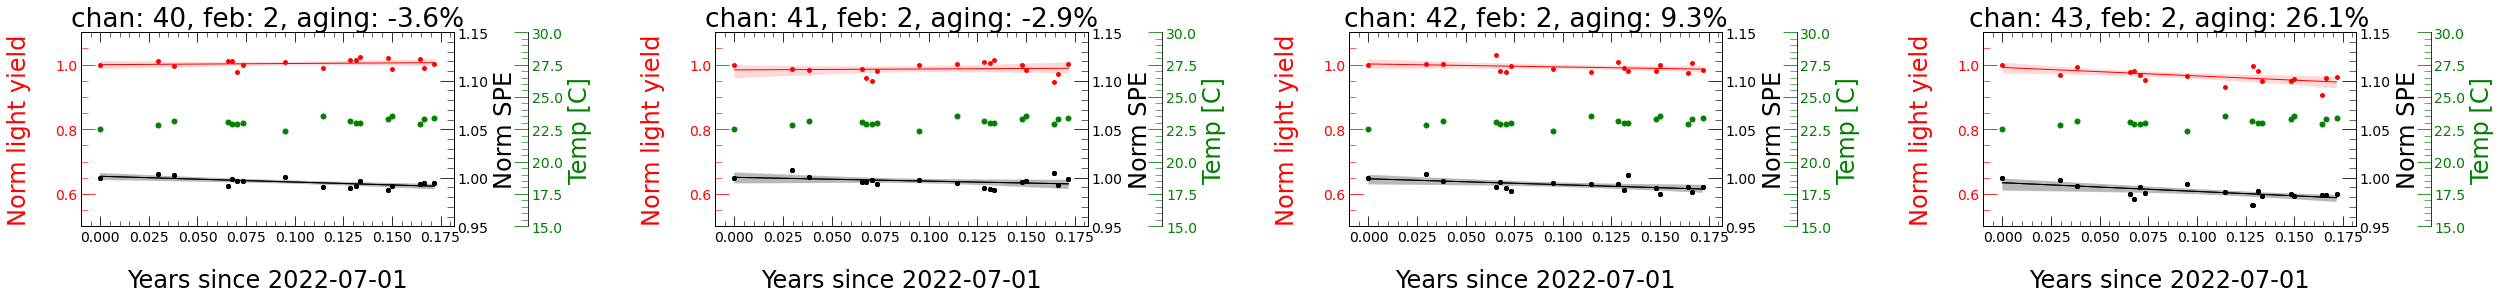

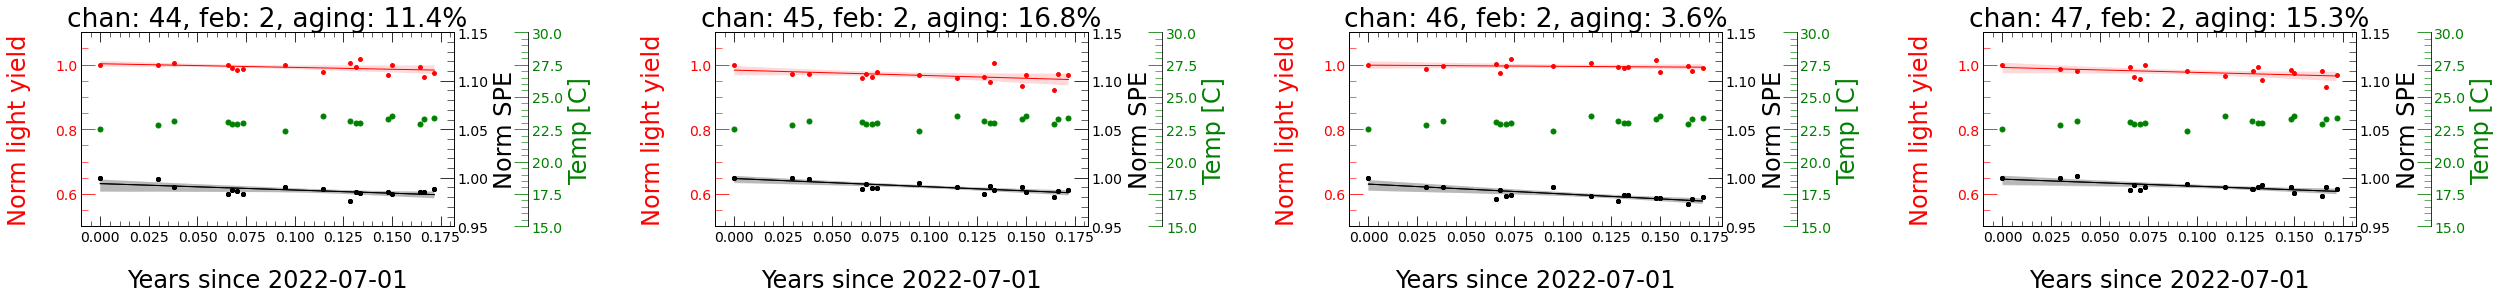

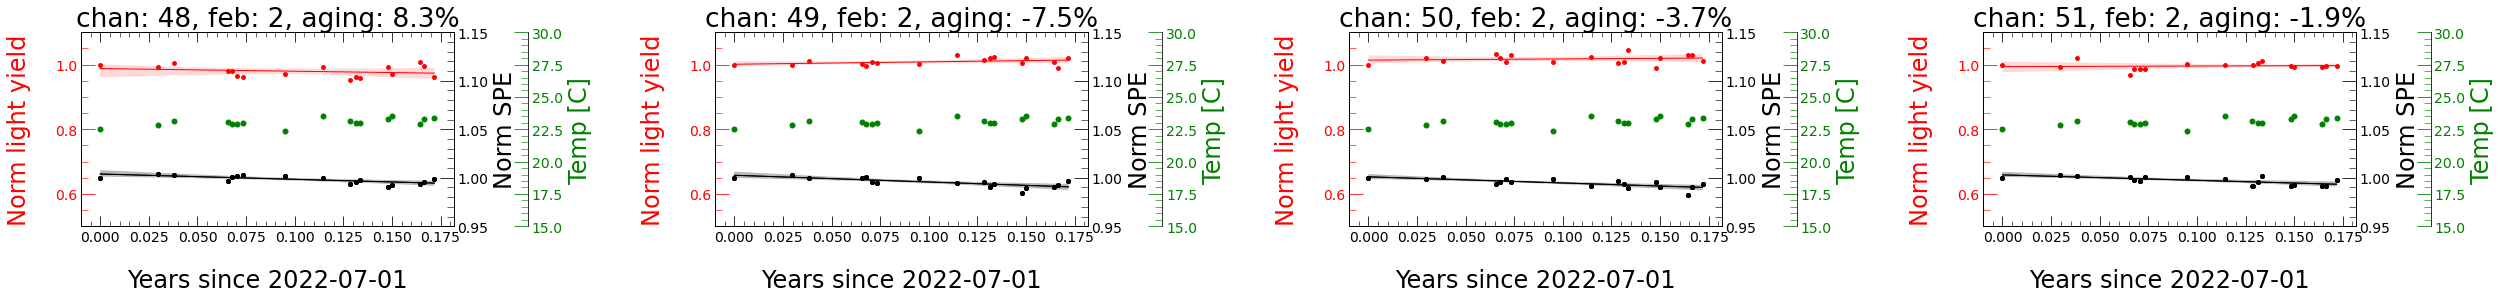

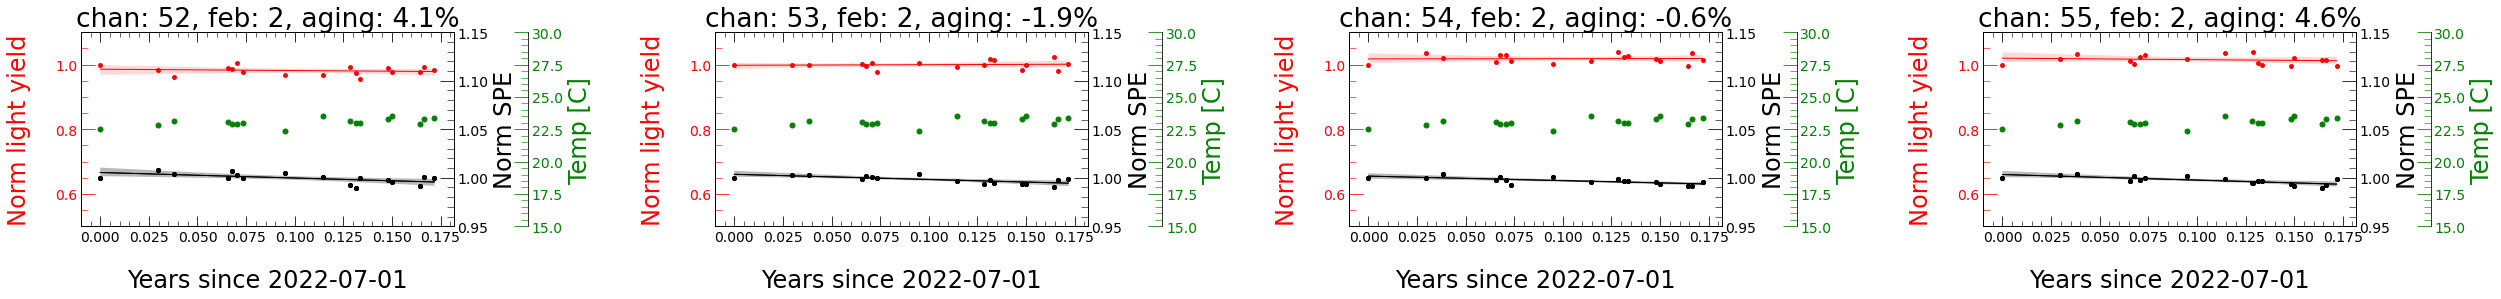

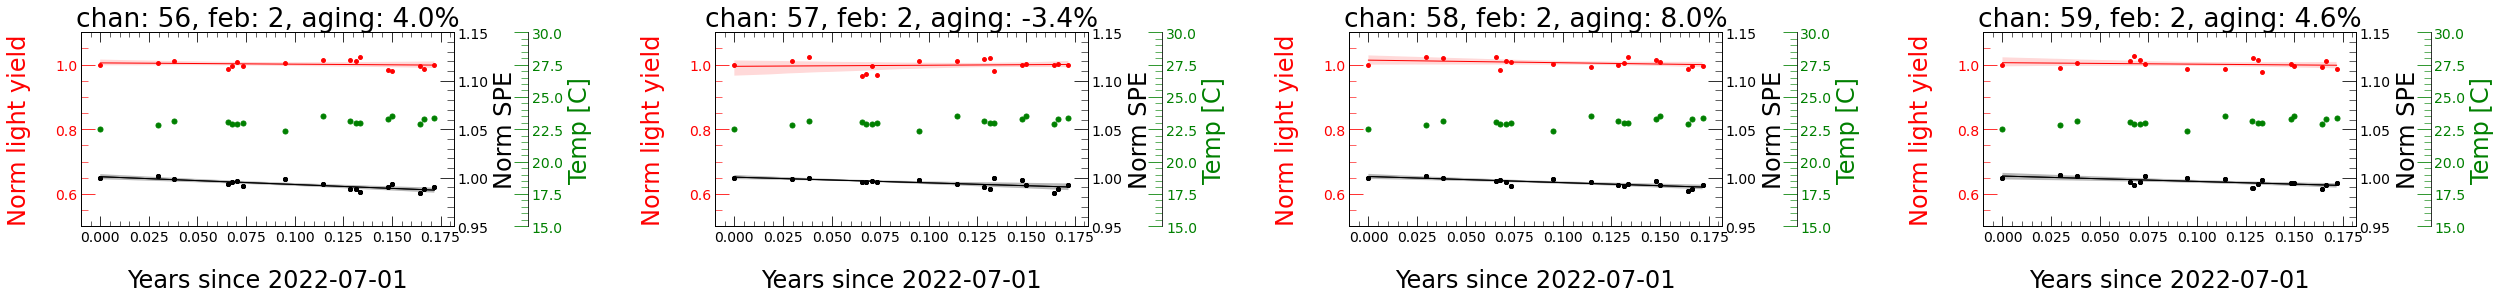

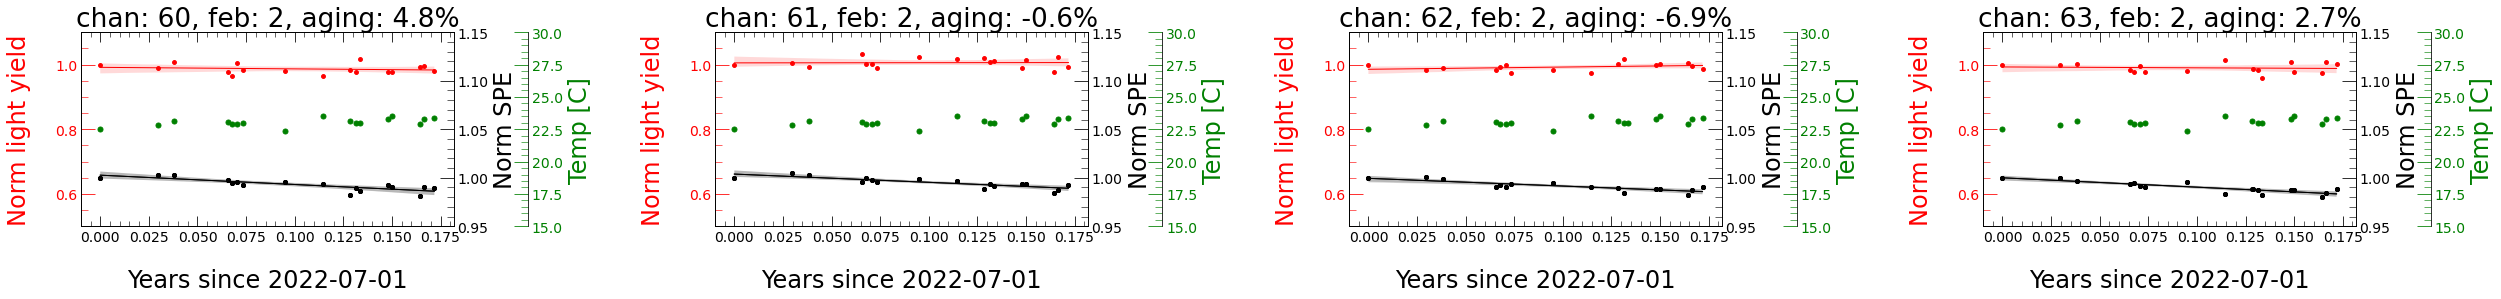

In [11]:
aging_pct=[]
#hdmi_range=list(range(0, 6))+list(range(8, 14))
hdmi_range=list(range(0, 16))
t0=str(df['date'].to_numpy()[0])

for feb in range(0, 3):
  for hdmi in hdmi_range:
    fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(40, 3.5))
    plt.subplots_adjust(wspace=0.7)

    for chan in range(0, 4):
      ax2 = ax1[chan].twinx()
      ax3 = ax1[chan].twinx()
      ax3.spines['right'].set_position(("axes", 1.2))

      #Plot normalized PE over years
      chan_infeb = hdmi*4+chan
      x=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['years'].to_numpy()
      y=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['PEsTemperatureCorrected_%d_%d'%(feb, chan_infeb)].to_numpy()
      y=y/y[0]

      #Fit the aging curve
      sns.regplot(x=x, y=y, x_bins=np.linspace(-0.1,x.max()+0.1,10000), fit_reg=True, label='Fit', ax=ax1[chan], color='red', marker='o', scatter_kws={'s':15}, line_kws={'linewidth':1})
      slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
      ax1[chan].set_title('chan: %d, feb: %d, aging: %.1f%%'%(hdmi*4+chan,feb,-slope*100))
      ax1[chan].set_ylim(0.5,1.1)
      ax1[chan].set_xlim(-0.01, x.max()+0.01)
      ax1[chan].set_xlabel("Years since %s"%t0)
      ax1[chan].set_ylabel('Norm light yield', color='r')
      ax1[chan].tick_params(axis='y', which='both', colors='r')

      #Plot temp corr SPE over time
      y=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['calibConstantsTemperatureCorrected_%d_%d'%(feb, chan_infeb)].to_numpy()
      y=y/y[0]
      sns.regplot(x=x, y=y, x_bins=np.linspace(-0.1,x.max()+0.1,10000), fit_reg=True, label='Fit', ax=ax2, color='black', marker='o', scatter_kws={'s':15}, line_kws={'linewidth':1})
      ax2.plot(x, y , 'k.')
      sns.regplot(x=x, y=y, x_bins=np.linspace(-0.1,x.max()+0.1,10000), fit_reg=True, label='Fit', ax=ax2, color='black', marker='o', scatter_kws={'s':15}, line_kws={'linewidth':1})
      ax2.set_ylim(0.95,1.15)
      ax2.set_ylabel('Norm SPE', color='k', labelpad=5);

      #Plot temp over time
      ax3.plot(df['years'], df['meanTemperatures_0_0'], 'go', markersize=5.0)
      ax3.set_ylabel('Temp [C]', color='g', labelpad=5)
      ax3.set_ylim(15,30)
      ax3.tick_params(axis='y', which='both', colors='g')

      #Append aging for FEB0 only.
      if(feb>0):
        aging_pct.append(-slope*100)

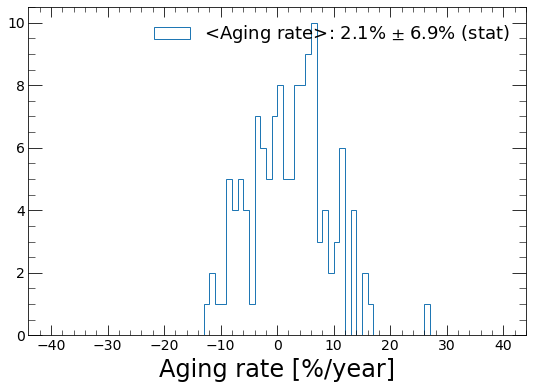

In [12]:
plt.hist(aging_pct, bins=80, range=(-40,40), histtype='step', label='<Aging rate>: %.1f%% $\pm$ %.1f%% (stat)'%(np.mean(aging_pct), np.std(aging_pct)) );
plt.xlabel('Aging rate [%/year]', labelpad=5);
plt.legend();

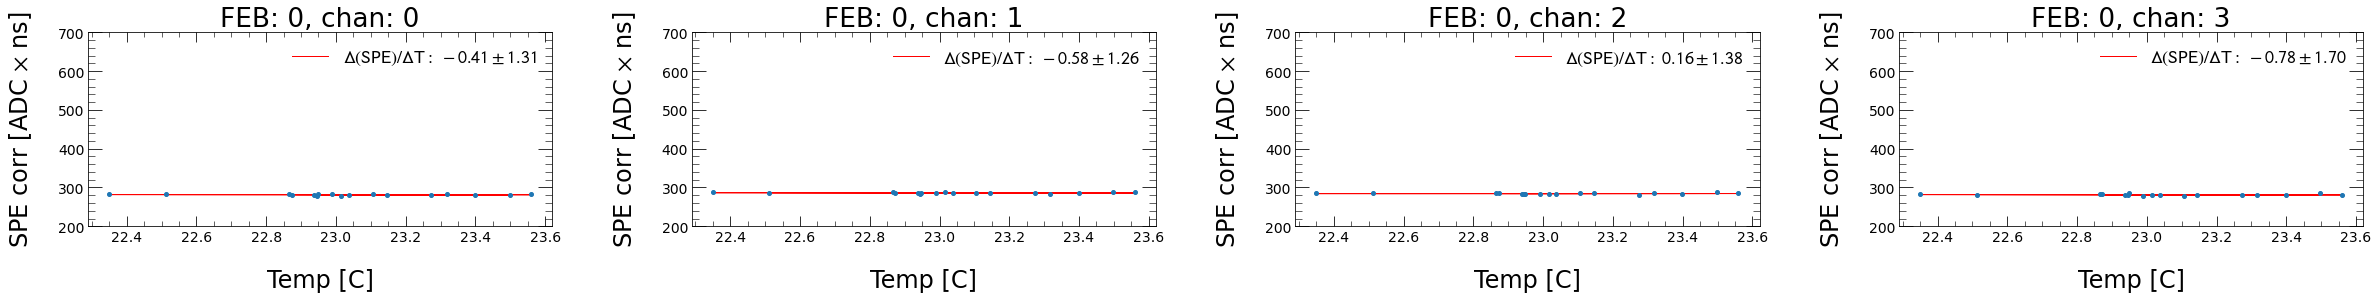

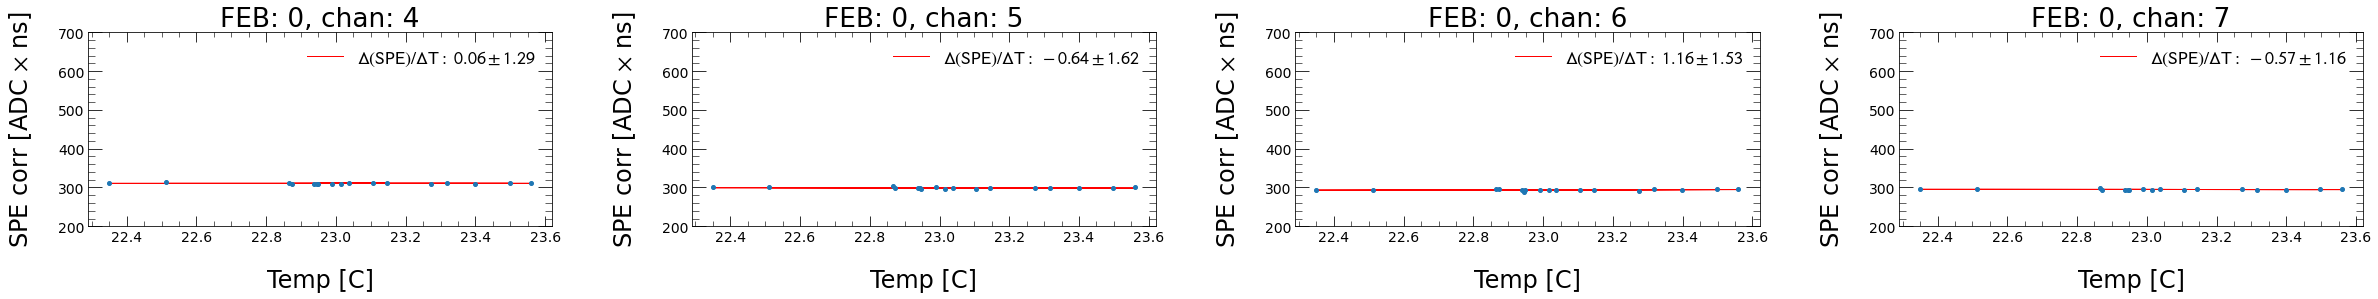

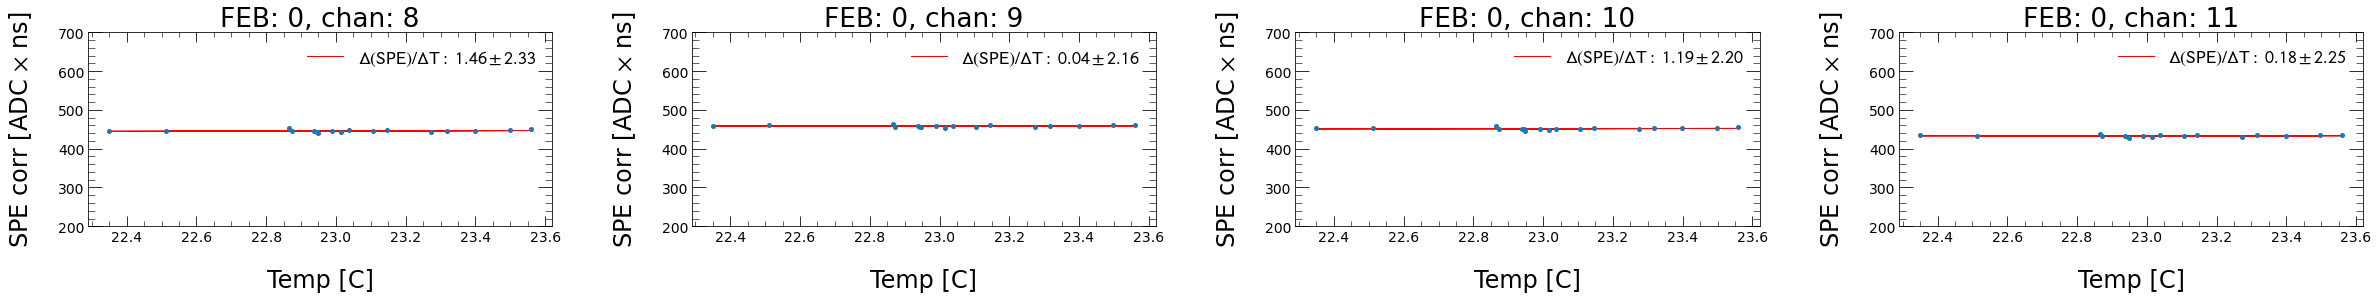

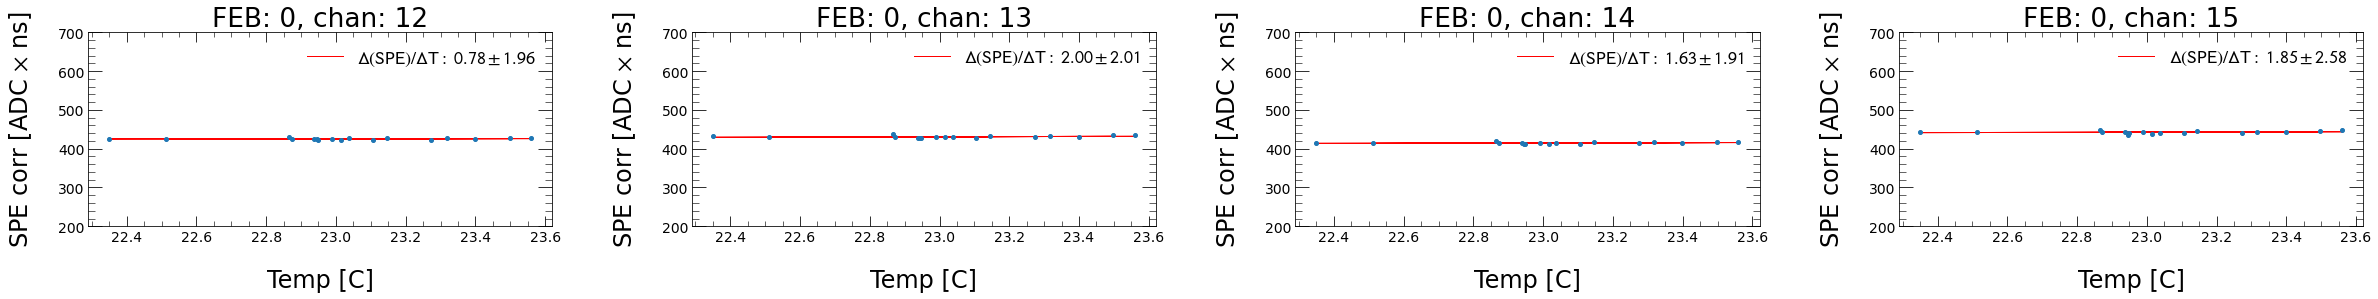

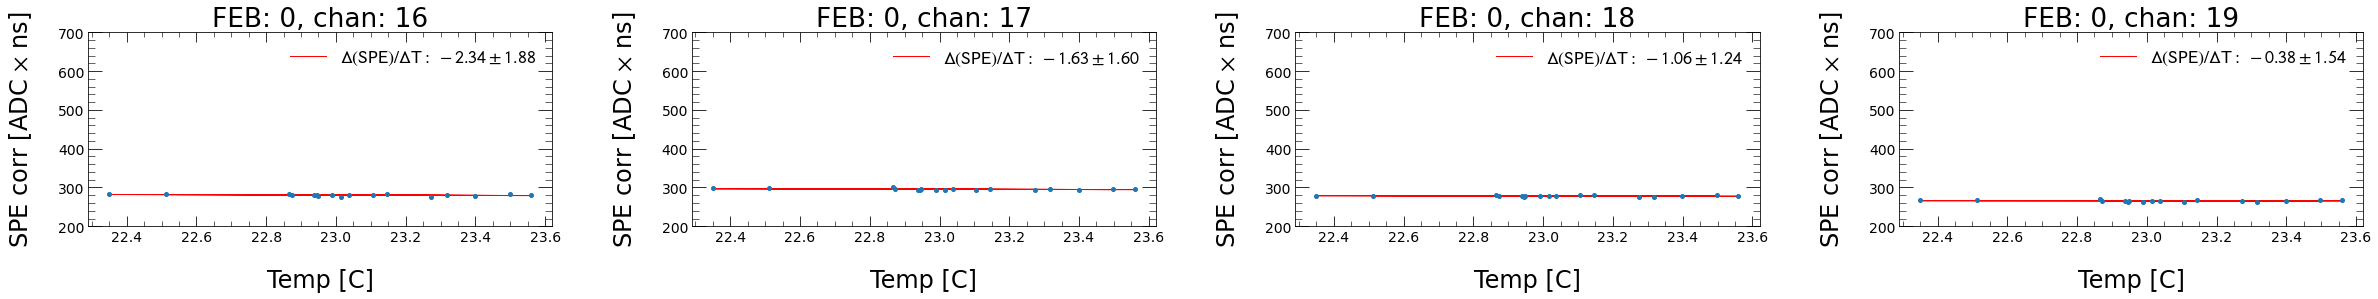

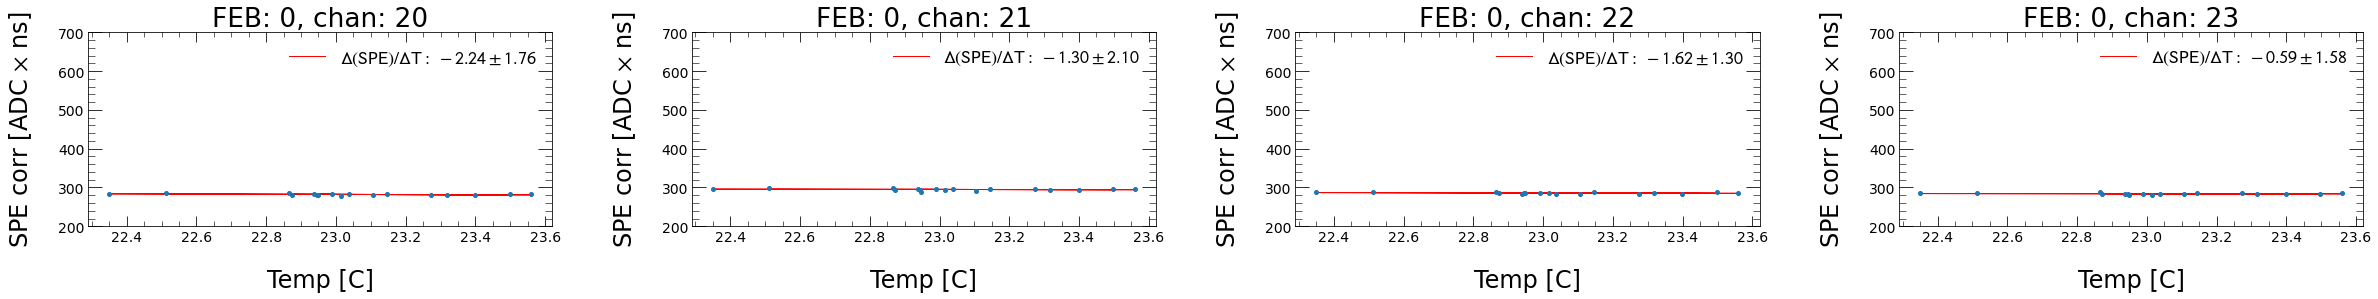

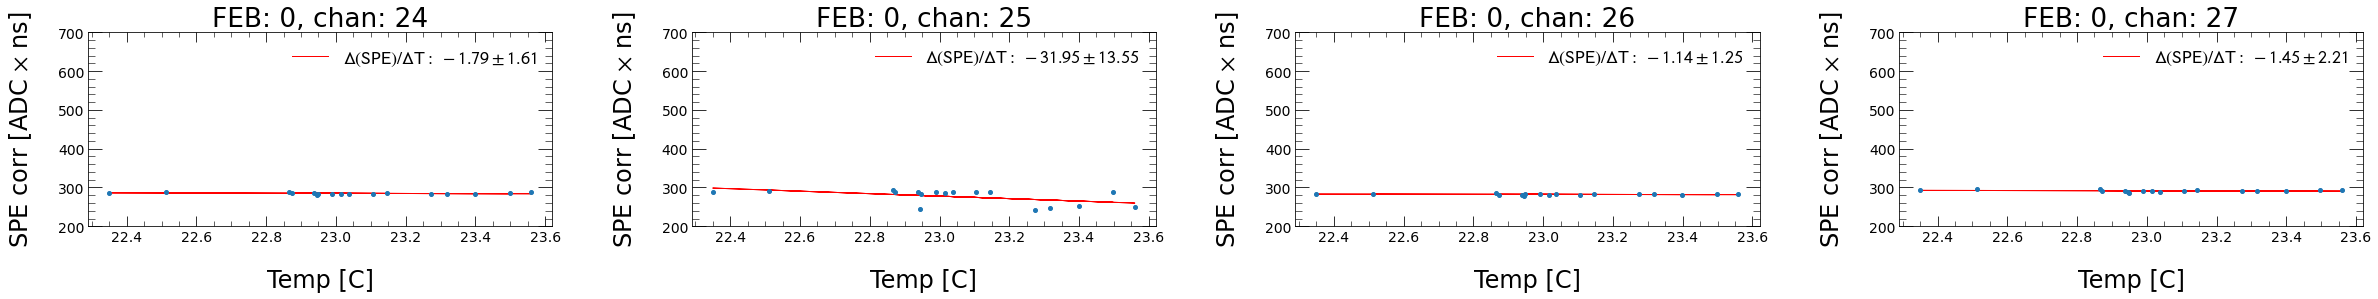

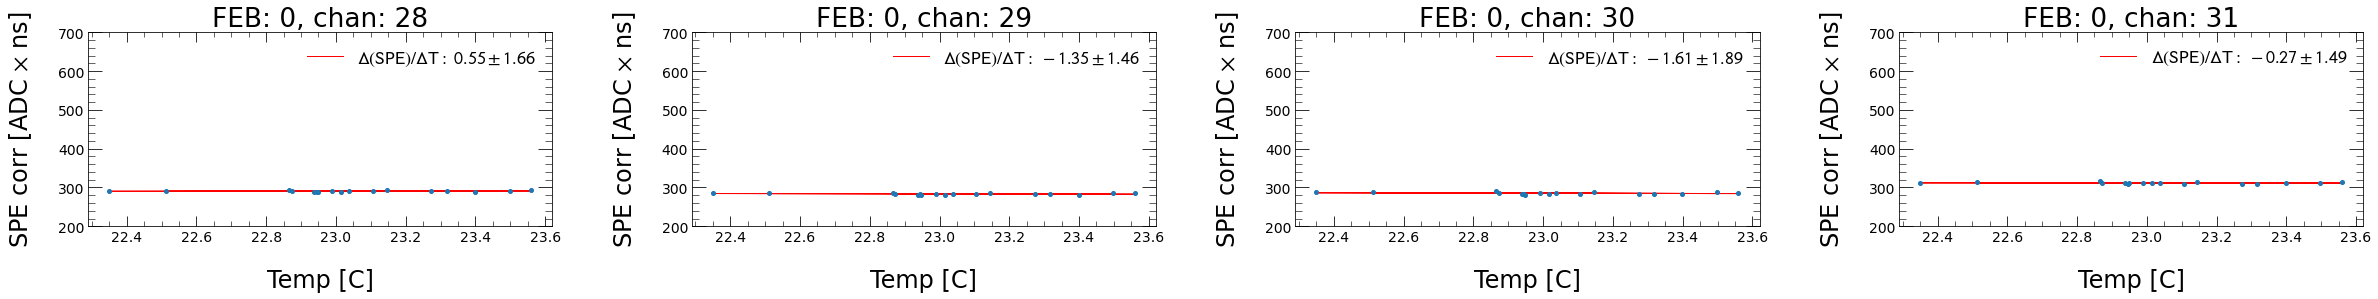

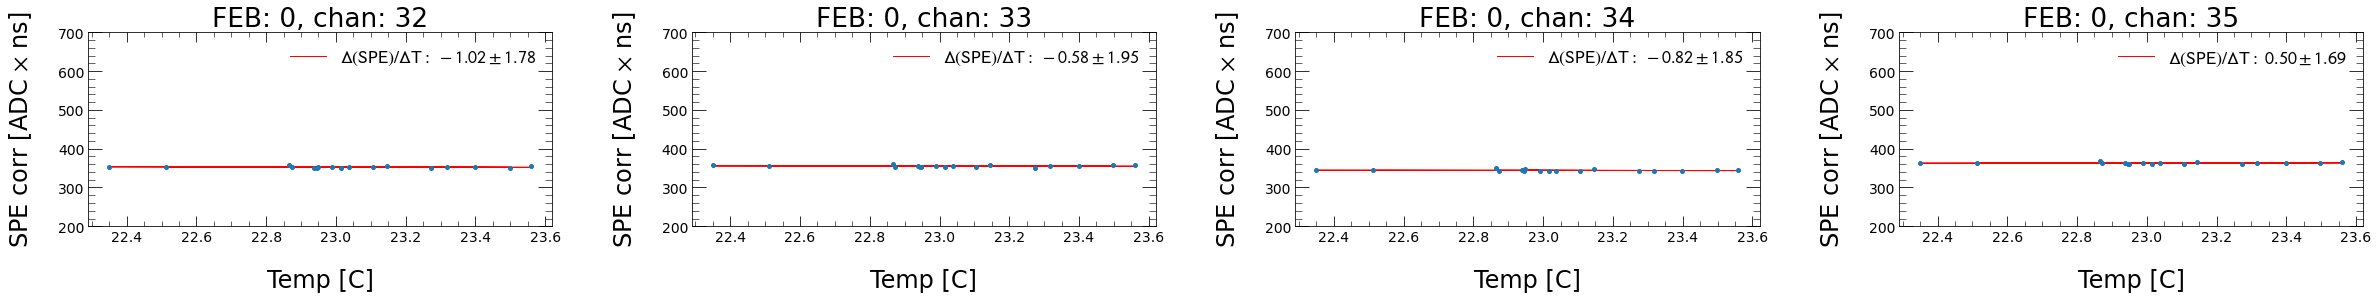

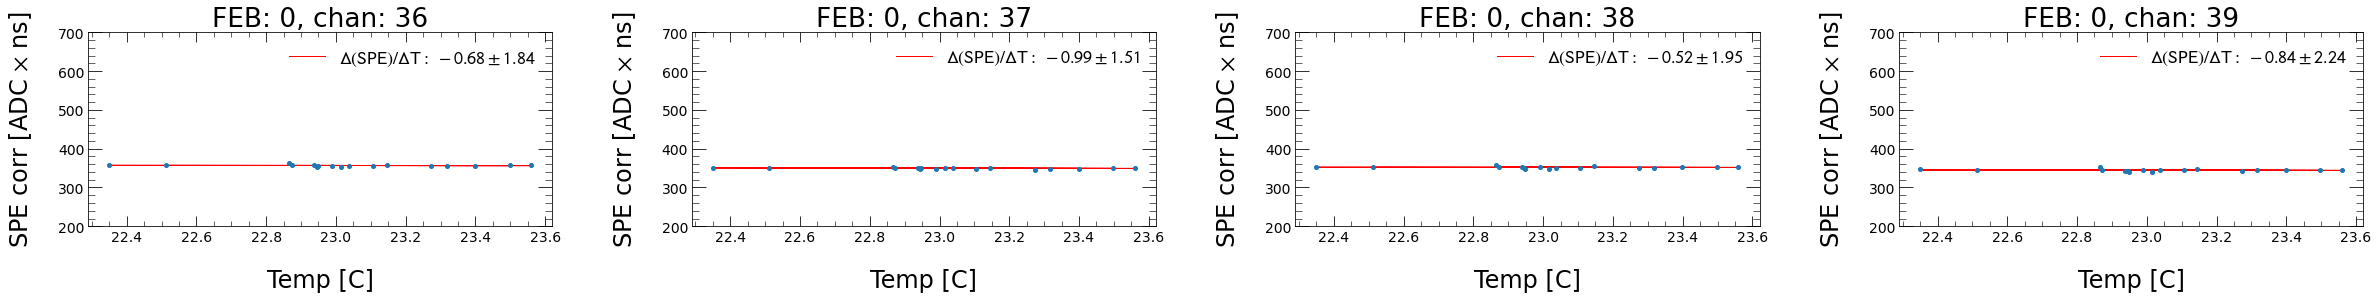

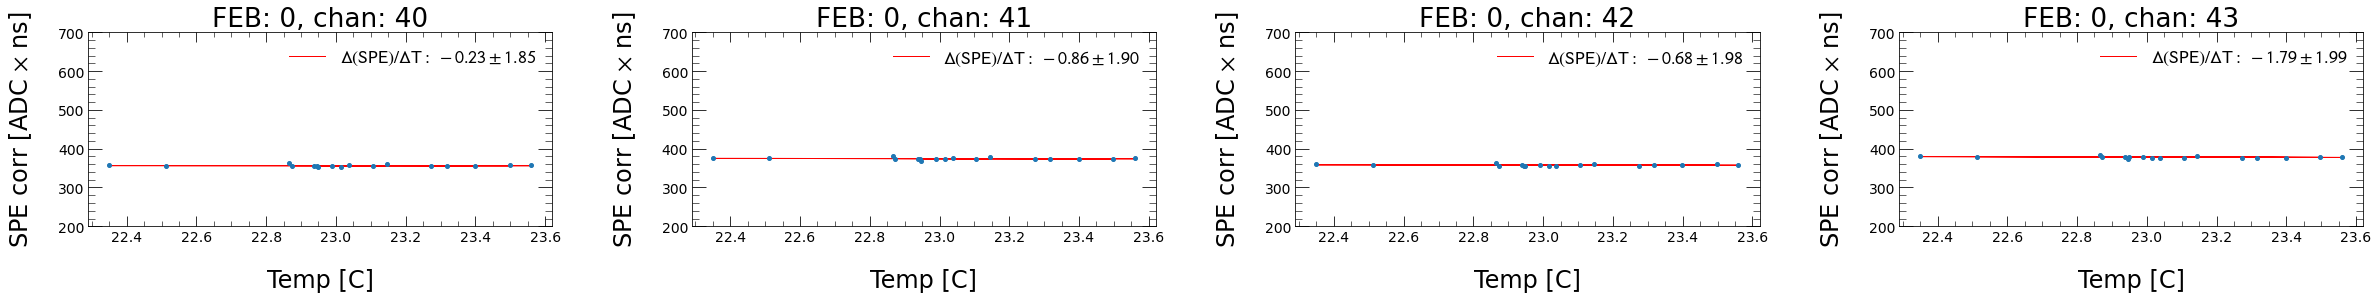

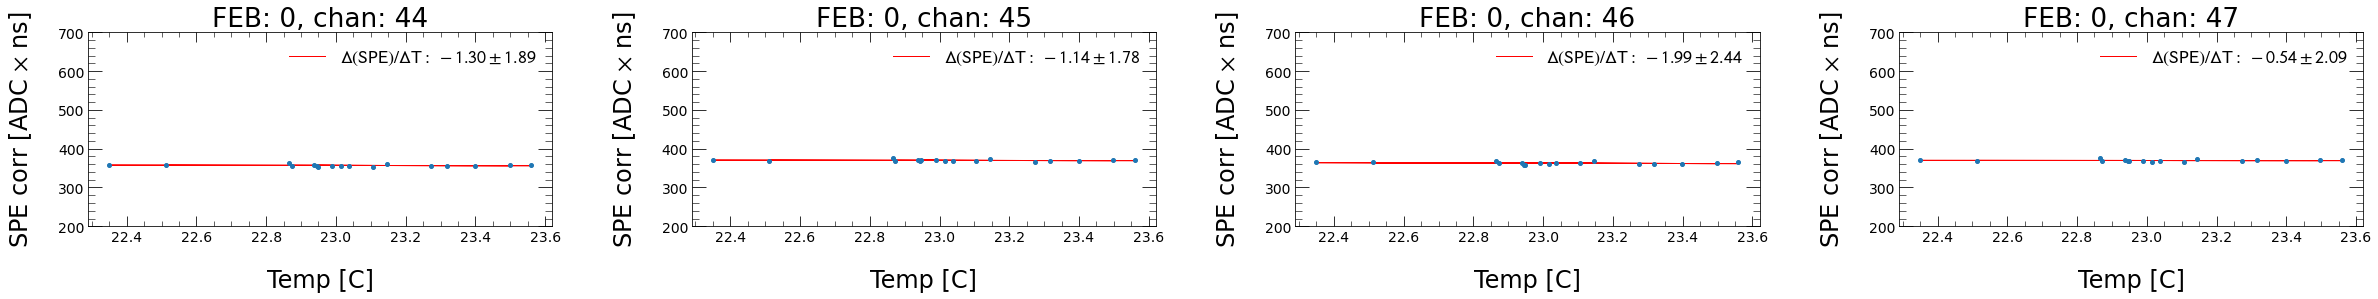

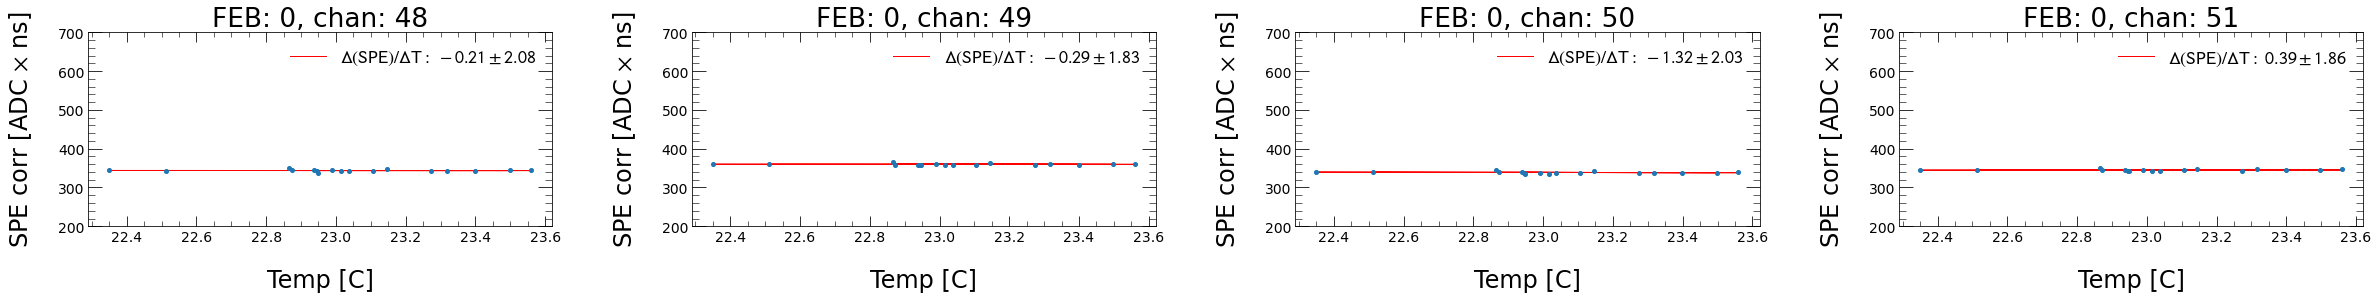

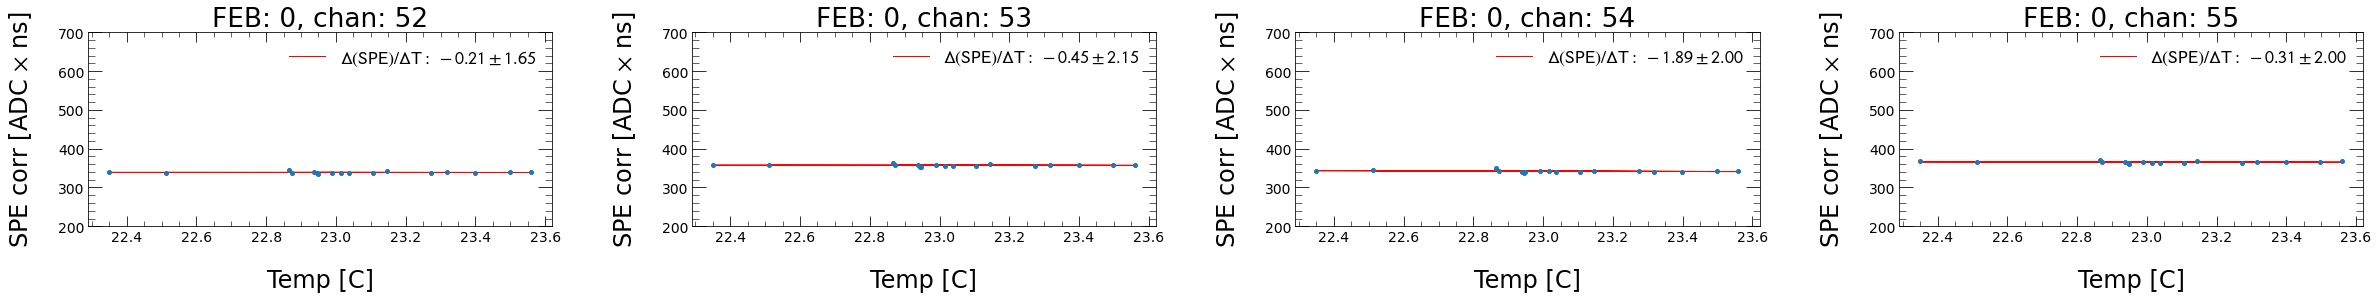

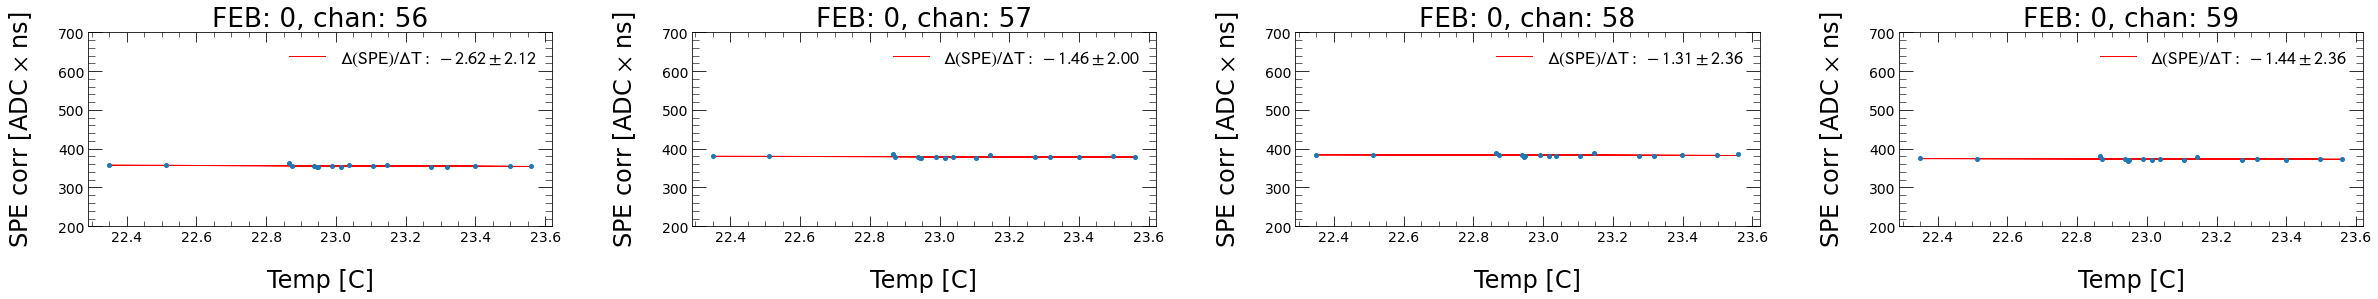

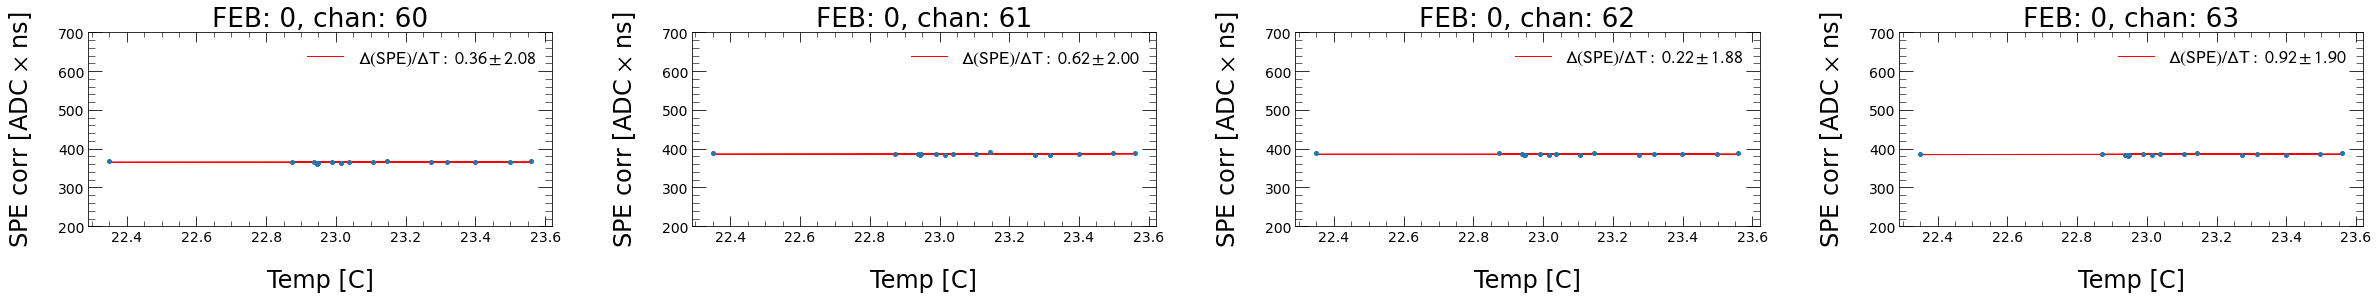

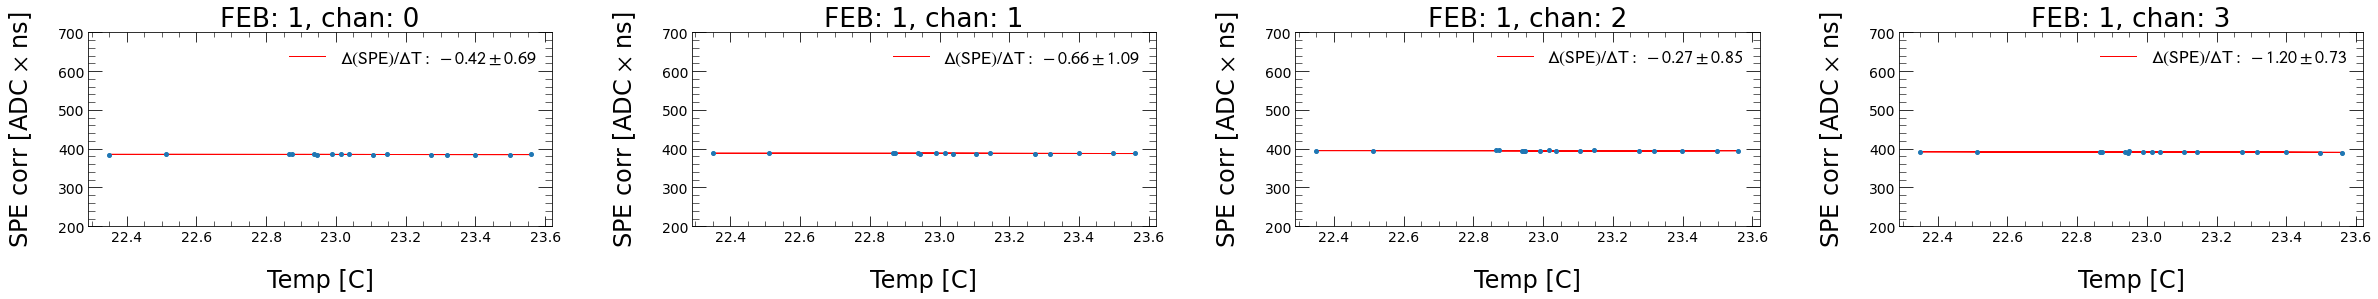

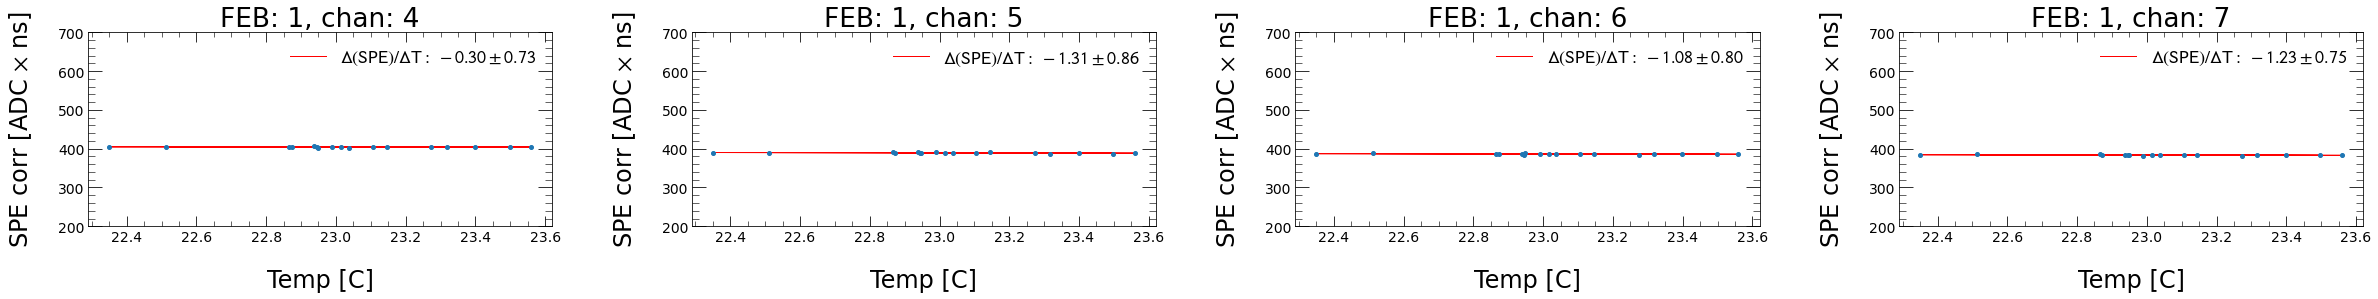

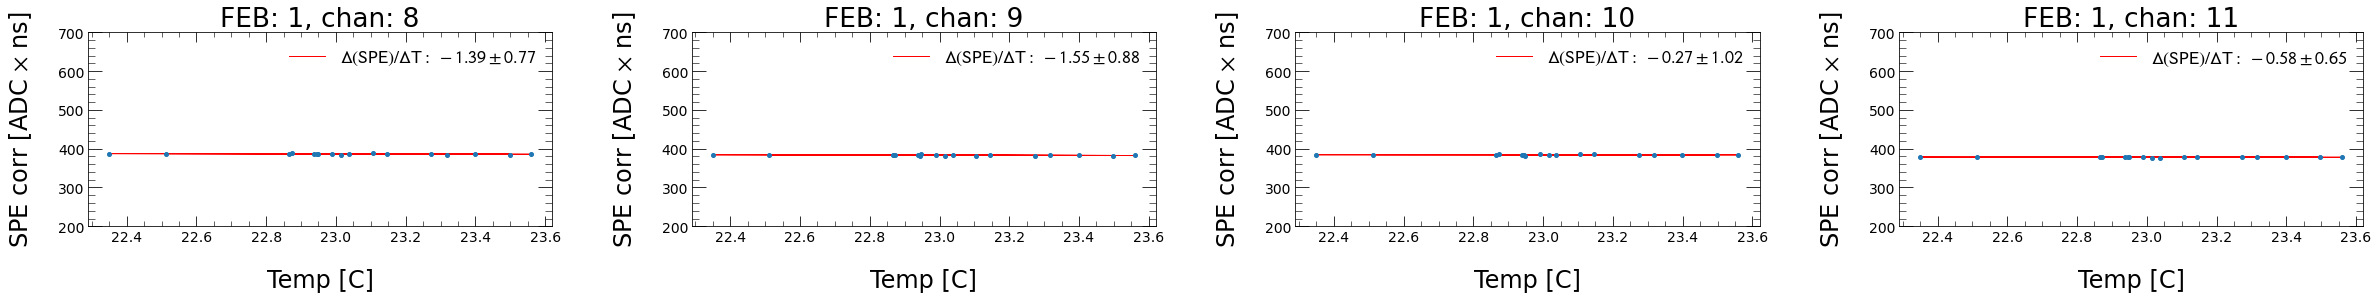

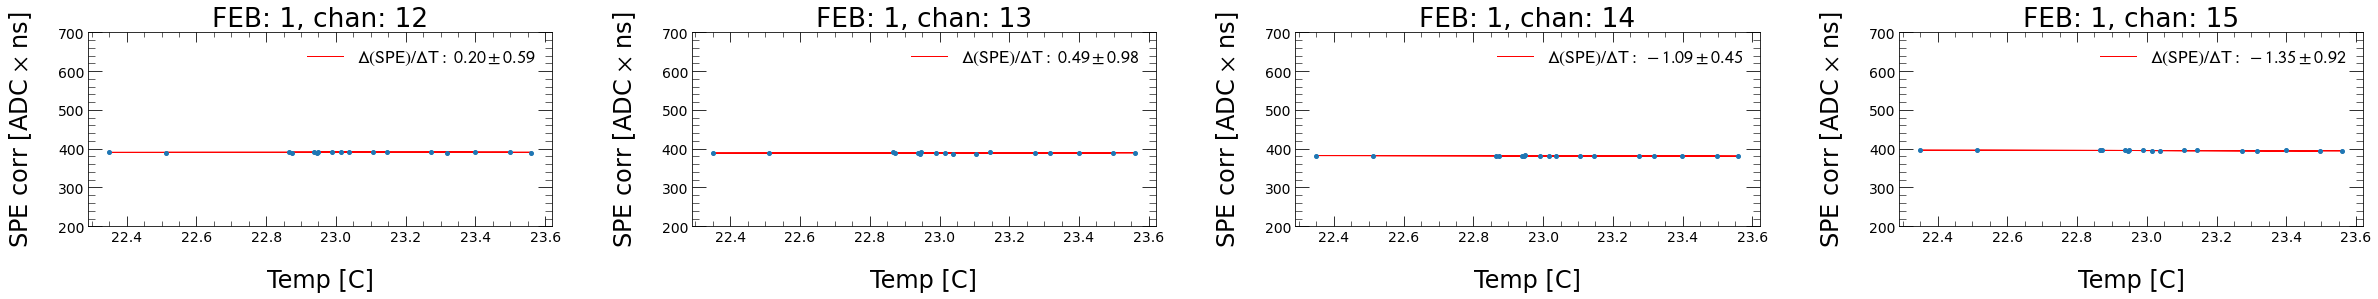

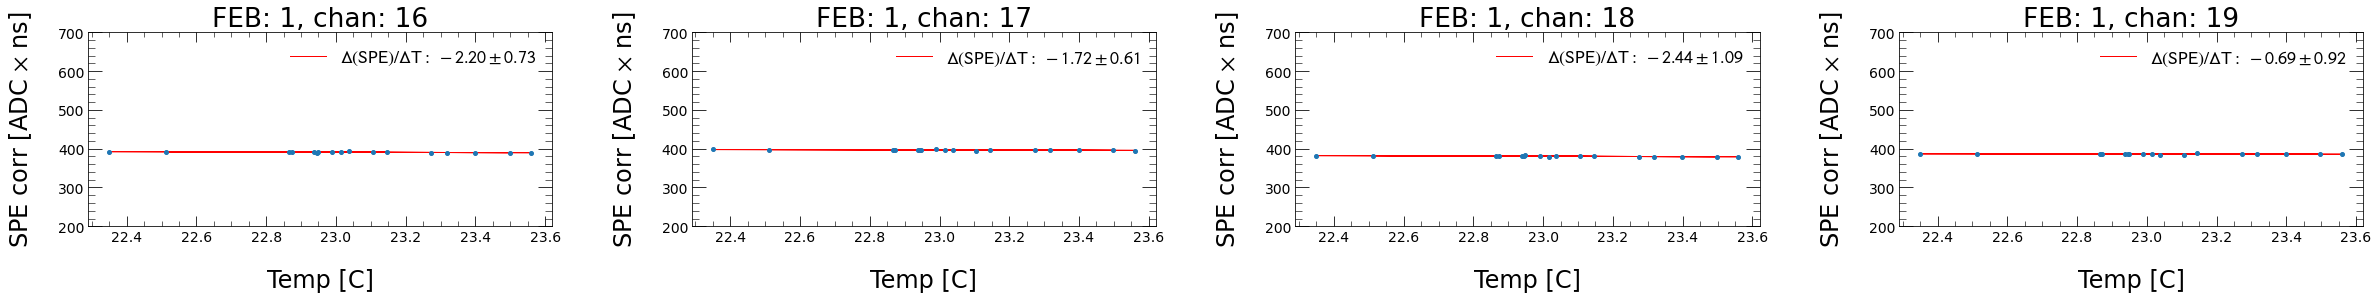

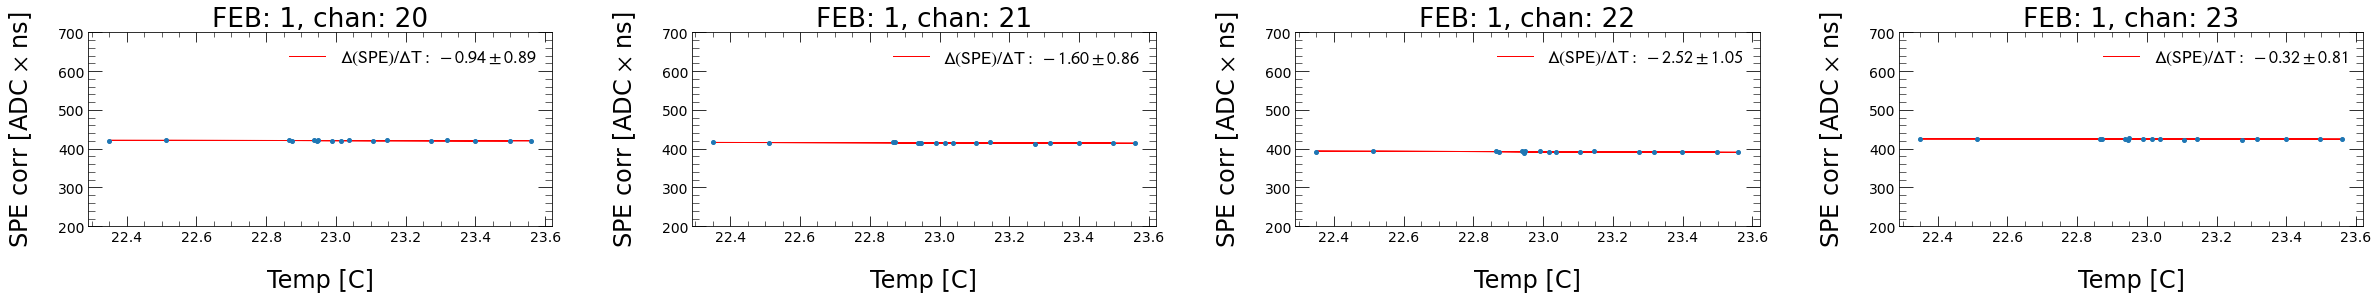

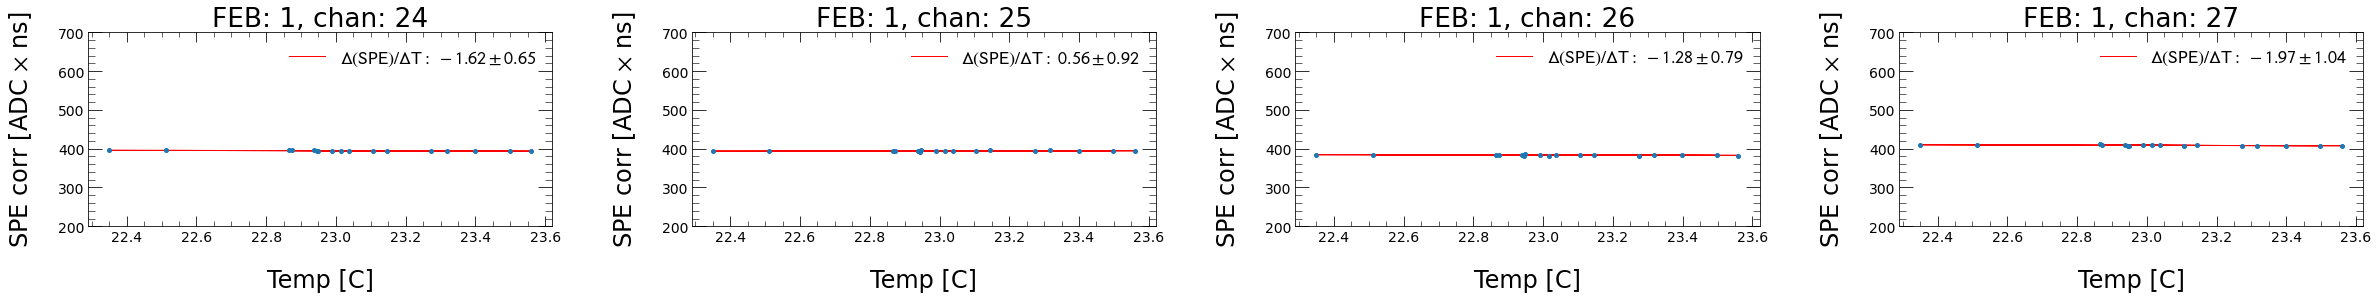

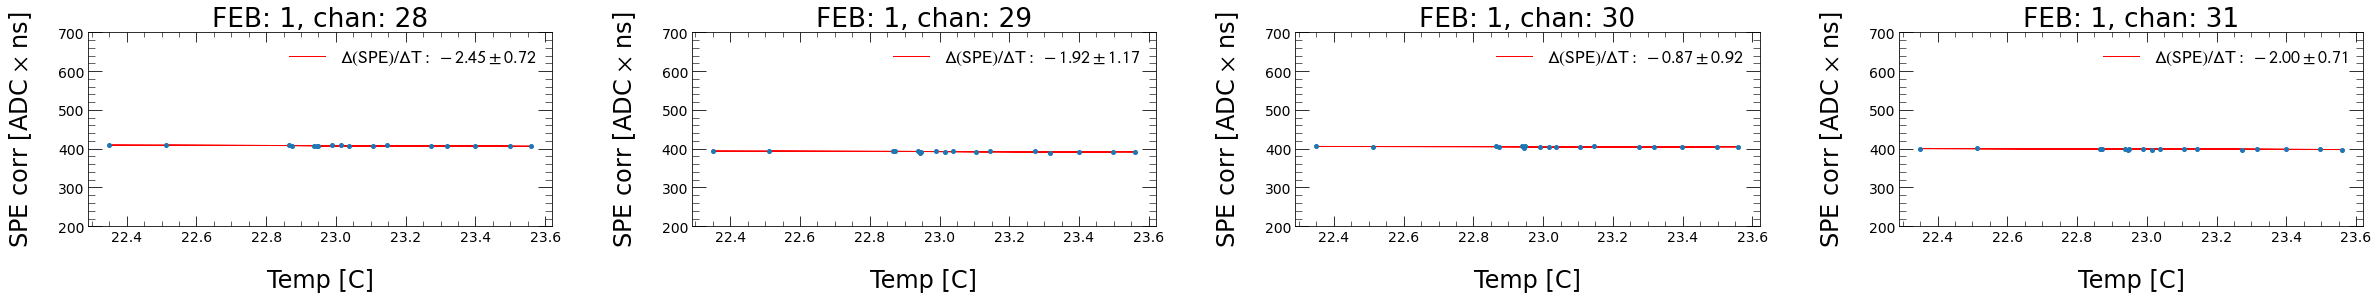

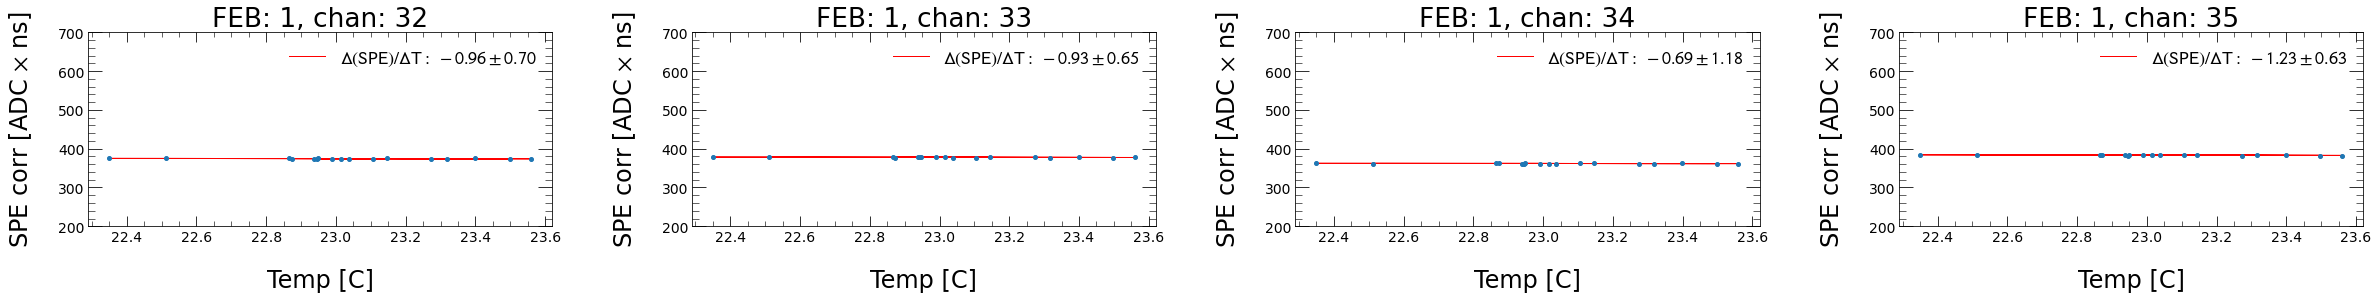

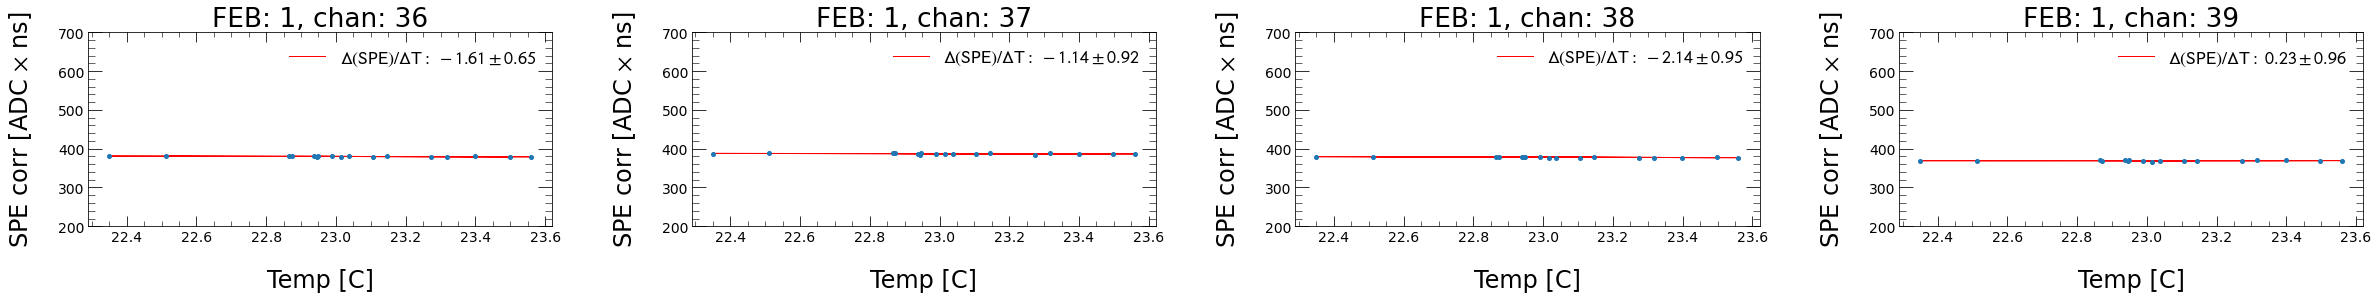

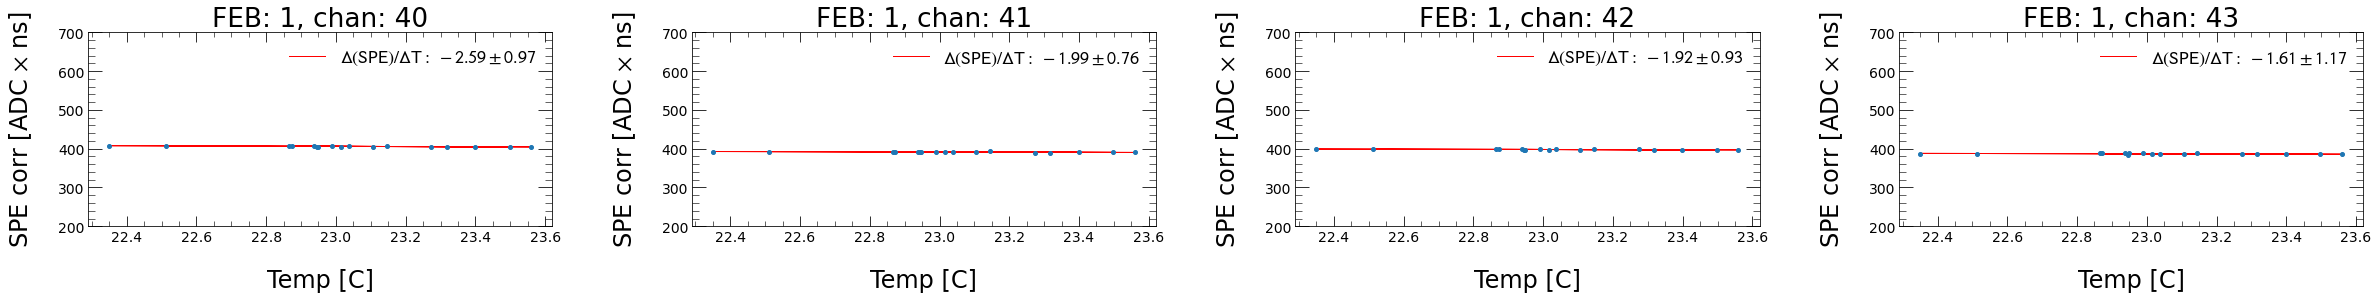

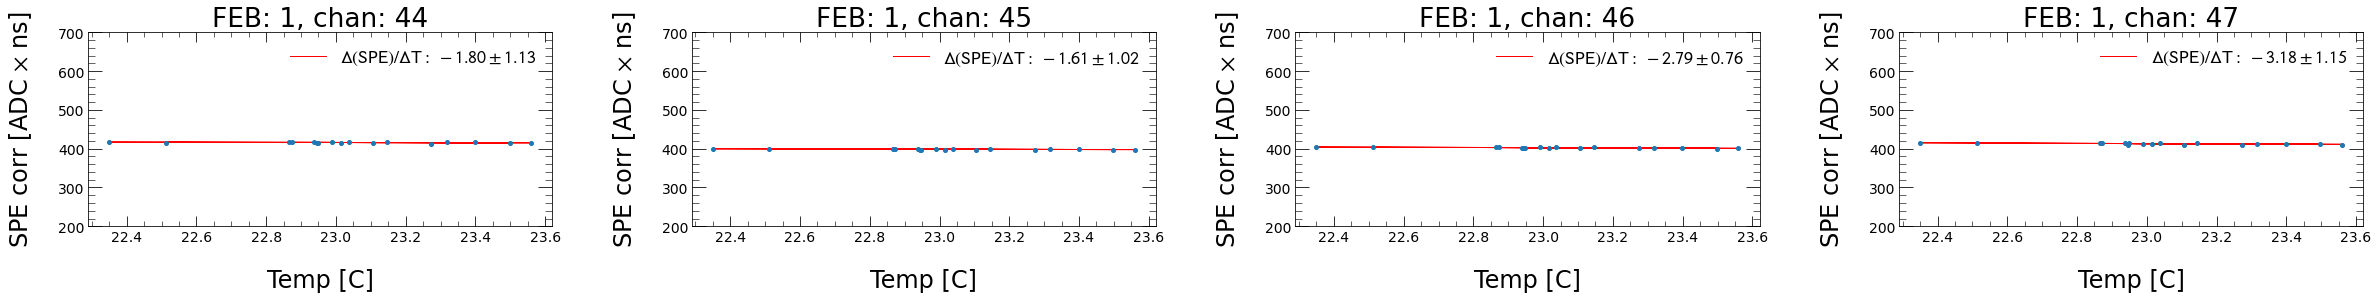

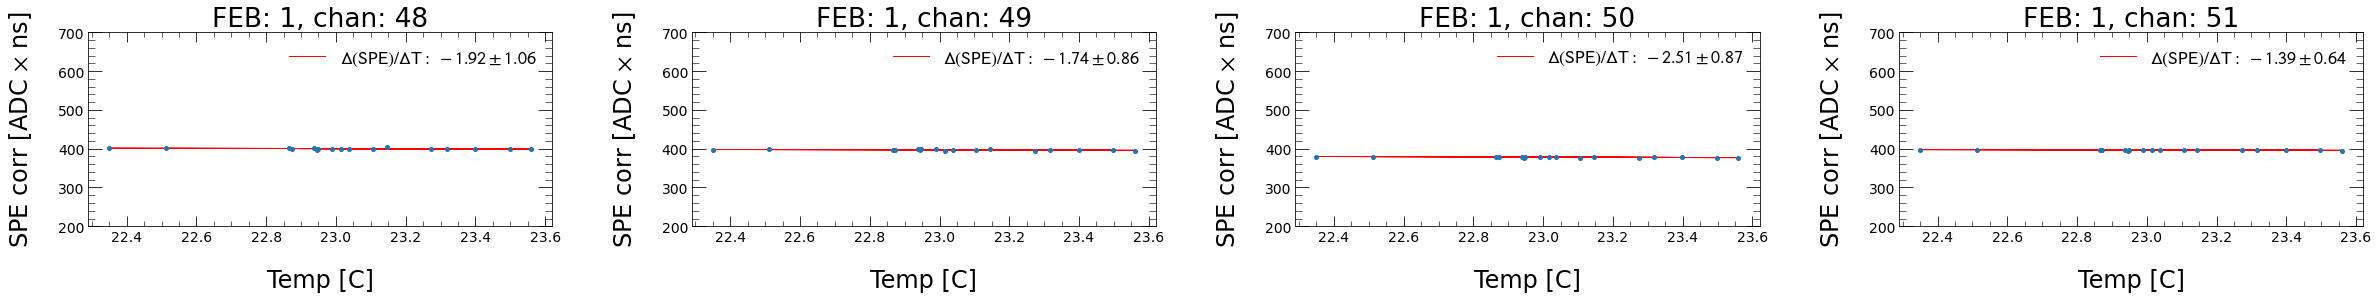

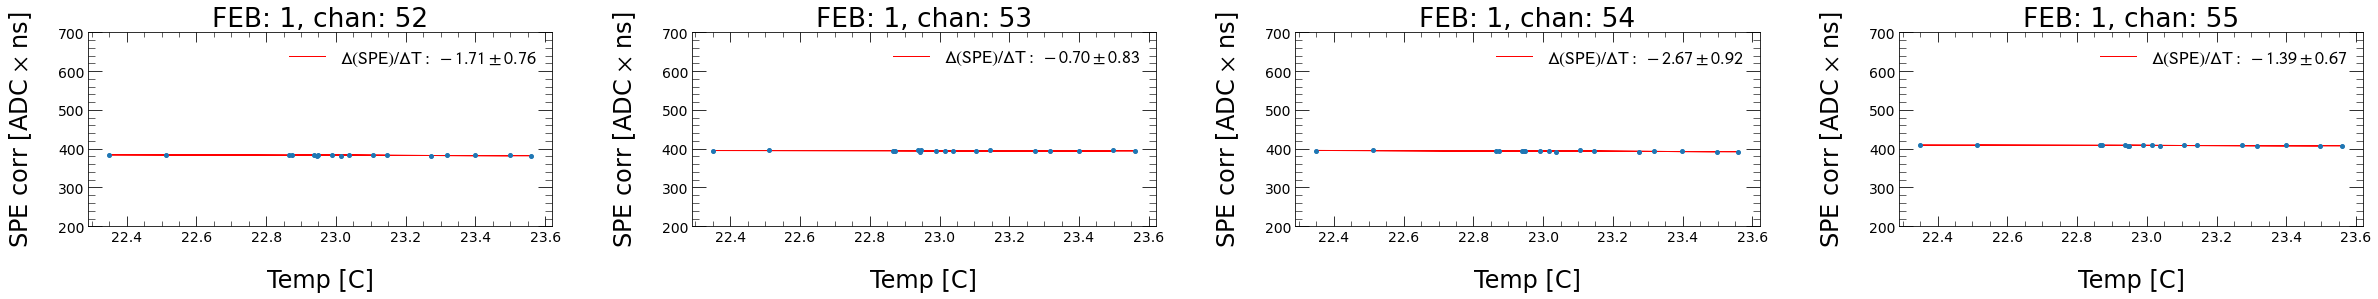

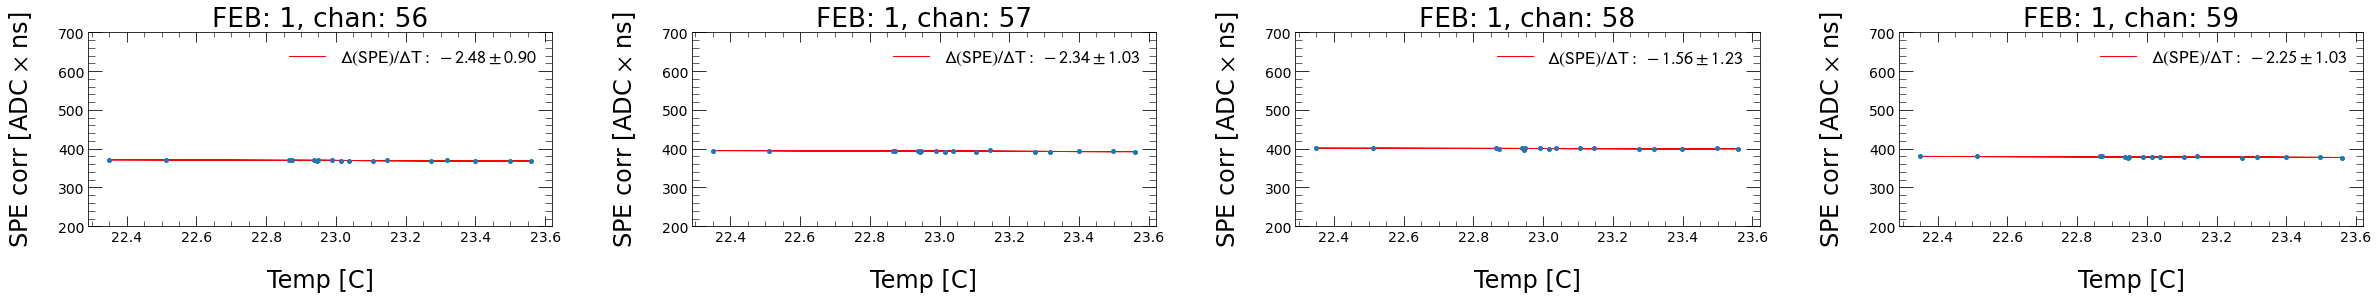

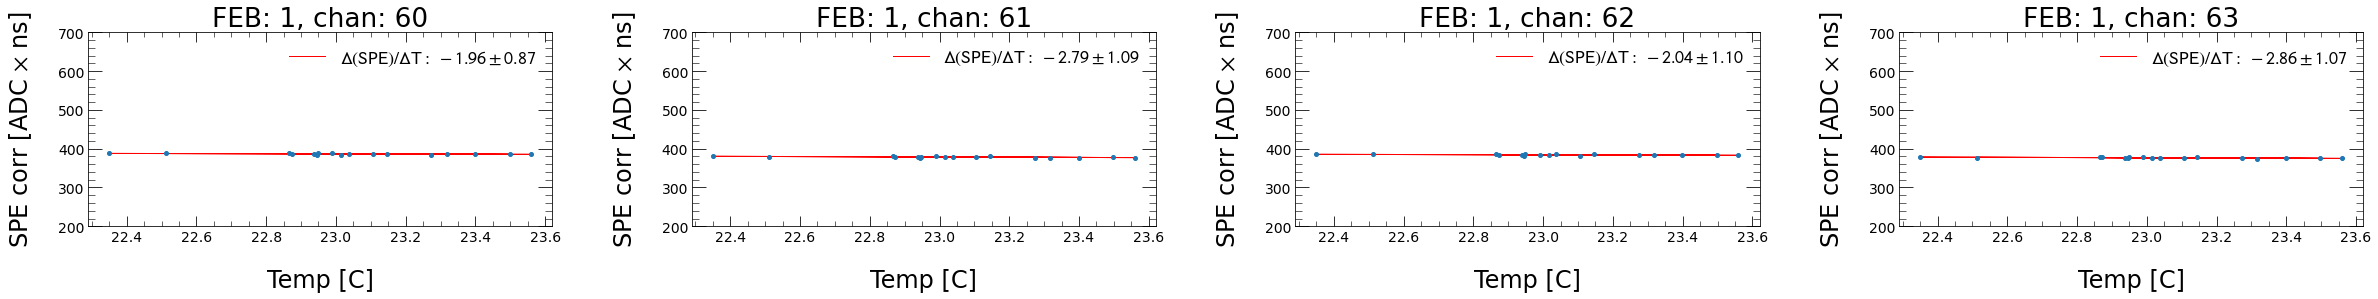

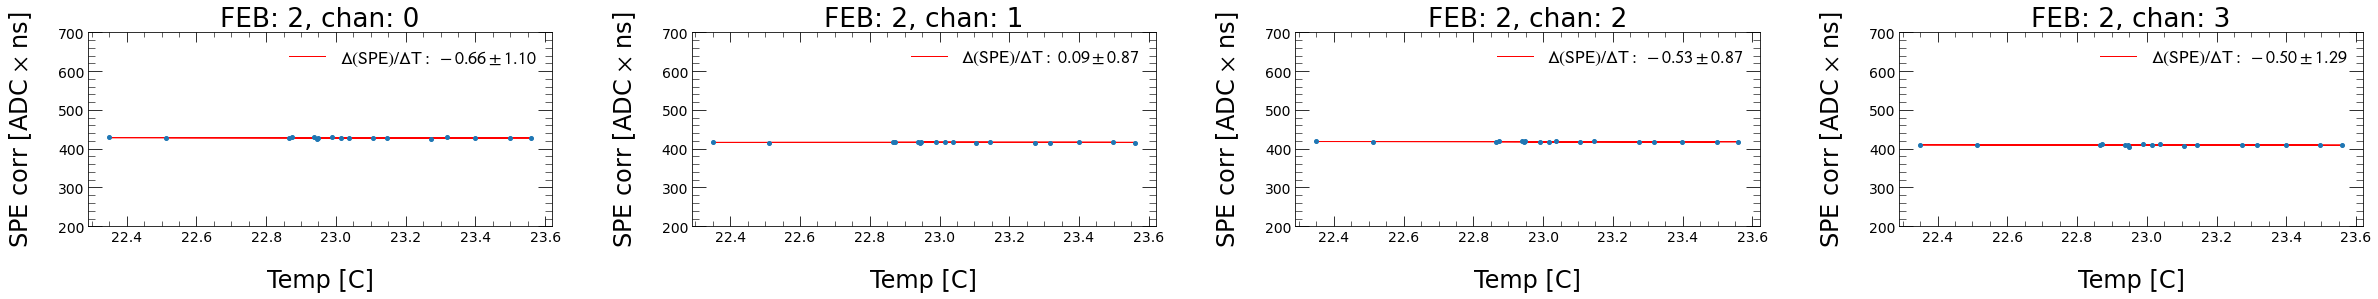

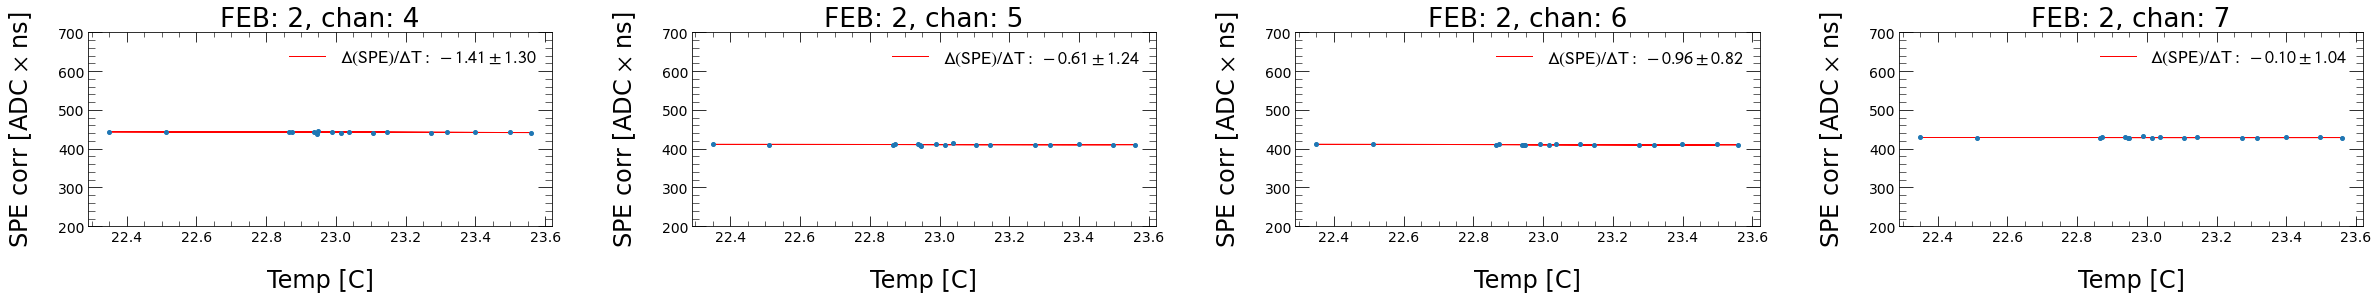

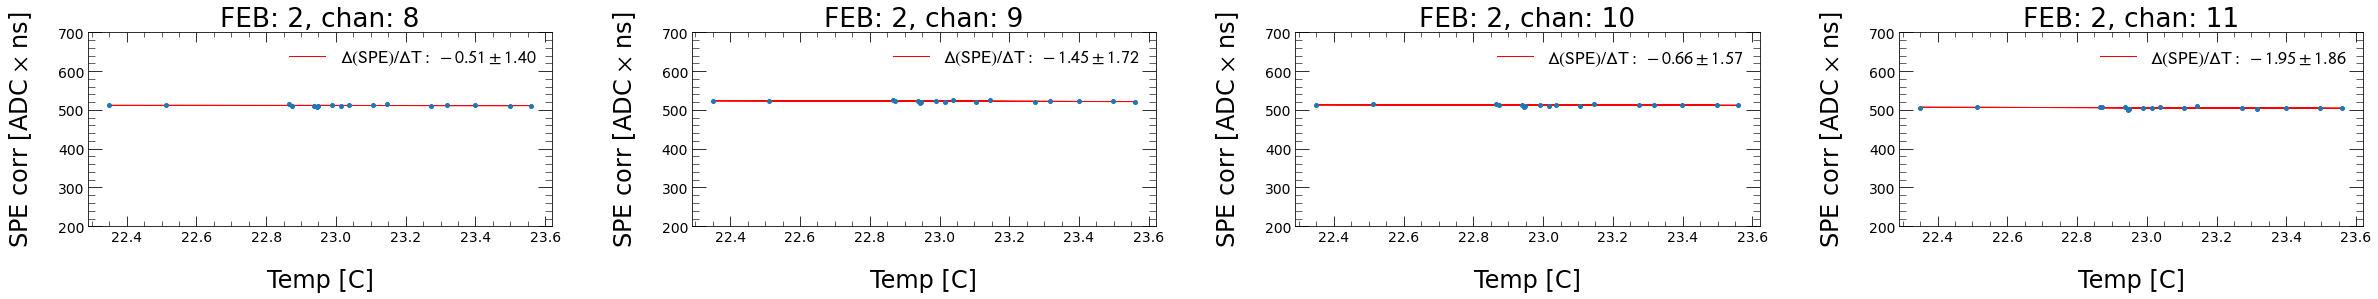

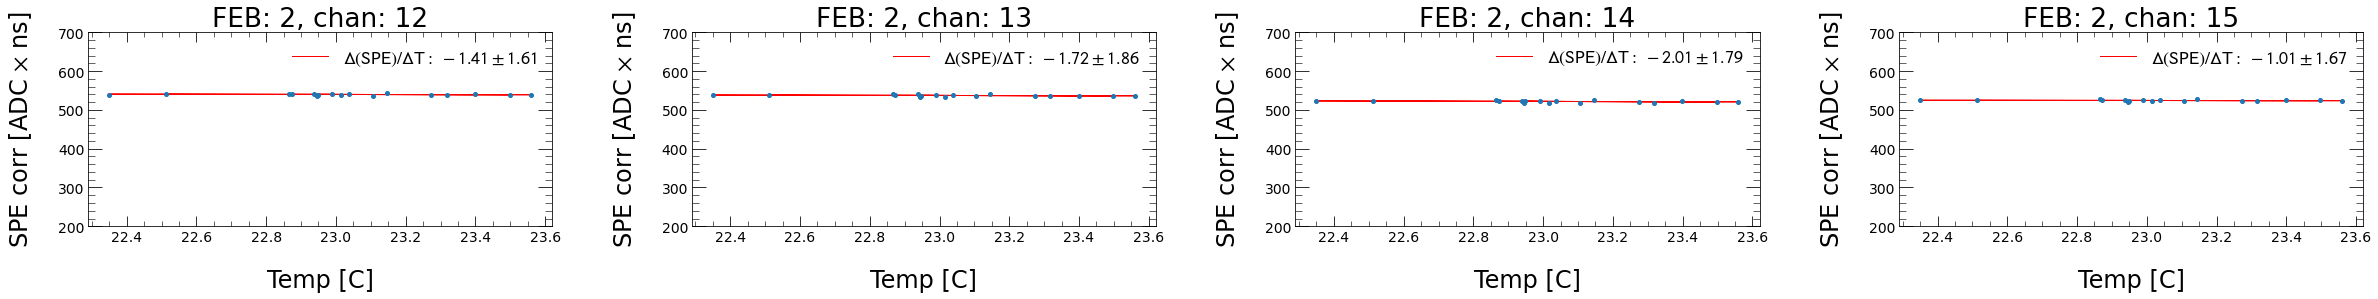

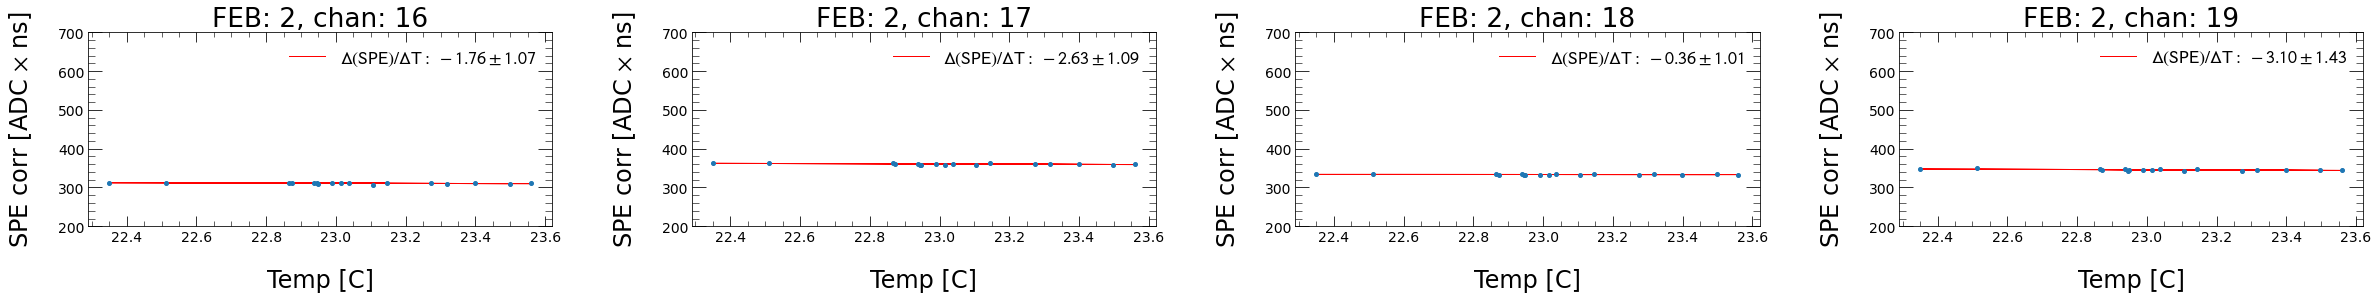

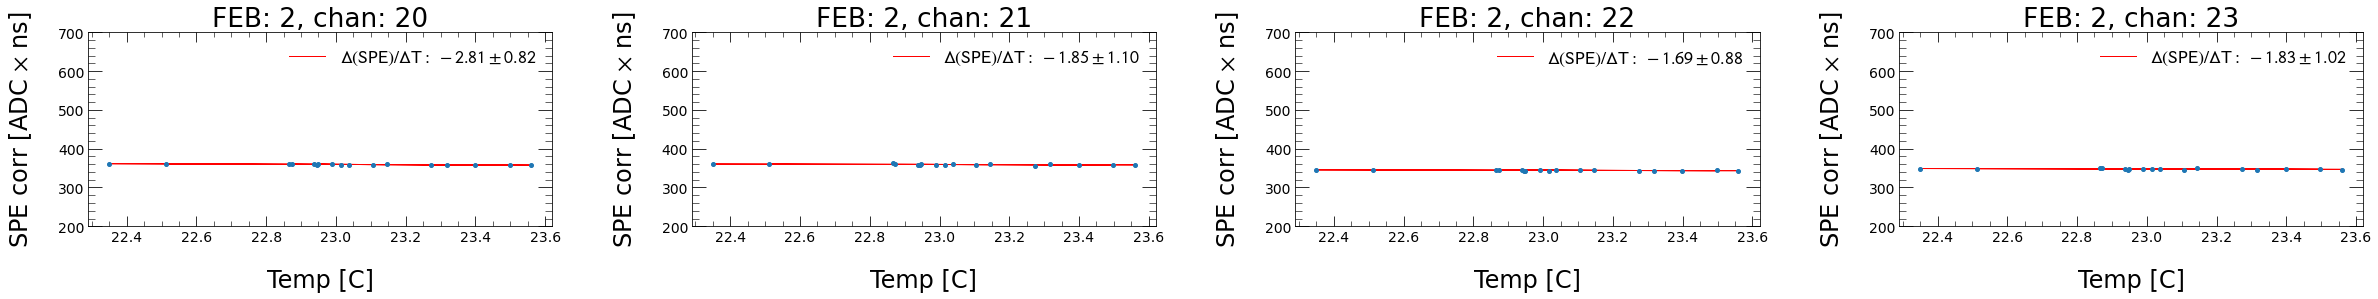

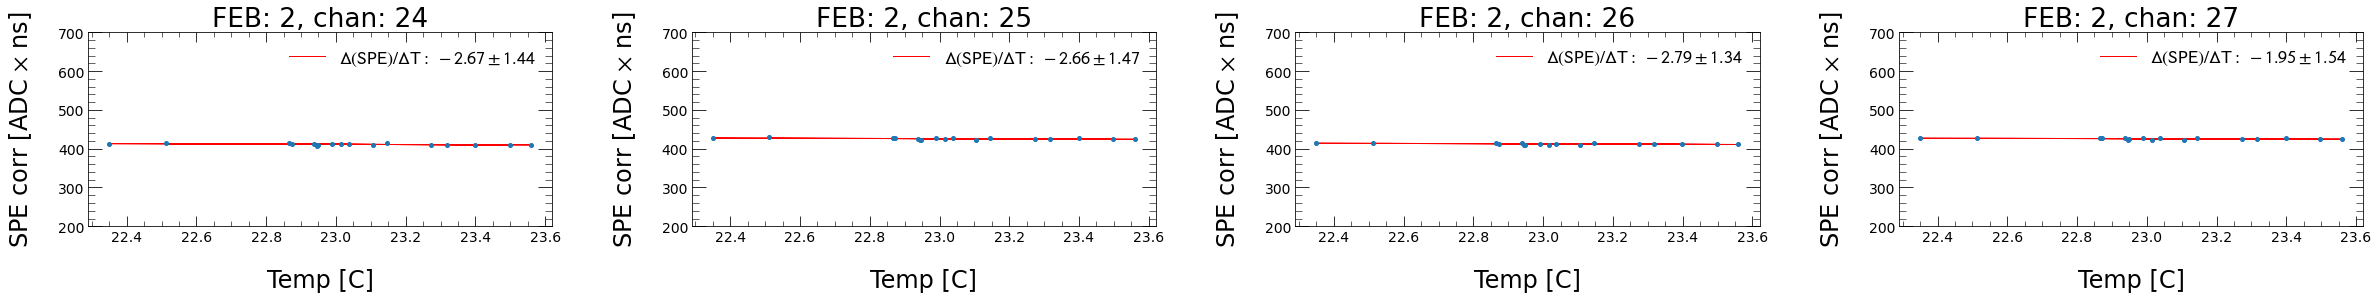

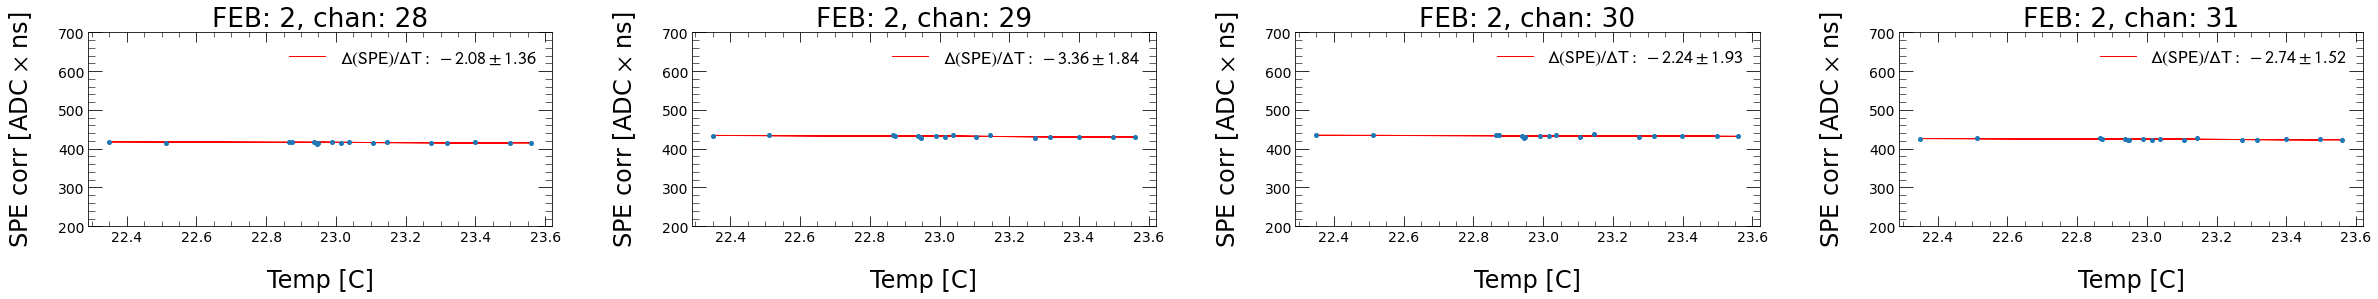

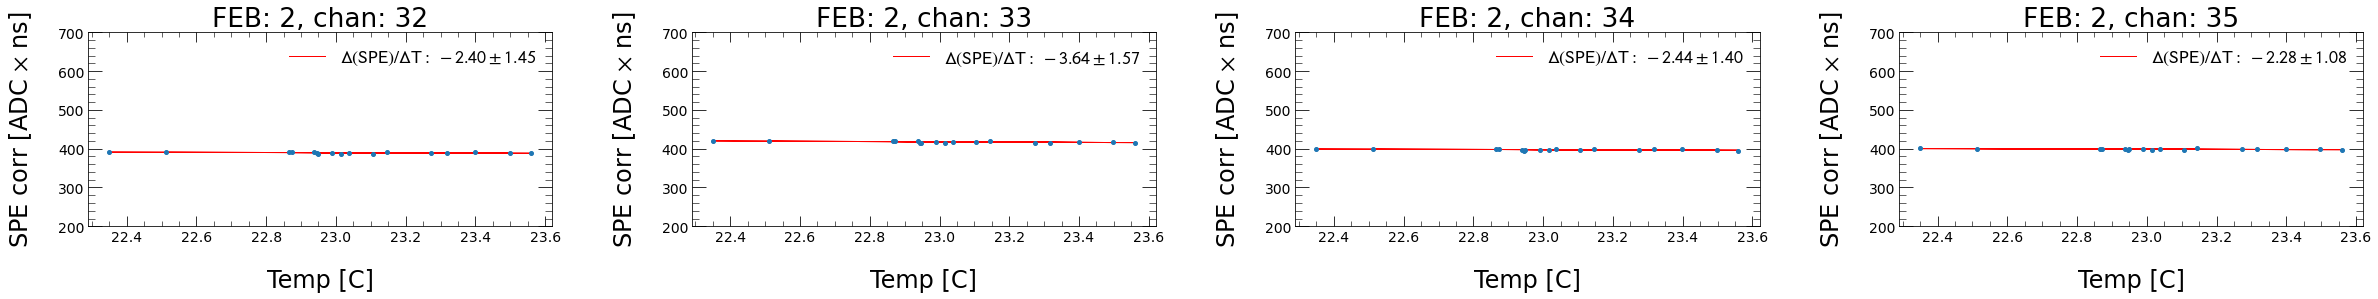

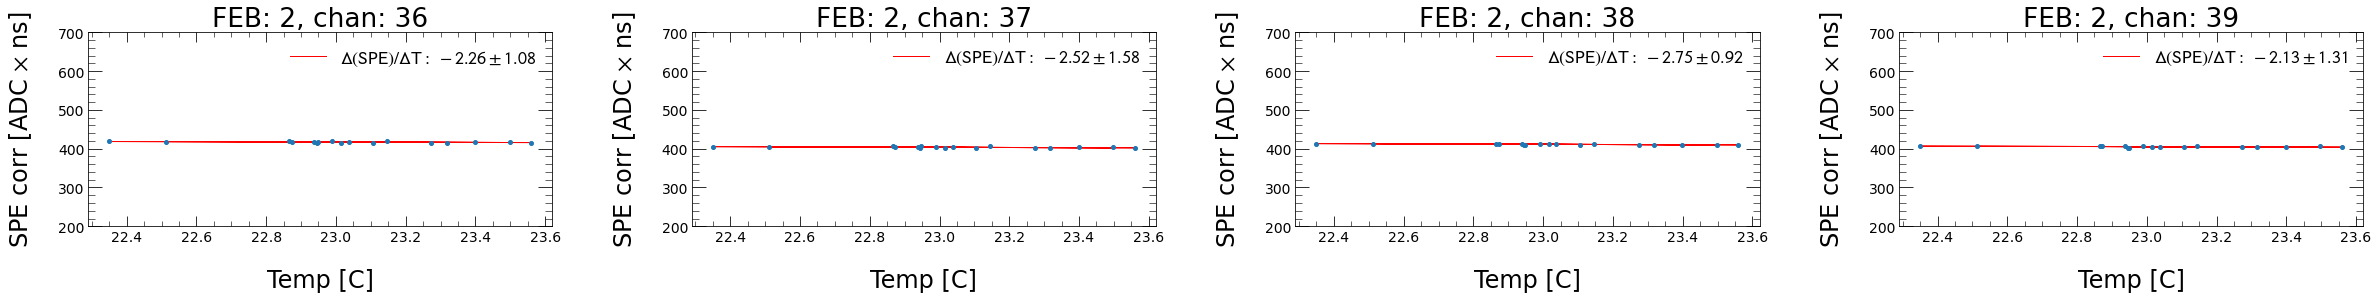

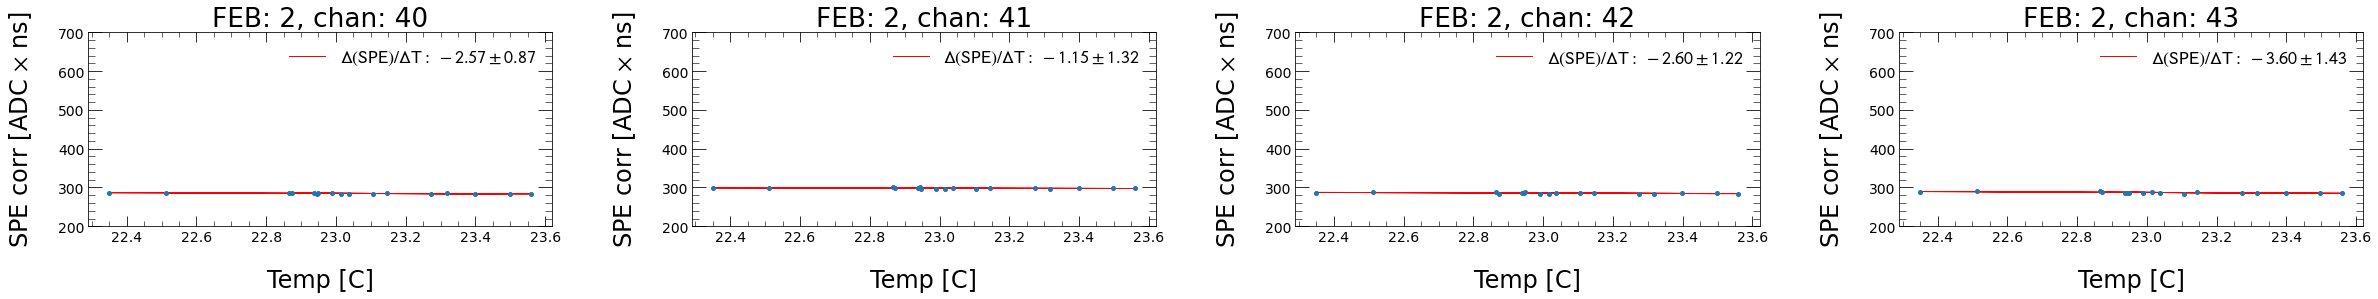

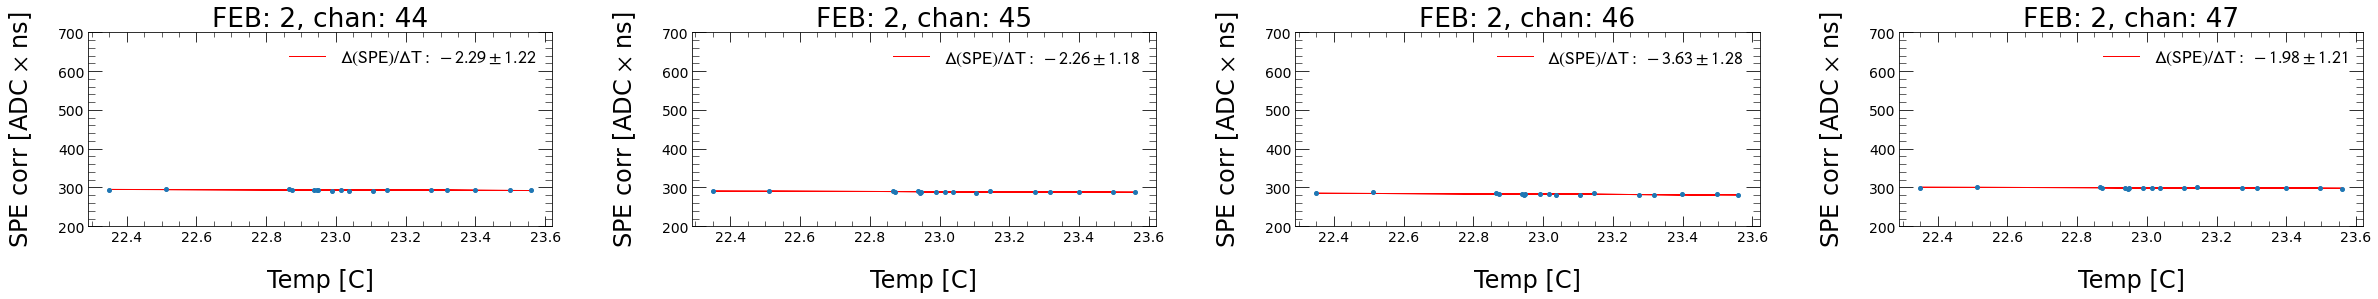

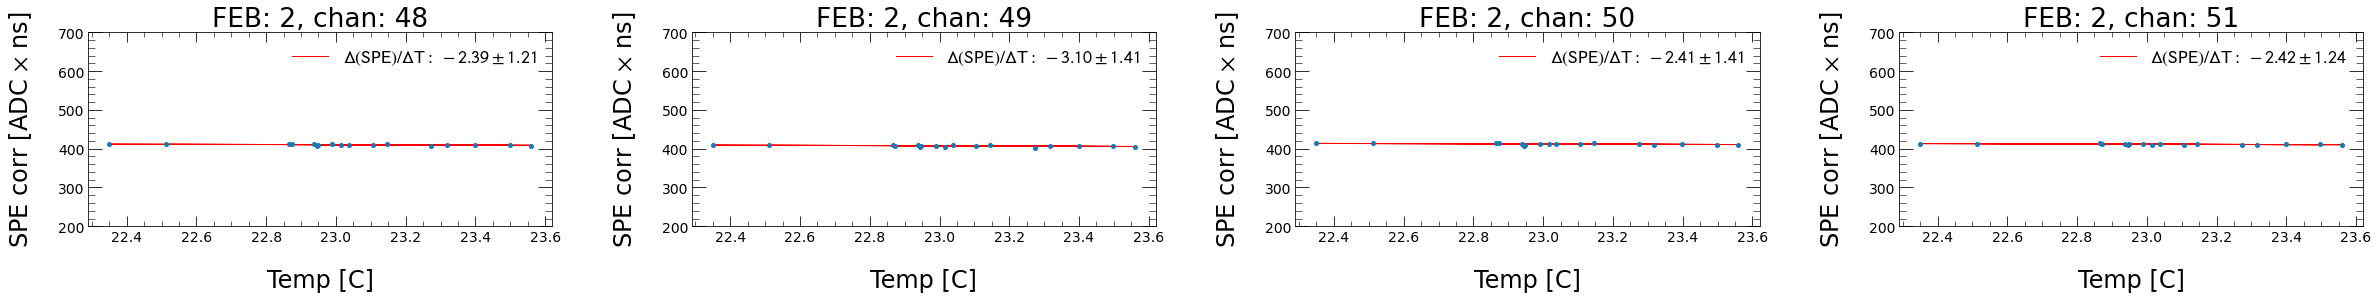

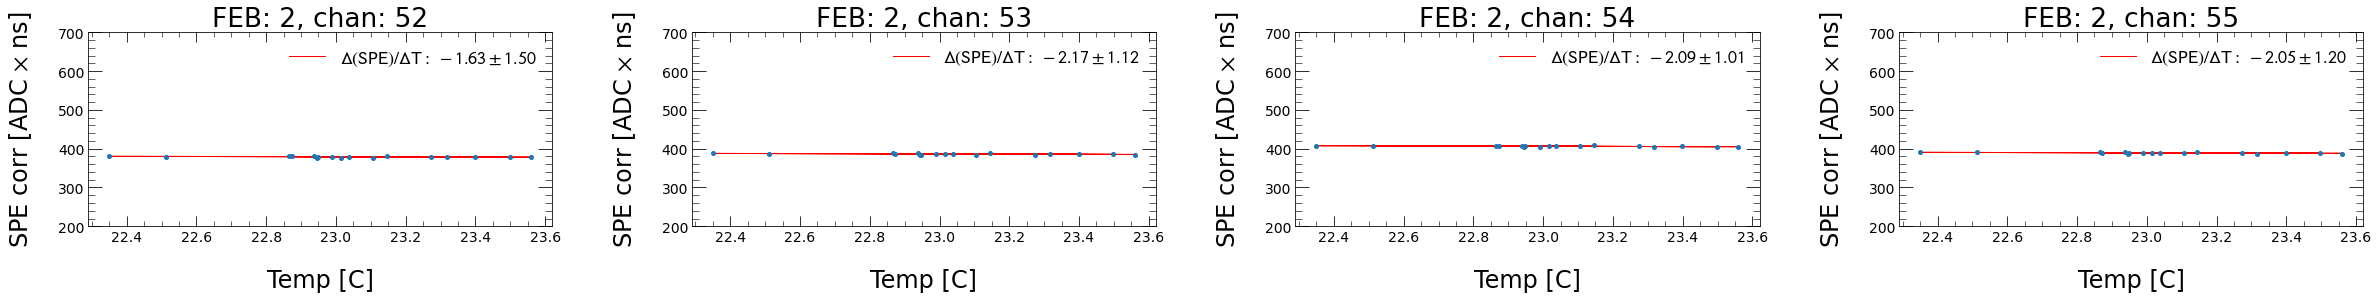

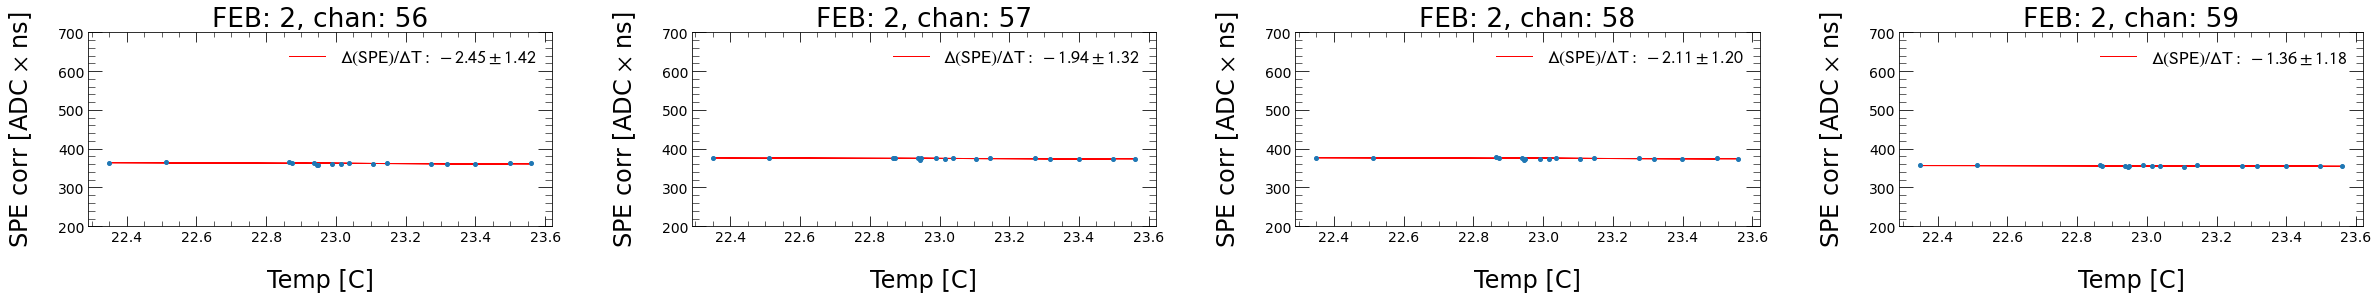

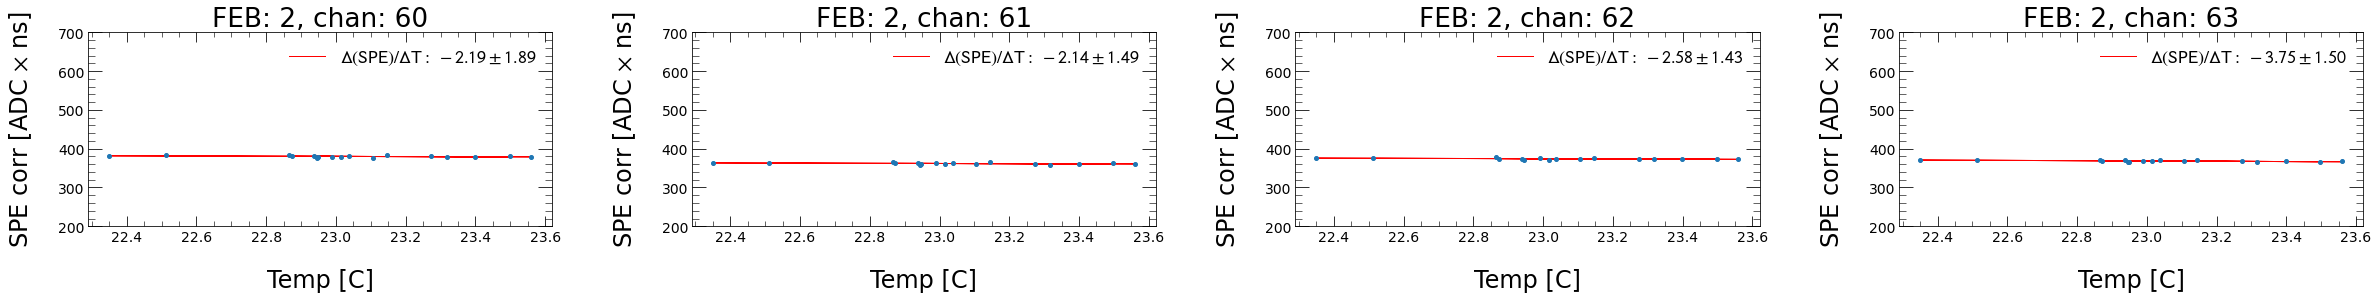

In [31]:
channel_range=range(0, 64)
slope_list = []
for feb in range(0, 3):
  for hdmi in hdmi_range:
    fig, ax1 = plt.subplots(nrows=1, ncols=4, figsize=(40, 3.5))
    plt.subplots_adjust(wspace=0.3)
    for chan in range(0, 4):

      chan_infeb = hdmi*4+chan
      x=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['meanTemperatures_0_0']
      y=df.query('PEsTemperatureCorrected_%d_%d>0'%(feb, chan_infeb))['calibConstantsTemperatureCorrected_%d_%d'%(feb, chan_infeb)]
      slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
      ax1[chan].plot(x, intercept + slope*x, 'r', label=r'$\Delta (SPE)/\Delta T: ~%.2f \pm %.2f$'%(slope, std_err))
      ax1[chan].plot(x,y,'.')
      ax1[chan].legend()
      ax1[chan].set_title('FEB: %d, chan: %d'%(feb, chan_infeb))

      ax1[chan].set_ylabel(r'SPE corr [ADC $\times$ ns]')
      ax1[chan].set_xlabel('Temp [C]')
      ax1[chan].set_ylim(200, 700)

      slope_list.append(slope)

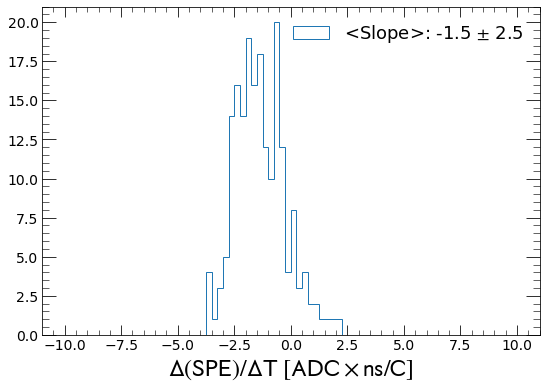

In [30]:
plt.hist(slope_list, bins=80, range=(-10,10), histtype='step', label='<Slope>: %.1f $\pm$ %.1f'%(np.mean(slope_list), np.std(slope_list)) );
plt.xlabel(r'$\Delta (SPE)/\Delta T ~[ADC \times ns/C]$', labelpad=5);
plt.legend();